In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from glob import glob
from tqdm import tqdm
from scipy.io import loadmat
from PIL import Image

import seaborn as sns
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

state = 1
np.random.seed(1)


DATA_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/data'
ROOT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge'
GROUND_PATH = DATA_PATH + '/groundTruth'
ORI_IMAGE_PATH = DATA_PATH + '/images'
OUT_IMAGE_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/image'
MODEL_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/model/'
WEIGHT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/weight/'


def save_fig(fig_id, tight_layout=True):
    if not os.path.exists(OUT_IMAGE_PATH):
        os.makedirs(OUT_IMAGE_PATH)
    path = os.path.join(OUT_IMAGE_PATH, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [4]:
import keras
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [3]:
test = loadmat('/media/tulan/Linux/Pycharm/Image_Edge/data/groundTruth/test/2018.mat')
testdata = test['groundTruth']

testdata[0, 0]['Boundaries'][0, 0].shape

(481, 321)

In [6]:
# mat = loadmat(DATA_PATH + '/train' +)
y_train = []
y_test = []
y_val = []

for foldname in os.listdir(GROUND_PATH):
    for img in sorted(os.listdir(os.path.join(GROUND_PATH, foldname))):
        IMG_DIR = os.path.join(GROUND_PATH, foldname, img)
        mat = loadmat(IMG_DIR)
        matdata = mat['groundTruth']
        if matdata[0, 0]['Boundaries'][0, 0].shape == (321, 481):
            data_c = np.zeros((321, 481))
        else:
            data_c = np.zeros((481, 321))
        # data = matdata[0, 0]['Boundaries'][0, 0]
        # rotate to the same size
        for i in range(0, matdata.shape[1]):
            data = matdata[0, i]['Boundaries'][0, 0]
            data_c = np.maximum(data, data_c)
            if i == matdata.shape[1] - 1:
                if data_c.shape == (481, 321):              # size: H - W
                    data_c = cv2.resize(data, (320, 480))   # size: W - H
                    data_c = Image.fromarray(data_c)
                    data_c = np.asarray(data_c.rotate(90, expand=True))
                else:
                    data_c = cv2.resize(data_c, (480, 320))
                if foldname == 'test':
                    y_test.append(data_c)
                elif foldname == 'val':
                    y_val.append(data_c)
                else:
                    y_train.append(data_c)

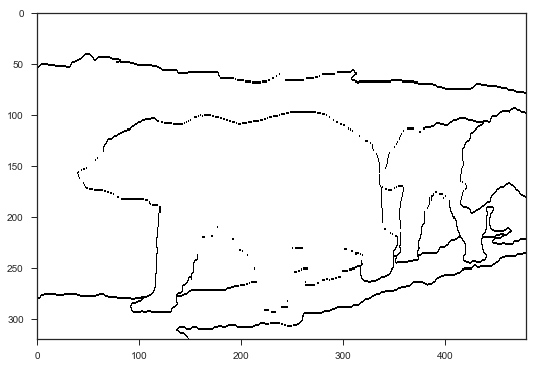

0.030360760427707044

In [66]:
test = np.copy(y_train[0])
for i in range(0, len(test)):
    for j in range(0, len(test[i])):
        if test[i][j] == 1 and i + 1 < 320:
            test[i-1][j] = 1
plt.figure(figsize=(10, 6))
plt.imshow(test, cmap='binary')
plt.show()
cnt_1 = (test == 1).sum()
cnt_0 = (test == 0).sum()
float(cnt_1) / cnt_0

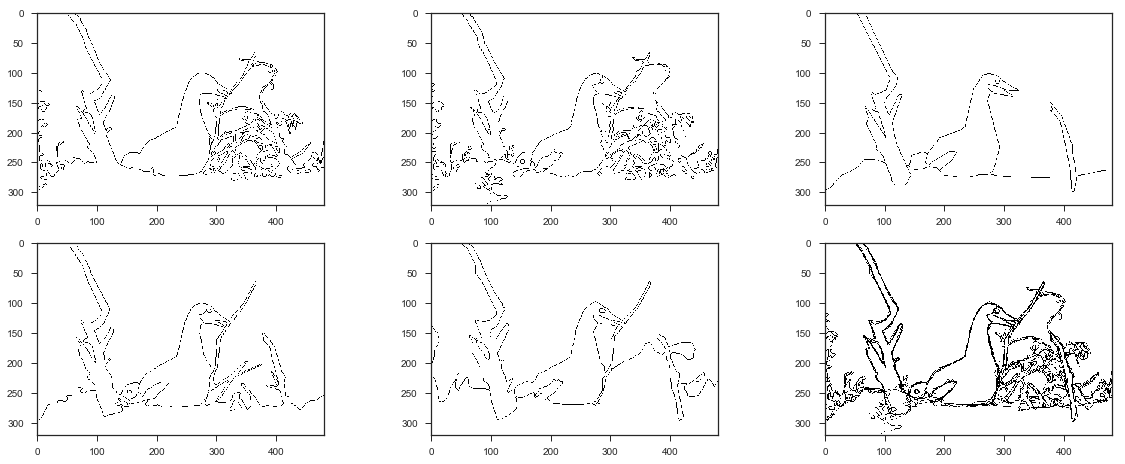

In [94]:
plt.figure(figsize=(20,12))
mat = loadmat(GROUND_PATH + '/train/8049.mat')
matdata = mat['groundTruth']
final_data = np.zeros((321, 481))
for i in range(0, matdata.shape[1]):
    data = matdata[0, i]['Boundaries'][0, 0]
    final_data = np.maximum(data, final_data)
    plt.subplot(3, 3, i+1)
    plt.imshow(data, cmap='binary')
    if i == matdata.shape[1] - 1:
        plt.subplot(3, 3, i+2)
        plt.imshow(final_data, cmap='binary')     
plt.show()

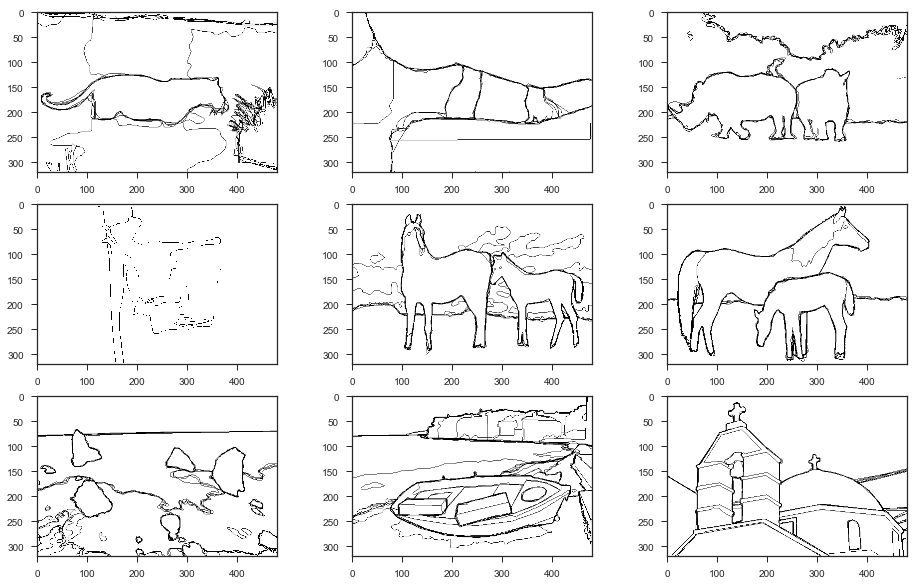

In [7]:
plt.figure(figsize=(16, 10))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(y_train[i+10], cmap='binary')
plt.show()

In [6]:
tot = 0.0
for y in y_train:
    cnt_1 = (y == 1).sum()
    cnt_0 = (y == 0).sum()
    tot += float(cnt_1) / cnt_0
mean = tot / len(y_train)
mean

0.018724523503115691

In [7]:
y_train = np.asarray(y_train, dtype='uint8')
y_test = np.asarray(y_test, dtype='uint8')
y_val = np.asarray(y_val, dtype='uint8')
y_train.shape, y_val.shape, y_test.shape

((200, 320, 480), (100, 320, 480), (200, 320, 480))

In [81]:
np.savetxt(DATA_PATH + '/hahaha.txt', y_train[0], delimiter=',', fmt='%d')

In [8]:

np.save(DATA_PATH + '/y_train_concat.npy', y_train)
np.save(DATA_PATH + '/y_test_concat.npy', y_test)
np.save(DATA_PATH + '/y_val_concat.npy', y_val)

In [2]:
X_train = []
X_test = []
X_val = []

for foldname in tqdm(os.listdir(ORI_IMAGE_PATH)):
    i = 0
    for img in sorted(glob(ORI_IMAGE_PATH + '/' + foldname + '/*')):
        data = cv2.imread(img)
        if data.shape == (481, 321, 3):
            data = cv2.resize(data, (320, 480))
            data = Image.fromarray(data)
            data = np.asarray(data.rotate(90, expand=True))
        else:
            data = cv2.resize(data, (480, 320))
        if foldname == 'test':
            X_test.append(data)
        elif foldname == 'val':
            X_val.append(data)
        else:
            X_train.append(data)
        i += 1

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:01<00:03,  1.73s/it]

 67%|██████▋   | 2/3 [00:03<00:01,  1.84s/it]

100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

In [3]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_val = np.asarray(X_val)
X_train.shape, X_test.shape, X_val.shape

((200, 320, 480, 3), (200, 320, 480, 3), (100, 320, 480, 3))

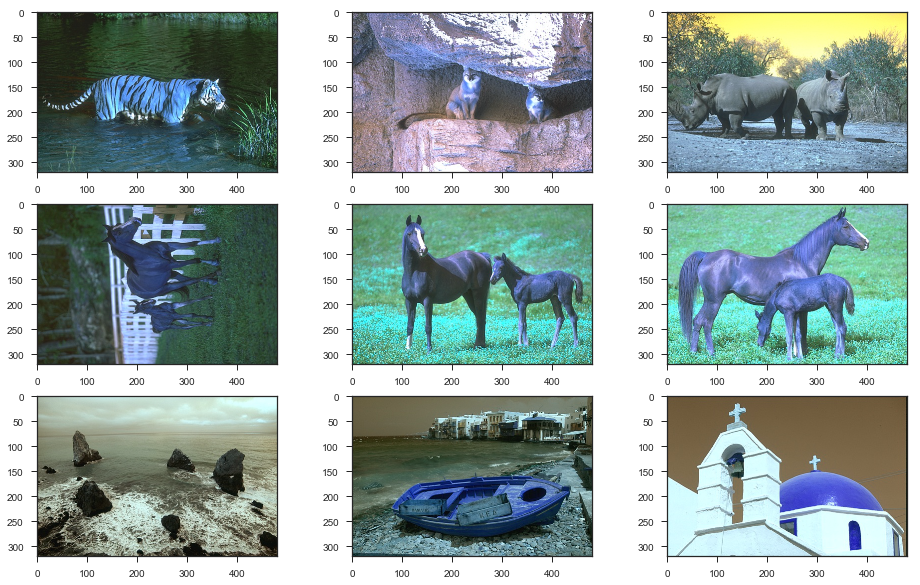

In [4]:
plt.figure(figsize=(16, 10))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i+10])
plt.show()

In [5]:
np.save(DATA_PATH + '/X_train_ori.npy', X_train)
np.save(DATA_PATH + '/X_test_ori.npy', X_test)
np.save(DATA_PATH + '/X_val_ori.npy', X_val)

In [4]:
X_train = np.load(DATA_PATH + '/X_train_ori.npy')
X_test = np.load(DATA_PATH + '/X_test_ori.npy')
X_val = np.load(DATA_PATH + '/X_val_ori.npy')
y_train = np.load(DATA_PATH + '/y_train_ori_0.npy')
y_test = np.load(DATA_PATH + '/y_test_ori_0.npy')
y_val = np.load(DATA_PATH + '/y_val_ori_0.npy')

In [11]:
y_train = y_train.reshape((-1, 320, 480, 1))
y_test = y_test.reshape((-1, 320, 480, 1))
y_val = y_val.reshape((-1, 320, 480, 1))

In [ ]:

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def meanIoU(y_true_batch, y_pred_batch):
    return np.mean(np.asarray([IoU(y_pred_batch, y_true_batch,t) for t in np.arange(0.5, 1, 0.05)])) 

def IoU(y_pred_batch, y_true_batch, threshold):
    return np.mean(np.asarray([pixelAccuracy(y_pred_batch[i], y_true_batch[i],threshold) for i in range(len(y_true_batch))])) 

def pixelAccuracy(y_pred_orig, y_true, threshold):
    y_pred = (y_pred_orig > threshold)   
    return 1.0 * np.sum((y_pred==y_true)*(y_true>0)) /  (np.sum(y_pred>0) + np.sum(y_true>0) - np.sum((y_pred==y_true)*(y_true>0)))

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
        
                      
def focal_loss(y_true, y_pred):
    gamma = 2.
    alpha = .25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [45]:
# bias_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=22)
# Define the optimizer
optimizer = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [46]:
# Build U-Net model
inputs = Input((320, 480, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=optimizer, loss=cross_entropy_balanced)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 320, 480, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 320, 480, 8)  224         lambda_4[0][0]                   
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 320, 480, 8)  584         conv2d_70[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [15]:
from keras.layers import Conv2D, Conv2DTranspose, Input, MaxPooling2D
from keras.layers import Concatenate, Activation
from keras.models import Model
from keras import backend as K
import tensorflow as tf

def side_branch(x, factor):
    x = Conv2D(1, (1, 1), activation=None, padding='same')(x)

    kernel_size = (2*factor, 2*factor)
    x = Conv2DTranspose(1, kernel_size, strides=factor, padding='same', use_bias=False, activation=None)(x)

    return x


def hed():
    # Input
    img_input = Input(shape=(320,480,3), name='input')

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    b1= side_branch(x, 1) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block1_pool')(x) # 240 240 64

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    b2= side_branch(x, 2) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block2_pool')(x) # 120 120 128

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    b3= side_branch(x, 4) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block3_pool')(x) # 60 60 256

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    b4= side_branch(x, 8) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block4_pool')(x) # 30 30 512

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x) # 30 30 512
    b5= side_branch(x, 16) # 480 480 1

    # fuse
    fuse = Concatenate(axis=-1)([b1, b2, b3, b4, b5])
    fuse = Conv2D(1, (1,1), padding='same', use_bias=False, activation=None)(fuse) # 480 480 1

    # outputs
    o1    = Activation('sigmoid', name='o1')(b1)
    o2    = Activation('sigmoid', name='o2')(b2)
    o3    = Activation('sigmoid', name='o3')(b3)
    o4    = Activation('sigmoid', name='o4')(b4)
    o5    = Activation('sigmoid', name='o5')(b5)
    ofuse = Activation('sigmoid', name='ofuse')(fuse)


    # model
    model = Model(inputs=[img_input], outputs=[o1, o2, o3, o4, o5, ofuse])
    # filepath = '/home/congliu/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    # load_weights_from_hdf5_group_by_name(model, filepath)

    model.compile(loss={'o1': cross_entropy_balanced,
                        'o2': cross_entropy_balanced,
                        'o3': cross_entropy_balanced,
                        'o4': cross_entropy_balanced,
                        'o5': cross_entropy_balanced,
                        'ofuse': cross_entropy_balanced,
                        },
                  metrics={'ofuse': ofuse_pixel_error},
                  optimizer='adam')

    return model


def cross_entropy_balanced(y_true, y_pred):
    """
    Implements Equation [2] in https://arxiv.org/pdf/1504.06375.pdf
    Compute edge pixels for each training sample and set as pos_weights to tf.nn.weighted_cross_entropy_with_logits
    """
    # Note: tf.nn.sigmoid_cross_entropy_with_logits expects y_pred is logits, Keras expects probabilities.
    # transform y_pred back to logits
    _epsilon = _to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    y_pred   = tf.clip_by_value(y_pred, _epsilon, 1 - _epsilon)
    y_pred   = tf.log(y_pred/ (1 - y_pred))

    y_true = tf.cast(y_true, tf.float32)

    count_neg = tf.reduce_sum(1. - y_true)
    count_pos = tf.reduce_sum(y_true)

    # Equation [2]
    beta = count_neg / (count_neg + count_pos)

    # Equation [2] divide by 1 - beta
    pos_weight = beta / (1 - beta)

    cost = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=pos_weight)

    # Multiply by 1 - beta
    cost = tf.reduce_mean(cost * (1 - beta))

    # check if image has no edge pixels return 0 else return complete error function
    return tf.where(tf.equal(count_pos, 0.0), 0.0, cost)


def ofuse_pixel_error(y_true, y_pred):
    pred = tf.cast(tf.greater(y_pred, 0.5), tf.int32, name='predictions')
    error = tf.cast(tf.not_equal(pred, tf.cast(y_true, tf.int32)), tf.float32)
    return tf.reduce_mean(error, name='pixel_error')


def _to_tensor(x, dtype):
    """Convert the input `x` to a tensor of type `dtype`.
    # Arguments
    x: An object to be converted (numpy array, list, tensors).
    dtype: The destination type.
    # Returns
    A tensor.
    """
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x


def load_weights_from_hdf5_group_by_name(model, filepath):
    ''' Name-based weight loading '''

    import h5py

    f = h5py.File(filepath, mode='r')

    flattened_layers = model.layers
    layer_names = [n.decode('utf8') for n in f.attrs['layer_names']]

    # Reverse index of layer name to list of layers with name.
    index = {}
    for layer in flattened_layers:
        if layer.name:
            index.setdefault(layer.name, []).append(layer)

    # we batch weight value assignments in a single backend call
    # which provides a speedup in TensorFlow.
    weight_value_tuples = []
    for k, name in enumerate(layer_names):
        g = f[name]
        weight_names = [n.decode('utf8') for n in g.attrs['weight_names']]
        weight_values = [g[weight_name] for weight_name in weight_names]

        for layer in index.get(name, []):
            symbolic_weights = layer.weights
            if len(weight_values) != len(symbolic_weights):
                raise Exception('Layer #' + str(k) +
                                ' (named "' + layer.name +
                                '") expects ' +
                                str(len(symbolic_weights)) +
                                ' weight(s), but the saved weights' +
                                ' have ' + str(len(weight_values)) +
                                ' element(s).')
            # set values
            for i in range(len(weight_values)):
                weight_value_tuples.append((symbolic_weights[i], weight_values[i]))
                K.batch_set_value(weight_value_tuples)

In [47]:
checkpointer = ModelCheckpoint('model-ImageEdge-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=5000, 
                    callbacks=[checkpointer], verbose=2)

Train on 200 samples, validate on 100 samples
Epoch 1/5000


Epoch 00001: val_loss improved from inf to 0.02216, saving model to model-ImageEdge-1.h5


 - 7s - loss: 0.0231 - val_loss: 0.0222


Epoch 2/5000


Epoch 00002: val_loss improved from 0.02216 to 0.02212, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0231 - val_loss: 0.0221


Epoch 3/5000


Epoch 00003: val_loss improved from 0.02212 to 0.02209, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0230 - val_loss: 0.0221


Epoch 4/5000


Epoch 00004: val_loss improved from 0.02209 to 0.02206, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0230 - val_loss: 0.0221


Epoch 5/5000


Epoch 00005: val_loss improved from 0.02206 to 0.02204, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0230 - val_loss: 0.0220


Epoch 6/5000


Epoch 00006: val_loss improved from 0.02204 to 0.02203, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0230 - val_loss: 0.0220


Epoch 7/5000


Epoch 00007: val_loss improved from 0.02203 to 0.02201, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0229 - val_loss: 0.0220


Epoch 8/5000


Epoch 00008: val_loss improved from 0.02201 to 0.02200, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0229 - val_loss: 0.0220


Epoch 9/5000


Epoch 00009: val_loss improved from 0.02200 to 0.02199, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0229 - val_loss: 0.0220


Epoch 10/5000


Epoch 00010: val_loss improved from 0.02199 to 0.02198, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0229 - val_loss: 0.0220


Epoch 11/5000


Epoch 00011: val_loss improved from 0.02198 to 0.02196, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0229 - val_loss: 0.0220


Epoch 12/5000


Epoch 00012: val_loss improved from 0.02196 to 0.02195, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0229 - val_loss: 0.0219


Epoch 13/5000


Epoch 00013: val_loss improved from 0.02195 to 0.02194, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0229 - val_loss: 0.0219


Epoch 14/5000


Epoch 00014: val_loss improved from 0.02194 to 0.02192, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0228 - val_loss: 0.0219


Epoch 15/5000


Epoch 00015: val_loss improved from 0.02192 to 0.02191, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0228 - val_loss: 0.0219


Epoch 16/5000


Epoch 00016: val_loss improved from 0.02191 to 0.02189, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0228 - val_loss: 0.0219


Epoch 17/5000


Epoch 00017: val_loss improved from 0.02189 to 0.02188, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0228 - val_loss: 0.0219


Epoch 18/5000


Epoch 00018: val_loss improved from 0.02188 to 0.02186, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0228 - val_loss: 0.0219


Epoch 19/5000


Epoch 00019: val_loss improved from 0.02186 to 0.02184, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0228 - val_loss: 0.0218


Epoch 20/5000


Epoch 00020: val_loss improved from 0.02184 to 0.02182, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0227 - val_loss: 0.0218


Epoch 21/5000


Epoch 00021: val_loss improved from 0.02182 to 0.02179, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0227 - val_loss: 0.0218


Epoch 22/5000


Epoch 00022: val_loss improved from 0.02179 to 0.02176, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0227 - val_loss: 0.0218


Epoch 23/5000


Epoch 00023: val_loss improved from 0.02176 to 0.02173, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0227 - val_loss: 0.0217


Epoch 24/5000


Epoch 00024: val_loss improved from 0.02173 to 0.02168, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0226 - val_loss: 0.0217


Epoch 25/5000


Epoch 00025: val_loss improved from 0.02168 to 0.02162, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0226 - val_loss: 0.0216


Epoch 26/5000


Epoch 00026: val_loss improved from 0.02162 to 0.02155, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0225 - val_loss: 0.0215


Epoch 27/5000


Epoch 00027: val_loss improved from 0.02155 to 0.02147, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0224 - val_loss: 0.0215


Epoch 28/5000


Epoch 00028: val_loss improved from 0.02147 to 0.02138, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0223 - val_loss: 0.0214


Epoch 29/5000


Epoch 00029: val_loss improved from 0.02138 to 0.02132, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0223 - val_loss: 0.0213


Epoch 30/5000


Epoch 00030: val_loss improved from 0.02132 to 0.02126, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0222 - val_loss: 0.0213


Epoch 31/5000


Epoch 00031: val_loss improved from 0.02126 to 0.02119, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0221 - val_loss: 0.0212


Epoch 32/5000


Epoch 00032: val_loss improved from 0.02119 to 0.02113, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0221 - val_loss: 0.0211


Epoch 33/5000


Epoch 00033: val_loss improved from 0.02113 to 0.02108, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0221 - val_loss: 0.0211


Epoch 34/5000


Epoch 00034: val_loss improved from 0.02108 to 0.02107, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0220 - val_loss: 0.0211


Epoch 35/5000


Epoch 00035: val_loss improved from 0.02107 to 0.02102, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0219 - val_loss: 0.0210


Epoch 36/5000


Epoch 00036: val_loss improved from 0.02102 to 0.02092, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0219 - val_loss: 0.0209


Epoch 37/5000


Epoch 00037: val_loss improved from 0.02092 to 0.02087, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0218 - val_loss: 0.0209


Epoch 38/5000


Epoch 00038: val_loss did not improve
 - 6s - loss: 0.0218 - val_loss: 0.0209


Epoch 39/5000


Epoch 00039: val_loss improved from 0.02087 to 0.02077, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0217 - val_loss: 0.0208


Epoch 40/5000


Epoch 00040: val_loss improved from 0.02077 to 0.02071, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0216 - val_loss: 0.0207


Epoch 41/5000


Epoch 00041: val_loss improved from 0.02071 to 0.02069, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0216 - val_loss: 0.0207


Epoch 42/5000


Epoch 00042: val_loss improved from 0.02069 to 0.02061, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0215 - val_loss: 0.0206


Epoch 43/5000


Epoch 00043: val_loss improved from 0.02061 to 0.02059, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0214 - val_loss: 0.0206


Epoch 44/5000


Epoch 00044: val_loss improved from 0.02059 to 0.02057, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0214 - val_loss: 0.0206


Epoch 45/5000


Epoch 00045: val_loss improved from 0.02057 to 0.02050, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0213 - val_loss: 0.0205


Epoch 46/5000


Epoch 00046: val_loss improved from 0.02050 to 0.02045, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0213 - val_loss: 0.0204


Epoch 47/5000


Epoch 00047: val_loss improved from 0.02045 to 0.02042, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0212 - val_loss: 0.0204


Epoch 48/5000


Epoch 00048: val_loss improved from 0.02042 to 0.02041, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0213 - val_loss: 0.0204


Epoch 49/5000


Epoch 00049: val_loss improved from 0.02041 to 0.02037, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0212 - val_loss: 0.0204


Epoch 50/5000


Epoch 00050: val_loss did not improve
 - 6s - loss: 0.0212 - val_loss: 0.0204


Epoch 51/5000


Epoch 00051: val_loss did not improve
 - 6s - loss: 0.0212 - val_loss: 0.0204


Epoch 52/5000


Epoch 00052: val_loss improved from 0.02037 to 0.02031, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0211 - val_loss: 0.0203


Epoch 53/5000


Epoch 00053: val_loss did not improve
 - 6s - loss: 0.0211 - val_loss: 0.0203


Epoch 54/5000


Epoch 00054: val_loss improved from 0.02031 to 0.02028, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0211 - val_loss: 0.0203


Epoch 55/5000


Epoch 00055: val_loss improved from 0.02028 to 0.02025, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0211 - val_loss: 0.0202


Epoch 56/5000


Epoch 00056: val_loss improved from 0.02025 to 0.02023, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0211 - val_loss: 0.0202


Epoch 57/5000


Epoch 00057: val_loss did not improve
 - 6s - loss: 0.0210 - val_loss: 0.0202


Epoch 58/5000


Epoch 00058: val_loss improved from 0.02023 to 0.02021, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0210 - val_loss: 0.0202


Epoch 59/5000


Epoch 00059: val_loss did not improve
 - 6s - loss: 0.0210 - val_loss: 0.0203


Epoch 60/5000


Epoch 00060: val_loss did not improve
 - 6s - loss: 0.0211 - val_loss: 0.0202


Epoch 61/5000


Epoch 00061: val_loss improved from 0.02021 to 0.02018, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0210 - val_loss: 0.0202


Epoch 62/5000


Epoch 00062: val_loss improved from 0.02018 to 0.02012, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0209 - val_loss: 0.0201


Epoch 63/5000


Epoch 00063: val_loss improved from 0.02012 to 0.02010, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0209 - val_loss: 0.0201


Epoch 64/5000


Epoch 00064: val_loss did not improve
 - 6s - loss: 0.0209 - val_loss: 0.0201


Epoch 65/5000


Epoch 00065: val_loss improved from 0.02010 to 0.02006, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0209 - val_loss: 0.0201


Epoch 66/5000


Epoch 00066: val_loss did not improve
 - 6s - loss: 0.0209 - val_loss: 0.0201


Epoch 67/5000


Epoch 00067: val_loss improved from 0.02006 to 0.02004, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0209 - val_loss: 0.0200


Epoch 68/5000


Epoch 00068: val_loss improved from 0.02004 to 0.02001, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0208 - val_loss: 0.0200


Epoch 69/5000


Epoch 00069: val_loss improved from 0.02001 to 0.01999, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0208 - val_loss: 0.0200


Epoch 70/5000


Epoch 00070: val_loss improved from 0.01999 to 0.01997, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0208 - val_loss: 0.0200


Epoch 71/5000


Epoch 00071: val_loss improved from 0.01997 to 0.01996, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0208 - val_loss: 0.0200


Epoch 72/5000


Epoch 00072: val_loss did not improve
 - 6s - loss: 0.0207 - val_loss: 0.0200


Epoch 73/5000


Epoch 00073: val_loss improved from 0.01996 to 0.01992, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0208 - val_loss: 0.0199


Epoch 74/5000


Epoch 00074: val_loss did not improve
 - 6s - loss: 0.0207 - val_loss: 0.0199


Epoch 75/5000


Epoch 00075: val_loss improved from 0.01992 to 0.01989, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0207 - val_loss: 0.0199


Epoch 76/5000


Epoch 00076: val_loss did not improve
 - 6s - loss: 0.0207 - val_loss: 0.0199


Epoch 77/5000


Epoch 00077: val_loss improved from 0.01989 to 0.01988, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0207 - val_loss: 0.0199


Epoch 78/5000


Epoch 00078: val_loss improved from 0.01988 to 0.01984, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0206 - val_loss: 0.0198


Epoch 79/5000


Epoch 00079: val_loss did not improve
 - 6s - loss: 0.0206 - val_loss: 0.0198


Epoch 80/5000


Epoch 00080: val_loss improved from 0.01984 to 0.01981, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0206 - val_loss: 0.0198


Epoch 81/5000


Epoch 00081: val_loss did not improve
 - 6s - loss: 0.0206 - val_loss: 0.0198


Epoch 82/5000


Epoch 00082: val_loss improved from 0.01981 to 0.01978, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0206 - val_loss: 0.0198


Epoch 83/5000


Epoch 00083: val_loss improved from 0.01978 to 0.01976, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0205 - val_loss: 0.0198


Epoch 84/5000


Epoch 00084: val_loss did not improve
 - 6s - loss: 0.0205 - val_loss: 0.0198


Epoch 85/5000


Epoch 00085: val_loss improved from 0.01976 to 0.01973, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0206 - val_loss: 0.0197


Epoch 86/5000


Epoch 00086: val_loss improved from 0.01973 to 0.01973, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0205 - val_loss: 0.0197


Epoch 87/5000


Epoch 00087: val_loss did not improve
 - 6s - loss: 0.0205 - val_loss: 0.0197


Epoch 88/5000


Epoch 00088: val_loss improved from 0.01973 to 0.01969, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0205 - val_loss: 0.0197


Epoch 89/5000


Epoch 00089: val_loss improved from 0.01969 to 0.01968, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0205 - val_loss: 0.0197


Epoch 90/5000


Epoch 00090: val_loss improved from 0.01968 to 0.01965, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0204 - val_loss: 0.0197


Epoch 91/5000


Epoch 00091: val_loss did not improve
 - 6s - loss: 0.0204 - val_loss: 0.0197


Epoch 92/5000


Epoch 00092: val_loss improved from 0.01965 to 0.01965, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0204 - val_loss: 0.0197


Epoch 93/5000


Epoch 00093: val_loss improved from 0.01965 to 0.01963, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0204 - val_loss: 0.0196


Epoch 94/5000


Epoch 00094: val_loss improved from 0.01963 to 0.01962, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0204 - val_loss: 0.0196


Epoch 95/5000


Epoch 00095: val_loss did not improve
 - 6s - loss: 0.0204 - val_loss: 0.0196


Epoch 96/5000


Epoch 00096: val_loss did not improve
 - 6s - loss: 0.0203 - val_loss: 0.0196


Epoch 97/5000


Epoch 00097: val_loss improved from 0.01962 to 0.01956, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0203 - val_loss: 0.0196


Epoch 98/5000


Epoch 00098: val_loss did not improve
 - 6s - loss: 0.0203 - val_loss: 0.0196


Epoch 99/5000


Epoch 00099: val_loss improved from 0.01956 to 0.01954, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0203 - val_loss: 0.0195


Epoch 100/5000


Epoch 00100: val_loss improved from 0.01954 to 0.01953, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0203 - val_loss: 0.0195


Epoch 101/5000


Epoch 00101: val_loss improved from 0.01953 to 0.01950, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0202 - val_loss: 0.0195


Epoch 102/5000


Epoch 00102: val_loss improved from 0.01950 to 0.01949, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0202 - val_loss: 0.0195


Epoch 103/5000


Epoch 00103: val_loss improved from 0.01949 to 0.01948, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0203 - val_loss: 0.0195


Epoch 104/5000


Epoch 00104: val_loss did not improve
 - 6s - loss: 0.0202 - val_loss: 0.0195


Epoch 105/5000


Epoch 00105: val_loss improved from 0.01948 to 0.01946, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0202 - val_loss: 0.0195


Epoch 106/5000


Epoch 00106: val_loss improved from 0.01946 to 0.01944, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0202 - val_loss: 0.0194


Epoch 107/5000


Epoch 00107: val_loss improved from 0.01944 to 0.01943, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0202 - val_loss: 0.0194


Epoch 108/5000


Epoch 00108: val_loss did not improve
 - 6s - loss: 0.0202 - val_loss: 0.0195


Epoch 109/5000


Epoch 00109: val_loss improved from 0.01943 to 0.01940, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0202 - val_loss: 0.0194


Epoch 110/5000


Epoch 00110: val_loss did not improve
 - 6s - loss: 0.0201 - val_loss: 0.0194


Epoch 111/5000


Epoch 00111: val_loss did not improve
 - 6s - loss: 0.0201 - val_loss: 0.0194


Epoch 112/5000


Epoch 00112: val_loss improved from 0.01940 to 0.01937, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0201 - val_loss: 0.0194


Epoch 113/5000


Epoch 00113: val_loss improved from 0.01937 to 0.01937, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0201 - val_loss: 0.0194


Epoch 114/5000


Epoch 00114: val_loss improved from 0.01937 to 0.01936, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0201 - val_loss: 0.0194


Epoch 115/5000


Epoch 00115: val_loss improved from 0.01936 to 0.01936, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0201 - val_loss: 0.0194


Epoch 116/5000


Epoch 00116: val_loss did not improve
 - 6s - loss: 0.0201 - val_loss: 0.0195


Epoch 117/5000


Epoch 00117: val_loss improved from 0.01936 to 0.01932, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0201 - val_loss: 0.0193


Epoch 118/5000


Epoch 00118: val_loss improved from 0.01932 to 0.01931, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0201 - val_loss: 0.0193


Epoch 119/5000


Epoch 00119: val_loss improved from 0.01931 to 0.01929, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0200 - val_loss: 0.0193


Epoch 120/5000


Epoch 00120: val_loss did not improve
 - 6s - loss: 0.0200 - val_loss: 0.0193


Epoch 121/5000


Epoch 00121: val_loss did not improve
 - 6s - loss: 0.0200 - val_loss: 0.0193


Epoch 122/5000


Epoch 00122: val_loss did not improve
 - 6s - loss: 0.0200 - val_loss: 0.0193


Epoch 123/5000


Epoch 00123: val_loss improved from 0.01929 to 0.01929, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0200 - val_loss: 0.0193


Epoch 124/5000


Epoch 00124: val_loss improved from 0.01929 to 0.01929, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0200 - val_loss: 0.0193


Epoch 125/5000


Epoch 00125: val_loss improved from 0.01929 to 0.01923, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0200 - val_loss: 0.0192


Epoch 126/5000


Epoch 00126: val_loss improved from 0.01923 to 0.01922, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0199 - val_loss: 0.0192


Epoch 127/5000


Epoch 00127: val_loss did not improve
 - 6s - loss: 0.0199 - val_loss: 0.0193


Epoch 128/5000


Epoch 00128: val_loss did not improve
 - 6s - loss: 0.0199 - val_loss: 0.0192


Epoch 129/5000


Epoch 00129: val_loss improved from 0.01922 to 0.01920, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0200 - val_loss: 0.0192


Epoch 130/5000


Epoch 00130: val_loss improved from 0.01920 to 0.01919, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0199 - val_loss: 0.0192


Epoch 131/5000


Epoch 00131: val_loss improved from 0.01919 to 0.01917, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0199 - val_loss: 0.0192


Epoch 132/5000


Epoch 00132: val_loss did not improve
 - 6s - loss: 0.0199 - val_loss: 0.0192


Epoch 133/5000


Epoch 00133: val_loss improved from 0.01917 to 0.01915, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0198 - val_loss: 0.0191


Epoch 134/5000


Epoch 00134: val_loss improved from 0.01915 to 0.01914, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0199 - val_loss: 0.0191


Epoch 135/5000


Epoch 00135: val_loss improved from 0.01914 to 0.01914, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0198 - val_loss: 0.0191


Epoch 136/5000


Epoch 00136: val_loss improved from 0.01914 to 0.01912, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0198 - val_loss: 0.0191


Epoch 137/5000


Epoch 00137: val_loss did not improve
 - 6s - loss: 0.0198 - val_loss: 0.0191


Epoch 138/5000


Epoch 00138: val_loss improved from 0.01912 to 0.01912, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0198 - val_loss: 0.0191


Epoch 139/5000


Epoch 00139: val_loss improved from 0.01912 to 0.01911, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0198 - val_loss: 0.0191


Epoch 140/5000


Epoch 00140: val_loss improved from 0.01911 to 0.01909, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0197 - val_loss: 0.0191


Epoch 141/5000


Epoch 00141: val_loss did not improve
 - 6s - loss: 0.0198 - val_loss: 0.0191


Epoch 142/5000


Epoch 00142: val_loss improved from 0.01909 to 0.01907, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0197 - val_loss: 0.0191


Epoch 143/5000


Epoch 00143: val_loss improved from 0.01907 to 0.01905, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0197 - val_loss: 0.0191


Epoch 144/5000


Epoch 00144: val_loss improved from 0.01905 to 0.01904, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0197 - val_loss: 0.0190


Epoch 145/5000


Epoch 00145: val_loss improved from 0.01904 to 0.01903, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0197 - val_loss: 0.0190


Epoch 146/5000


Epoch 00146: val_loss did not improve
 - 6s - loss: 0.0197 - val_loss: 0.0190


Epoch 147/5000


Epoch 00147: val_loss improved from 0.01903 to 0.01901, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0197 - val_loss: 0.0190


Epoch 148/5000


Epoch 00148: val_loss improved from 0.01901 to 0.01900, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0197 - val_loss: 0.0190


Epoch 149/5000


Epoch 00149: val_loss improved from 0.01900 to 0.01900, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0196 - val_loss: 0.0190


Epoch 150/5000


Epoch 00150: val_loss improved from 0.01900 to 0.01898, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0196 - val_loss: 0.0190


Epoch 151/5000


Epoch 00151: val_loss improved from 0.01898 to 0.01898, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0197 - val_loss: 0.0190


Epoch 152/5000


Epoch 00152: val_loss improved from 0.01898 to 0.01896, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0197 - val_loss: 0.0190


Epoch 153/5000


Epoch 00153: val_loss improved from 0.01896 to 0.01896, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0196 - val_loss: 0.0190


Epoch 154/5000


Epoch 00154: val_loss improved from 0.01896 to 0.01896, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0196 - val_loss: 0.0190


Epoch 155/5000


Epoch 00155: val_loss improved from 0.01896 to 0.01895, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0196 - val_loss: 0.0189


Epoch 156/5000


Epoch 00156: val_loss improved from 0.01895 to 0.01893, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0196 - val_loss: 0.0189


Epoch 157/5000


Epoch 00157: val_loss improved from 0.01893 to 0.01893, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0196 - val_loss: 0.0189


Epoch 158/5000


Epoch 00158: val_loss improved from 0.01893 to 0.01891, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0195 - val_loss: 0.0189


Epoch 159/5000


Epoch 00159: val_loss improved from 0.01891 to 0.01890, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0195 - val_loss: 0.0189


Epoch 160/5000


Epoch 00160: val_loss did not improve
 - 6s - loss: 0.0196 - val_loss: 0.0190


Epoch 161/5000


Epoch 00161: val_loss improved from 0.01890 to 0.01889, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0195 - val_loss: 0.0189


Epoch 162/5000


Epoch 00162: val_loss improved from 0.01889 to 0.01887, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0195 - val_loss: 0.0189


Epoch 163/5000


Epoch 00163: val_loss did not improve
 - 6s - loss: 0.0195 - val_loss: 0.0189


Epoch 164/5000


Epoch 00164: val_loss improved from 0.01887 to 0.01886, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0195 - val_loss: 0.0189


Epoch 165/5000


Epoch 00165: val_loss improved from 0.01886 to 0.01885, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0195 - val_loss: 0.0188


Epoch 166/5000


Epoch 00166: val_loss improved from 0.01885 to 0.01883, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0195 - val_loss: 0.0188


Epoch 167/5000


Epoch 00167: val_loss did not improve
 - 6s - loss: 0.0195 - val_loss: 0.0189


Epoch 168/5000


Epoch 00168: val_loss improved from 0.01883 to 0.01882, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0194 - val_loss: 0.0188


Epoch 169/5000


Epoch 00169: val_loss improved from 0.01882 to 0.01881, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0194 - val_loss: 0.0188


Epoch 170/5000


Epoch 00170: val_loss improved from 0.01881 to 0.01880, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0194 - val_loss: 0.0188


Epoch 171/5000


Epoch 00171: val_loss improved from 0.01880 to 0.01879, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0194 - val_loss: 0.0188


Epoch 172/5000


Epoch 00172: val_loss did not improve
 - 6s - loss: 0.0195 - val_loss: 0.0188


Epoch 173/5000


Epoch 00173: val_loss improved from 0.01879 to 0.01878, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0194 - val_loss: 0.0188


Epoch 174/5000


Epoch 00174: val_loss improved from 0.01878 to 0.01878, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0194 - val_loss: 0.0188


Epoch 175/5000


Epoch 00175: val_loss improved from 0.01878 to 0.01877, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0194 - val_loss: 0.0188


Epoch 176/5000


Epoch 00176: val_loss did not improve
 - 6s - loss: 0.0194 - val_loss: 0.0188


Epoch 177/5000


Epoch 00177: val_loss improved from 0.01877 to 0.01875, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0194 - val_loss: 0.0187


Epoch 178/5000


Epoch 00178: val_loss did not improve
 - 6s - loss: 0.0194 - val_loss: 0.0188


Epoch 179/5000


Epoch 00179: val_loss improved from 0.01875 to 0.01873, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0193 - val_loss: 0.0187


Epoch 180/5000


Epoch 00180: val_loss improved from 0.01873 to 0.01871, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0193 - val_loss: 0.0187


Epoch 181/5000


Epoch 00181: val_loss did not improve
 - 6s - loss: 0.0193 - val_loss: 0.0188


Epoch 182/5000


Epoch 00182: val_loss improved from 0.01871 to 0.01870, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0193 - val_loss: 0.0187


Epoch 183/5000


Epoch 00183: val_loss improved from 0.01870 to 0.01867, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0193 - val_loss: 0.0187


Epoch 184/5000


Epoch 00184: val_loss did not improve
 - 6s - loss: 0.0193 - val_loss: 0.0187


Epoch 185/5000


Epoch 00185: val_loss did not improve
 - 6s - loss: 0.0193 - val_loss: 0.0189


Epoch 186/5000


Epoch 00186: val_loss did not improve
 - 6s - loss: 0.0193 - val_loss: 0.0187


Epoch 187/5000


Epoch 00187: val_loss improved from 0.01867 to 0.01865, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0193 - val_loss: 0.0186


Epoch 188/5000


Epoch 00188: val_loss did not improve
 - 6s - loss: 0.0192 - val_loss: 0.0187


Epoch 189/5000


Epoch 00189: val_loss improved from 0.01865 to 0.01862, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0192 - val_loss: 0.0186


Epoch 190/5000


Epoch 00190: val_loss improved from 0.01862 to 0.01861, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0192 - val_loss: 0.0186


Epoch 191/5000


Epoch 00191: val_loss did not improve
 - 6s - loss: 0.0192 - val_loss: 0.0187


Epoch 192/5000


Epoch 00192: val_loss did not improve
 - 6s - loss: 0.0192 - val_loss: 0.0186


Epoch 193/5000


Epoch 00193: val_loss improved from 0.01861 to 0.01858, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0192 - val_loss: 0.0186


Epoch 194/5000


Epoch 00194: val_loss did not improve
 - 6s - loss: 0.0192 - val_loss: 0.0186


Epoch 195/5000


Epoch 00195: val_loss did not improve
 - 6s - loss: 0.0192 - val_loss: 0.0186


Epoch 196/5000


Epoch 00196: val_loss improved from 0.01858 to 0.01855, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0192 - val_loss: 0.0186


Epoch 197/5000


Epoch 00197: val_loss did not improve
 - 6s - loss: 0.0191 - val_loss: 0.0187


Epoch 198/5000


Epoch 00198: val_loss improved from 0.01855 to 0.01855, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0192 - val_loss: 0.0186


Epoch 199/5000


Epoch 00199: val_loss improved from 0.01855 to 0.01853, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0191 - val_loss: 0.0185


Epoch 200/5000


Epoch 00200: val_loss improved from 0.01853 to 0.01852, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0191 - val_loss: 0.0185


Epoch 201/5000


Epoch 00201: val_loss did not improve
 - 6s - loss: 0.0191 - val_loss: 0.0185


Epoch 202/5000


Epoch 00202: val_loss improved from 0.01852 to 0.01850, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0191 - val_loss: 0.0185


Epoch 203/5000


Epoch 00203: val_loss did not improve
 - 6s - loss: 0.0190 - val_loss: 0.0185


Epoch 204/5000


Epoch 00204: val_loss improved from 0.01850 to 0.01848, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0190 - val_loss: 0.0185


Epoch 205/5000


Epoch 00205: val_loss did not improve
 - 6s - loss: 0.0190 - val_loss: 0.0185


Epoch 206/5000


Epoch 00206: val_loss improved from 0.01848 to 0.01845, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0190 - val_loss: 0.0185


Epoch 207/5000


Epoch 00207: val_loss did not improve
 - 6s - loss: 0.0190 - val_loss: 0.0185


Epoch 208/5000


Epoch 00208: val_loss did not improve
 - 6s - loss: 0.0190 - val_loss: 0.0185


Epoch 209/5000


Epoch 00209: val_loss improved from 0.01845 to 0.01844, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0190 - val_loss: 0.0184


Epoch 210/5000


Epoch 00210: val_loss improved from 0.01844 to 0.01841, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0190 - val_loss: 0.0184


Epoch 211/5000


Epoch 00211: val_loss improved from 0.01841 to 0.01841, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0190 - val_loss: 0.0184


Epoch 212/5000


Epoch 00212: val_loss improved from 0.01841 to 0.01839, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0190 - val_loss: 0.0184


Epoch 213/5000


Epoch 00213: val_loss improved from 0.01839 to 0.01838, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0189 - val_loss: 0.0184


Epoch 214/5000


Epoch 00214: val_loss did not improve
 - 6s - loss: 0.0190 - val_loss: 0.0184


Epoch 215/5000


Epoch 00215: val_loss improved from 0.01838 to 0.01837, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0189 - val_loss: 0.0184


Epoch 216/5000


Epoch 00216: val_loss improved from 0.01837 to 0.01836, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0189 - val_loss: 0.0184


Epoch 217/5000


Epoch 00217: val_loss improved from 0.01836 to 0.01835, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0189 - val_loss: 0.0183


Epoch 218/5000


Epoch 00218: val_loss did not improve
 - 6s - loss: 0.0189 - val_loss: 0.0184


Epoch 219/5000


Epoch 00219: val_loss did not improve
 - 6s - loss: 0.0188 - val_loss: 0.0184


Epoch 220/5000


Epoch 00220: val_loss improved from 0.01835 to 0.01831, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0188 - val_loss: 0.0183


Epoch 221/5000


Epoch 00221: val_loss did not improve
 - 6s - loss: 0.0188 - val_loss: 0.0183


Epoch 222/5000


Epoch 00222: val_loss improved from 0.01831 to 0.01829, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0188 - val_loss: 0.0183


Epoch 223/5000


Epoch 00223: val_loss improved from 0.01829 to 0.01828, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0188 - val_loss: 0.0183


Epoch 224/5000


Epoch 00224: val_loss improved from 0.01828 to 0.01827, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0187 - val_loss: 0.0183


Epoch 225/5000


Epoch 00225: val_loss did not improve
 - 6s - loss: 0.0187 - val_loss: 0.0183


Epoch 226/5000


Epoch 00226: val_loss improved from 0.01827 to 0.01824, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0187 - val_loss: 0.0182


Epoch 227/5000


Epoch 00227: val_loss did not improve
 - 6s - loss: 0.0187 - val_loss: 0.0183


Epoch 228/5000


Epoch 00228: val_loss did not improve
 - 6s - loss: 0.0187 - val_loss: 0.0183


Epoch 229/5000


Epoch 00229: val_loss improved from 0.01824 to 0.01821, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0187 - val_loss: 0.0182


Epoch 230/5000


Epoch 00230: val_loss improved from 0.01821 to 0.01819, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0188 - val_loss: 0.0182


Epoch 231/5000


Epoch 00231: val_loss did not improve
 - 6s - loss: 0.0187 - val_loss: 0.0183


Epoch 232/5000


Epoch 00232: val_loss improved from 0.01819 to 0.01818, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0187 - val_loss: 0.0182


Epoch 233/5000


Epoch 00233: val_loss improved from 0.01818 to 0.01816, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0187 - val_loss: 0.0182


Epoch 234/5000


Epoch 00234: val_loss improved from 0.01816 to 0.01815, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0186 - val_loss: 0.0182


Epoch 235/5000


Epoch 00235: val_loss improved from 0.01815 to 0.01815, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0186 - val_loss: 0.0182


Epoch 236/5000


Epoch 00236: val_loss improved from 0.01815 to 0.01814, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0186 - val_loss: 0.0181


Epoch 237/5000


Epoch 00237: val_loss improved from 0.01814 to 0.01812, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0186 - val_loss: 0.0181


Epoch 238/5000


Epoch 00238: val_loss did not improve
 - 6s - loss: 0.0186 - val_loss: 0.0181


Epoch 239/5000


Epoch 00239: val_loss improved from 0.01812 to 0.01810, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0186 - val_loss: 0.0181


Epoch 240/5000


Epoch 00240: val_loss improved from 0.01810 to 0.01810, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0185 - val_loss: 0.0181


Epoch 241/5000


Epoch 00241: val_loss did not improve
 - 6s - loss: 0.0185 - val_loss: 0.0181


Epoch 242/5000


Epoch 00242: val_loss improved from 0.01810 to 0.01806, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0185 - val_loss: 0.0181


Epoch 243/5000


Epoch 00243: val_loss improved from 0.01806 to 0.01805, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0185 - val_loss: 0.0180


Epoch 244/5000


Epoch 00244: val_loss improved from 0.01805 to 0.01803, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0185 - val_loss: 0.0180


Epoch 245/5000


Epoch 00245: val_loss did not improve
 - 6s - loss: 0.0185 - val_loss: 0.0180


Epoch 246/5000


Epoch 00246: val_loss did not improve
 - 6s - loss: 0.0185 - val_loss: 0.0182


Epoch 247/5000


Epoch 00247: val_loss improved from 0.01803 to 0.01803, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0185 - val_loss: 0.0180


Epoch 248/5000


Epoch 00248: val_loss improved from 0.01803 to 0.01799, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0184 - val_loss: 0.0180


Epoch 249/5000


Epoch 00249: val_loss did not improve
 - 6s - loss: 0.0184 - val_loss: 0.0180


Epoch 250/5000


Epoch 00250: val_loss improved from 0.01799 to 0.01798, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0184 - val_loss: 0.0180


Epoch 251/5000


Epoch 00251: val_loss improved from 0.01798 to 0.01796, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0184 - val_loss: 0.0180


Epoch 252/5000


Epoch 00252: val_loss did not improve
 - 6s - loss: 0.0184 - val_loss: 0.0181


Epoch 253/5000


Epoch 00253: val_loss improved from 0.01796 to 0.01793, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0184 - val_loss: 0.0179


Epoch 254/5000


Epoch 00254: val_loss improved from 0.01793 to 0.01792, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0183 - val_loss: 0.0179


Epoch 255/5000


Epoch 00255: val_loss improved from 0.01792 to 0.01790, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0183 - val_loss: 0.0179


Epoch 256/5000


Epoch 00256: val_loss did not improve
 - 6s - loss: 0.0183 - val_loss: 0.0179


Epoch 257/5000


Epoch 00257: val_loss improved from 0.01790 to 0.01786, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0183 - val_loss: 0.0179


Epoch 258/5000


Epoch 00258: val_loss did not improve
 - 6s - loss: 0.0183 - val_loss: 0.0179


Epoch 259/5000


Epoch 00259: val_loss improved from 0.01786 to 0.01786, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0183 - val_loss: 0.0179


Epoch 260/5000


Epoch 00260: val_loss improved from 0.01786 to 0.01785, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0182 - val_loss: 0.0179


Epoch 261/5000


Epoch 00261: val_loss improved from 0.01785 to 0.01785, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0182 - val_loss: 0.0178


Epoch 262/5000


Epoch 00262: val_loss improved from 0.01785 to 0.01782, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0182 - val_loss: 0.0178


Epoch 263/5000


Epoch 00263: val_loss improved from 0.01782 to 0.01780, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0182 - val_loss: 0.0178


Epoch 264/5000


Epoch 00264: val_loss did not improve
 - 6s - loss: 0.0181 - val_loss: 0.0178


Epoch 265/5000


Epoch 00265: val_loss did not improve
 - 6s - loss: 0.0182 - val_loss: 0.0179


Epoch 266/5000


Epoch 00266: val_loss improved from 0.01780 to 0.01776, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0181 - val_loss: 0.0178


Epoch 267/5000


Epoch 00267: val_loss did not improve
 - 6s - loss: 0.0181 - val_loss: 0.0178


Epoch 268/5000


Epoch 00268: val_loss improved from 0.01776 to 0.01774, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0181 - val_loss: 0.0177


Epoch 269/5000


Epoch 00269: val_loss improved from 0.01774 to 0.01771, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0181 - val_loss: 0.0177


Epoch 270/5000


Epoch 00270: val_loss did not improve
 - 6s - loss: 0.0181 - val_loss: 0.0177


Epoch 271/5000


Epoch 00271: val_loss improved from 0.01771 to 0.01770, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0180 - val_loss: 0.0177


Epoch 272/5000


Epoch 00272: val_loss improved from 0.01770 to 0.01768, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0181 - val_loss: 0.0177


Epoch 273/5000


Epoch 00273: val_loss improved from 0.01768 to 0.01766, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0180 - val_loss: 0.0177


Epoch 274/5000


Epoch 00274: val_loss improved from 0.01766 to 0.01763, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0180 - val_loss: 0.0176


Epoch 275/5000


Epoch 00275: val_loss did not improve
 - 6s - loss: 0.0180 - val_loss: 0.0176


Epoch 276/5000


Epoch 00276: val_loss improved from 0.01763 to 0.01760, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0180 - val_loss: 0.0176


Epoch 277/5000


Epoch 00277: val_loss did not improve
 - 6s - loss: 0.0179 - val_loss: 0.0177


Epoch 278/5000


Epoch 00278: val_loss improved from 0.01760 to 0.01758, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0179 - val_loss: 0.0176


Epoch 279/5000


Epoch 00279: val_loss improved from 0.01758 to 0.01757, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0179 - val_loss: 0.0176


Epoch 280/5000


Epoch 00280: val_loss improved from 0.01757 to 0.01756, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0178 - val_loss: 0.0176


Epoch 281/5000


Epoch 00281: val_loss improved from 0.01756 to 0.01754, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0178 - val_loss: 0.0175


Epoch 282/5000


Epoch 00282: val_loss improved from 0.01754 to 0.01753, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0179 - val_loss: 0.0175


Epoch 283/5000


Epoch 00283: val_loss did not improve
 - 6s - loss: 0.0178 - val_loss: 0.0175


Epoch 284/5000


Epoch 00284: val_loss did not improve
 - 6s - loss: 0.0178 - val_loss: 0.0175


Epoch 285/5000


Epoch 00285: val_loss improved from 0.01753 to 0.01748, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0177 - val_loss: 0.0175


Epoch 286/5000


Epoch 00286: val_loss improved from 0.01748 to 0.01746, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0177 - val_loss: 0.0175


Epoch 287/5000


Epoch 00287: val_loss did not improve
 - 6s - loss: 0.0177 - val_loss: 0.0175


Epoch 288/5000


Epoch 00288: val_loss improved from 0.01746 to 0.01743, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0177 - val_loss: 0.0174


Epoch 289/5000


Epoch 00289: val_loss did not improve
 - 6s - loss: 0.0177 - val_loss: 0.0174


Epoch 290/5000


Epoch 00290: val_loss did not improve
 - 6s - loss: 0.0177 - val_loss: 0.0175


Epoch 291/5000


Epoch 00291: val_loss did not improve
 - 6s - loss: 0.0177 - val_loss: 0.0174


Epoch 292/5000


Epoch 00292: val_loss improved from 0.01743 to 0.01738, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0177 - val_loss: 0.0174


Epoch 293/5000


Epoch 00293: val_loss improved from 0.01738 to 0.01735, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0177 - val_loss: 0.0173


Epoch 294/5000


Epoch 00294: val_loss did not improve
 - 6s - loss: 0.0176 - val_loss: 0.0174


Epoch 295/5000


Epoch 00295: val_loss did not improve
 - 6s - loss: 0.0176 - val_loss: 0.0174


Epoch 296/5000


Epoch 00296: val_loss improved from 0.01735 to 0.01731, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0176 - val_loss: 0.0173


Epoch 297/5000


Epoch 00297: val_loss did not improve
 - 6s - loss: 0.0177 - val_loss: 0.0174


Epoch 298/5000


Epoch 00298: val_loss did not improve
 - 6s - loss: 0.0175 - val_loss: 0.0174


Epoch 299/5000


Epoch 00299: val_loss improved from 0.01731 to 0.01728, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0175 - val_loss: 0.0173


Epoch 300/5000


Epoch 00300: val_loss improved from 0.01728 to 0.01724, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0175 - val_loss: 0.0172


Epoch 301/5000


Epoch 00301: val_loss did not improve
 - 6s - loss: 0.0175 - val_loss: 0.0173


Epoch 302/5000


Epoch 00302: val_loss did not improve
 - 6s - loss: 0.0175 - val_loss: 0.0173


Epoch 303/5000


Epoch 00303: val_loss improved from 0.01724 to 0.01723, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0174 - val_loss: 0.0172


Epoch 304/5000


Epoch 00304: val_loss improved from 0.01723 to 0.01721, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0174 - val_loss: 0.0172


Epoch 305/5000


Epoch 00305: val_loss did not improve
 - 6s - loss: 0.0174 - val_loss: 0.0172


Epoch 306/5000


Epoch 00306: val_loss improved from 0.01721 to 0.01721, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0174 - val_loss: 0.0172


Epoch 307/5000


Epoch 00307: val_loss improved from 0.01721 to 0.01715, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0173 - val_loss: 0.0172


Epoch 308/5000


Epoch 00308: val_loss improved from 0.01715 to 0.01713, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0173 - val_loss: 0.0171


Epoch 309/5000


Epoch 00309: val_loss improved from 0.01713 to 0.01712, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0173 - val_loss: 0.0171


Epoch 310/5000


Epoch 00310: val_loss did not improve
 - 6s - loss: 0.0172 - val_loss: 0.0171


Epoch 311/5000


Epoch 00311: val_loss improved from 0.01712 to 0.01710, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0173 - val_loss: 0.0171


Epoch 312/5000


Epoch 00312: val_loss improved from 0.01710 to 0.01709, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0172 - val_loss: 0.0171


Epoch 313/5000


Epoch 00313: val_loss improved from 0.01709 to 0.01706, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0172 - val_loss: 0.0171


Epoch 314/5000


Epoch 00314: val_loss did not improve
 - 6s - loss: 0.0172 - val_loss: 0.0171


Epoch 315/5000


Epoch 00315: val_loss did not improve
 - 6s - loss: 0.0172 - val_loss: 0.0171


Epoch 316/5000


Epoch 00316: val_loss improved from 0.01706 to 0.01701, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0172 - val_loss: 0.0170


Epoch 317/5000


Epoch 00317: val_loss improved from 0.01701 to 0.01699, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0171 - val_loss: 0.0170


Epoch 318/5000


Epoch 00318: val_loss improved from 0.01699 to 0.01698, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0171 - val_loss: 0.0170


Epoch 319/5000


Epoch 00319: val_loss improved from 0.01698 to 0.01697, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0171 - val_loss: 0.0170


Epoch 320/5000


Epoch 00320: val_loss improved from 0.01697 to 0.01696, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0171 - val_loss: 0.0170


Epoch 321/5000


Epoch 00321: val_loss improved from 0.01696 to 0.01693, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0170 - val_loss: 0.0169


Epoch 322/5000


Epoch 00322: val_loss improved from 0.01693 to 0.01692, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0171 - val_loss: 0.0169


Epoch 323/5000


Epoch 00323: val_loss did not improve
 - 6s - loss: 0.0170 - val_loss: 0.0169


Epoch 324/5000


Epoch 00324: val_loss did not improve
 - 6s - loss: 0.0170 - val_loss: 0.0169


Epoch 325/5000


Epoch 00325: val_loss improved from 0.01692 to 0.01688, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0169 - val_loss: 0.0169


Epoch 326/5000


Epoch 00326: val_loss improved from 0.01688 to 0.01687, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0169 - val_loss: 0.0169


Epoch 327/5000


Epoch 00327: val_loss did not improve
 - 6s - loss: 0.0169 - val_loss: 0.0169


Epoch 328/5000


Epoch 00328: val_loss did not improve
 - 6s - loss: 0.0169 - val_loss: 0.0169


Epoch 329/5000


Epoch 00329: val_loss improved from 0.01687 to 0.01682, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0169 - val_loss: 0.0168


Epoch 330/5000


Epoch 00330: val_loss did not improve
 - 6s - loss: 0.0168 - val_loss: 0.0169


Epoch 331/5000


Epoch 00331: val_loss did not improve
 - 6s - loss: 0.0169 - val_loss: 0.0169


Epoch 332/5000


Epoch 00332: val_loss did not improve
 - 6s - loss: 0.0169 - val_loss: 0.0169


Epoch 333/5000


Epoch 00333: val_loss improved from 0.01682 to 0.01678, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0168 - val_loss: 0.0168


Epoch 334/5000


Epoch 00334: val_loss did not improve
 - 6s - loss: 0.0168 - val_loss: 0.0168


Epoch 335/5000


Epoch 00335: val_loss did not improve
 - 6s - loss: 0.0168 - val_loss: 0.0169


Epoch 336/5000


Epoch 00336: val_loss did not improve
 - 6s - loss: 0.0167 - val_loss: 0.0168


Epoch 337/5000


Epoch 00337: val_loss improved from 0.01678 to 0.01677, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0167 - val_loss: 0.0168


Epoch 338/5000


Epoch 00338: val_loss improved from 0.01677 to 0.01671, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0167 - val_loss: 0.0167


Epoch 339/5000


Epoch 00339: val_loss did not improve
 - 6s - loss: 0.0166 - val_loss: 0.0167


Epoch 340/5000


Epoch 00340: val_loss did not improve
 - 6s - loss: 0.0167 - val_loss: 0.0167


Epoch 341/5000


Epoch 00341: val_loss improved from 0.01671 to 0.01668, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0166 - val_loss: 0.0167


Epoch 342/5000


Epoch 00342: val_loss improved from 0.01668 to 0.01668, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0166 - val_loss: 0.0167


Epoch 343/5000


Epoch 00343: val_loss improved from 0.01668 to 0.01664, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0166 - val_loss: 0.0166


Epoch 344/5000


Epoch 00344: val_loss did not improve
 - 6s - loss: 0.0166 - val_loss: 0.0167


Epoch 345/5000


Epoch 00345: val_loss did not improve
 - 6s - loss: 0.0166 - val_loss: 0.0166


Epoch 346/5000


Epoch 00346: val_loss improved from 0.01664 to 0.01661, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0166 - val_loss: 0.0166


Epoch 347/5000


Epoch 00347: val_loss improved from 0.01661 to 0.01659, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0167 - val_loss: 0.0166


Epoch 348/5000


Epoch 00348: val_loss did not improve
 - 6s - loss: 0.0166 - val_loss: 0.0169


Epoch 349/5000


Epoch 00349: val_loss did not improve
 - 6s - loss: 0.0165 - val_loss: 0.0166


Epoch 350/5000


Epoch 00350: val_loss did not improve
 - 6s - loss: 0.0165 - val_loss: 0.0166


Epoch 351/5000


Epoch 00351: val_loss improved from 0.01659 to 0.01656, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0165 - val_loss: 0.0166


Epoch 352/5000


Epoch 00352: val_loss improved from 0.01656 to 0.01655, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0165 - val_loss: 0.0166


Epoch 353/5000


Epoch 00353: val_loss improved from 0.01655 to 0.01654, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0165 - val_loss: 0.0165


Epoch 354/5000


Epoch 00354: val_loss did not improve
 - 6s - loss: 0.0165 - val_loss: 0.0166


Epoch 355/5000


Epoch 00355: val_loss did not improve
 - 6s - loss: 0.0164 - val_loss: 0.0166


Epoch 356/5000


Epoch 00356: val_loss improved from 0.01654 to 0.01650, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0164 - val_loss: 0.0165


Epoch 357/5000


Epoch 00357: val_loss did not improve
 - 6s - loss: 0.0164 - val_loss: 0.0168


Epoch 358/5000


Epoch 00358: val_loss did not improve
 - 6s - loss: 0.0164 - val_loss: 0.0167


Epoch 359/5000


Epoch 00359: val_loss did not improve
 - 6s - loss: 0.0165 - val_loss: 0.0166


Epoch 360/5000


Epoch 00360: val_loss improved from 0.01650 to 0.01647, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0163 - val_loss: 0.0165


Epoch 361/5000


Epoch 00361: val_loss did not improve
 - 6s - loss: 0.0163 - val_loss: 0.0165


Epoch 362/5000


Epoch 00362: val_loss did not improve
 - 6s - loss: 0.0164 - val_loss: 0.0165


Epoch 363/5000


Epoch 00363: val_loss did not improve
 - 6s - loss: 0.0163 - val_loss: 0.0165


Epoch 364/5000


Epoch 00364: val_loss improved from 0.01647 to 0.01642, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0163 - val_loss: 0.0164


Epoch 365/5000


Epoch 00365: val_loss improved from 0.01642 to 0.01641, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0162 - val_loss: 0.0164


Epoch 366/5000


Epoch 00366: val_loss improved from 0.01641 to 0.01641, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0162 - val_loss: 0.0164


Epoch 367/5000


Epoch 00367: val_loss did not improve
 - 6s - loss: 0.0162 - val_loss: 0.0164


Epoch 368/5000


Epoch 00368: val_loss improved from 0.01641 to 0.01638, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0162 - val_loss: 0.0164


Epoch 369/5000


Epoch 00369: val_loss improved from 0.01638 to 0.01636, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0162 - val_loss: 0.0164


Epoch 370/5000


Epoch 00370: val_loss improved from 0.01636 to 0.01635, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0161 - val_loss: 0.0164


Epoch 371/5000


Epoch 00371: val_loss did not improve
 - 6s - loss: 0.0161 - val_loss: 0.0164


Epoch 372/5000


Epoch 00372: val_loss did not improve
 - 6s - loss: 0.0161 - val_loss: 0.0164


Epoch 373/5000


Epoch 00373: val_loss did not improve
 - 6s - loss: 0.0162 - val_loss: 0.0164


Epoch 374/5000


Epoch 00374: val_loss improved from 0.01635 to 0.01635, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0161 - val_loss: 0.0163


Epoch 375/5000


Epoch 00375: val_loss improved from 0.01635 to 0.01634, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0160 - val_loss: 0.0163


Epoch 376/5000


Epoch 00376: val_loss did not improve
 - 6s - loss: 0.0161 - val_loss: 0.0164


Epoch 377/5000


Epoch 00377: val_loss did not improve
 - 6s - loss: 0.0161 - val_loss: 0.0164


Epoch 378/5000


Epoch 00378: val_loss did not improve
 - 6s - loss: 0.0161 - val_loss: 0.0165


Epoch 379/5000


Epoch 00379: val_loss did not improve
 - 6s - loss: 0.0160 - val_loss: 0.0164


Epoch 380/5000


Epoch 00380: val_loss did not improve
 - 6s - loss: 0.0160 - val_loss: 0.0163


Epoch 381/5000


Epoch 00381: val_loss improved from 0.01634 to 0.01630, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0159 - val_loss: 0.0163


Epoch 382/5000


Epoch 00382: val_loss improved from 0.01630 to 0.01628, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0160 - val_loss: 0.0163


Epoch 383/5000


Epoch 00383: val_loss did not improve
 - 6s - loss: 0.0160 - val_loss: 0.0164


Epoch 384/5000


Epoch 00384: val_loss improved from 0.01628 to 0.01627, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0159 - val_loss: 0.0163


Epoch 385/5000


Epoch 00385: val_loss improved from 0.01627 to 0.01625, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0159 - val_loss: 0.0162


Epoch 386/5000


Epoch 00386: val_loss did not improve
 - 6s - loss: 0.0159 - val_loss: 0.0163


Epoch 387/5000


Epoch 00387: val_loss improved from 0.01625 to 0.01622, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0159 - val_loss: 0.0162


Epoch 388/5000


Epoch 00388: val_loss did not improve
 - 6s - loss: 0.0159 - val_loss: 0.0162


Epoch 389/5000


Epoch 00389: val_loss did not improve
 - 6s - loss: 0.0159 - val_loss: 0.0163


Epoch 390/5000


Epoch 00390: val_loss did not improve
 - 6s - loss: 0.0158 - val_loss: 0.0162


Epoch 391/5000


Epoch 00391: val_loss did not improve
 - 6s - loss: 0.0158 - val_loss: 0.0163


Epoch 392/5000


Epoch 00392: val_loss improved from 0.01622 to 0.01618, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0158 - val_loss: 0.0162


Epoch 393/5000


Epoch 00393: val_loss did not improve
 - 6s - loss: 0.0158 - val_loss: 0.0162


Epoch 394/5000


Epoch 00394: val_loss did not improve
 - 6s - loss: 0.0160 - val_loss: 0.0164


Epoch 395/5000


Epoch 00395: val_loss improved from 0.01618 to 0.01614, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0158 - val_loss: 0.0161


Epoch 396/5000


Epoch 00396: val_loss did not improve
 - 6s - loss: 0.0158 - val_loss: 0.0162


Epoch 397/5000


Epoch 00397: val_loss improved from 0.01614 to 0.01614, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0158 - val_loss: 0.0161


Epoch 398/5000


Epoch 00398: val_loss did not improve
 - 6s - loss: 0.0157 - val_loss: 0.0162


Epoch 399/5000


Epoch 00399: val_loss did not improve
 - 6s - loss: 0.0157 - val_loss: 0.0162


Epoch 400/5000


Epoch 00400: val_loss did not improve
 - 6s - loss: 0.0157 - val_loss: 0.0164


Epoch 401/5000


Epoch 00401: val_loss improved from 0.01614 to 0.01613, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0158 - val_loss: 0.0161


Epoch 402/5000


Epoch 00402: val_loss did not improve
 - 6s - loss: 0.0157 - val_loss: 0.0162


Epoch 403/5000


Epoch 00403: val_loss improved from 0.01613 to 0.01610, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0157 - val_loss: 0.0161


Epoch 404/5000


Epoch 00404: val_loss did not improve
 - 6s - loss: 0.0157 - val_loss: 0.0164


Epoch 405/5000


Epoch 00405: val_loss improved from 0.01610 to 0.01608, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0157 - val_loss: 0.0161


Epoch 406/5000


Epoch 00406: val_loss did not improve
 - 6s - loss: 0.0157 - val_loss: 0.0162


Epoch 407/5000


Epoch 00407: val_loss did not improve
 - 6s - loss: 0.0157 - val_loss: 0.0161


Epoch 408/5000


Epoch 00408: val_loss did not improve
 - 6s - loss: 0.0156 - val_loss: 0.0161


Epoch 409/5000


Epoch 00409: val_loss did not improve
 - 6s - loss: 0.0156 - val_loss: 0.0164


Epoch 410/5000


Epoch 00410: val_loss did not improve
 - 6s - loss: 0.0157 - val_loss: 0.0162


Epoch 411/5000


Epoch 00411: val_loss did not improve
 - 6s - loss: 0.0157 - val_loss: 0.0161


Epoch 412/5000


Epoch 00412: val_loss improved from 0.01608 to 0.01602, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0157 - val_loss: 0.0160


Epoch 413/5000


Epoch 00413: val_loss did not improve
 - 6s - loss: 0.0155 - val_loss: 0.0162


Epoch 414/5000


Epoch 00414: val_loss did not improve
 - 6s - loss: 0.0156 - val_loss: 0.0161


Epoch 415/5000


Epoch 00415: val_loss did not improve
 - 6s - loss: 0.0155 - val_loss: 0.0160


Epoch 416/5000


Epoch 00416: val_loss did not improve
 - 6s - loss: 0.0155 - val_loss: 0.0161


Epoch 417/5000


Epoch 00417: val_loss did not improve
 - 6s - loss: 0.0155 - val_loss: 0.0164


Epoch 418/5000


Epoch 00418: val_loss did not improve
 - 6s - loss: 0.0156 - val_loss: 0.0160


Epoch 419/5000


Epoch 00419: val_loss did not improve
 - 6s - loss: 0.0154 - val_loss: 0.0160


Epoch 420/5000


Epoch 00420: val_loss did not improve
 - 6s - loss: 0.0155 - val_loss: 0.0160


Epoch 421/5000


Epoch 00421: val_loss did not improve
 - 6s - loss: 0.0154 - val_loss: 0.0161


Epoch 422/5000


Epoch 00422: val_loss did not improve
 - 6s - loss: 0.0155 - val_loss: 0.0162


Epoch 423/5000


Epoch 00423: val_loss did not improve
 - 6s - loss: 0.0155 - val_loss: 0.0161


Epoch 424/5000


Epoch 00424: val_loss did not improve
 - 6s - loss: 0.0154 - val_loss: 0.0163


Epoch 425/5000


Epoch 00425: val_loss did not improve
 - 6s - loss: 0.0154 - val_loss: 0.0161


Epoch 426/5000


Epoch 00426: val_loss did not improve
 - 6s - loss: 0.0154 - val_loss: 0.0161


Epoch 427/5000


Epoch 00427: val_loss did not improve
 - 6s - loss: 0.0154 - val_loss: 0.0162


Epoch 428/5000


Epoch 00428: val_loss improved from 0.01602 to 0.01599, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0154 - val_loss: 0.0160


Epoch 429/5000


Epoch 00429: val_loss did not improve
 - 6s - loss: 0.0153 - val_loss: 0.0161


Epoch 430/5000


Epoch 00430: val_loss did not improve
 - 6s - loss: 0.0153 - val_loss: 0.0165


Epoch 431/5000


Epoch 00431: val_loss did not improve
 - 6s - loss: 0.0154 - val_loss: 0.0162


Epoch 432/5000


Epoch 00432: val_loss did not improve
 - 6s - loss: 0.0153 - val_loss: 0.0160


Epoch 433/5000


Epoch 00433: val_loss did not improve
 - 6s - loss: 0.0154 - val_loss: 0.0163


Epoch 434/5000


Epoch 00434: val_loss did not improve
 - 6s - loss: 0.0154 - val_loss: 0.0160


Epoch 435/5000


Epoch 00435: val_loss did not improve
 - 6s - loss: 0.0153 - val_loss: 0.0161


Epoch 436/5000


Epoch 00436: val_loss did not improve
 - 6s - loss: 0.0154 - val_loss: 0.0161


Epoch 437/5000


Epoch 00437: val_loss improved from 0.01599 to 0.01593, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0152 - val_loss: 0.0159


Epoch 438/5000


Epoch 00438: val_loss did not improve
 - 6s - loss: 0.0152 - val_loss: 0.0160


Epoch 439/5000


Epoch 00439: val_loss did not improve
 - 6s - loss: 0.0153 - val_loss: 0.0167


Epoch 440/5000


Epoch 00440: val_loss did not improve
 - 6s - loss: 0.0154 - val_loss: 0.0159


Epoch 441/5000


Epoch 00441: val_loss improved from 0.01593 to 0.01590, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0153 - val_loss: 0.0159


Epoch 442/5000


Epoch 00442: val_loss did not improve
 - 6s - loss: 0.0152 - val_loss: 0.0160


Epoch 443/5000


Epoch 00443: val_loss did not improve
 - 6s - loss: 0.0152 - val_loss: 0.0159


Epoch 444/5000


Epoch 00444: val_loss did not improve
 - 6s - loss: 0.0152 - val_loss: 0.0159


Epoch 445/5000


Epoch 00445: val_loss did not improve
 - 6s - loss: 0.0151 - val_loss: 0.0160


Epoch 446/5000


Epoch 00446: val_loss did not improve
 - 6s - loss: 0.0151 - val_loss: 0.0160


Epoch 447/5000


Epoch 00447: val_loss did not improve
 - 6s - loss: 0.0151 - val_loss: 0.0160


Epoch 448/5000


Epoch 00448: val_loss did not improve
 - 6s - loss: 0.0151 - val_loss: 0.0161


Epoch 449/5000


Epoch 00449: val_loss improved from 0.01590 to 0.01590, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0152 - val_loss: 0.0159


Epoch 450/5000


Epoch 00450: val_loss did not improve
 - 6s - loss: 0.0151 - val_loss: 0.0159


Epoch 451/5000


Epoch 00451: val_loss did not improve
 - 6s - loss: 0.0152 - val_loss: 0.0162


Epoch 452/5000


Epoch 00452: val_loss did not improve
 - 6s - loss: 0.0151 - val_loss: 0.0161


Epoch 453/5000


Epoch 00453: val_loss improved from 0.01590 to 0.01589, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0151 - val_loss: 0.0159


Epoch 454/5000


Epoch 00454: val_loss did not improve
 - 6s - loss: 0.0151 - val_loss: 0.0159


Epoch 455/5000


Epoch 00455: val_loss did not improve
 - 6s - loss: 0.0151 - val_loss: 0.0160


Epoch 456/5000


Epoch 00456: val_loss did not improve
 - 6s - loss: 0.0151 - val_loss: 0.0161


Epoch 457/5000


Epoch 00457: val_loss did not improve
 - 6s - loss: 0.0150 - val_loss: 0.0159


Epoch 458/5000


Epoch 00458: val_loss improved from 0.01589 to 0.01586, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0151 - val_loss: 0.0159


Epoch 459/5000


Epoch 00459: val_loss did not improve
 - 6s - loss: 0.0151 - val_loss: 0.0159


Epoch 460/5000


Epoch 00460: val_loss did not improve
 - 6s - loss: 0.0150 - val_loss: 0.0159


Epoch 461/5000


Epoch 00461: val_loss did not improve
 - 6s - loss: 0.0150 - val_loss: 0.0159


Epoch 462/5000


Epoch 00462: val_loss did not improve
 - 6s - loss: 0.0150 - val_loss: 0.0159


Epoch 463/5000


Epoch 00463: val_loss did not improve
 - 6s - loss: 0.0150 - val_loss: 0.0159


Epoch 464/5000


Epoch 00464: val_loss did not improve
 - 6s - loss: 0.0150 - val_loss: 0.0160


Epoch 465/5000


Epoch 00465: val_loss did not improve
 - 6s - loss: 0.0150 - val_loss: 0.0159


Epoch 466/5000


Epoch 00466: val_loss did not improve
 - 6s - loss: 0.0150 - val_loss: 0.0159


Epoch 467/5000


Epoch 00467: val_loss did not improve
 - 6s - loss: 0.0150 - val_loss: 0.0161


Epoch 468/5000


Epoch 00468: val_loss did not improve
 - 6s - loss: 0.0149 - val_loss: 0.0159


Epoch 469/5000


Epoch 00469: val_loss did not improve
 - 6s - loss: 0.0150 - val_loss: 0.0160


Epoch 470/5000


Epoch 00470: val_loss did not improve
 - 6s - loss: 0.0149 - val_loss: 0.0159


Epoch 471/5000


Epoch 00471: val_loss did not improve
 - 6s - loss: 0.0150 - val_loss: 0.0160


Epoch 472/5000


Epoch 00472: val_loss did not improve
 - 6s - loss: 0.0150 - val_loss: 0.0159


Epoch 473/5000


Epoch 00473: val_loss did not improve
 - 6s - loss: 0.0149 - val_loss: 0.0164


Epoch 474/5000


Epoch 00474: val_loss did not improve
 - 6s - loss: 0.0150 - val_loss: 0.0159


Epoch 475/5000


Epoch 00475: val_loss did not improve
 - 6s - loss: 0.0148 - val_loss: 0.0161


Epoch 476/5000


Epoch 00476: val_loss did not improve
 - 6s - loss: 0.0149 - val_loss: 0.0159


Epoch 477/5000


Epoch 00477: val_loss did not improve
 - 6s - loss: 0.0148 - val_loss: 0.0160


Epoch 478/5000


Epoch 00478: val_loss did not improve
 - 6s - loss: 0.0148 - val_loss: 0.0159


Epoch 479/5000


Epoch 00479: val_loss did not improve
 - 6s - loss: 0.0148 - val_loss: 0.0159


Epoch 480/5000


Epoch 00480: val_loss did not improve
 - 6s - loss: 0.0148 - val_loss: 0.0159


Epoch 481/5000


Epoch 00481: val_loss did not improve
 - 6s - loss: 0.0149 - val_loss: 0.0161


Epoch 482/5000


Epoch 00482: val_loss did not improve
 - 6s - loss: 0.0148 - val_loss: 0.0159


Epoch 483/5000


Epoch 00483: val_loss did not improve
 - 6s - loss: 0.0148 - val_loss: 0.0161


Epoch 484/5000


Epoch 00484: val_loss did not improve
 - 6s - loss: 0.0148 - val_loss: 0.0163


Epoch 485/5000


Epoch 00485: val_loss did not improve
 - 6s - loss: 0.0148 - val_loss: 0.0161


Epoch 486/5000


Epoch 00486: val_loss did not improve
 - 6s - loss: 0.0148 - val_loss: 0.0161


Epoch 487/5000


Epoch 00487: val_loss improved from 0.01586 to 0.01582, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0149 - val_loss: 0.0158


Epoch 488/5000


Epoch 00488: val_loss did not improve
 - 6s - loss: 0.0148 - val_loss: 0.0159


Epoch 489/5000


Epoch 00489: val_loss did not improve
 - 6s - loss: 0.0149 - val_loss: 0.0159


Epoch 490/5000


Epoch 00490: val_loss did not improve
 - 6s - loss: 0.0147 - val_loss: 0.0158


Epoch 491/5000


Epoch 00491: val_loss did not improve
 - 6s - loss: 0.0147 - val_loss: 0.0159


Epoch 492/5000


Epoch 00492: val_loss did not improve
 - 6s - loss: 0.0147 - val_loss: 0.0162


Epoch 493/5000


Epoch 00493: val_loss improved from 0.01582 to 0.01582, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0149 - val_loss: 0.0158


Epoch 494/5000


Epoch 00494: val_loss did not improve
 - 6s - loss: 0.0147 - val_loss: 0.0160


Epoch 495/5000


Epoch 00495: val_loss did not improve
 - 6s - loss: 0.0147 - val_loss: 0.0161


Epoch 496/5000


Epoch 00496: val_loss did not improve
 - 6s - loss: 0.0148 - val_loss: 0.0159


Epoch 497/5000


Epoch 00497: val_loss did not improve
 - 6s - loss: 0.0147 - val_loss: 0.0161


Epoch 498/5000


Epoch 00498: val_loss did not improve
 - 6s - loss: 0.0148 - val_loss: 0.0159


Epoch 499/5000


Epoch 00499: val_loss improved from 0.01582 to 0.01580, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0148 - val_loss: 0.0158


Epoch 500/5000


Epoch 00500: val_loss did not improve
 - 6s - loss: 0.0147 - val_loss: 0.0159


Epoch 501/5000


Epoch 00501: val_loss did not improve
 - 6s - loss: 0.0147 - val_loss: 0.0159


Epoch 502/5000


Epoch 00502: val_loss did not improve
 - 6s - loss: 0.0146 - val_loss: 0.0162


Epoch 503/5000


Epoch 00503: val_loss did not improve
 - 6s - loss: 0.0147 - val_loss: 0.0159


Epoch 504/5000


Epoch 00504: val_loss did not improve
 - 6s - loss: 0.0147 - val_loss: 0.0159


Epoch 505/5000


Epoch 00505: val_loss did not improve
 - 6s - loss: 0.0146 - val_loss: 0.0158


Epoch 506/5000


Epoch 00506: val_loss did not improve
 - 6s - loss: 0.0146 - val_loss: 0.0159


Epoch 507/5000


Epoch 00507: val_loss did not improve
 - 6s - loss: 0.0148 - val_loss: 0.0159


Epoch 508/5000


Epoch 00508: val_loss did not improve
 - 6s - loss: 0.0146 - val_loss: 0.0159


Epoch 509/5000


Epoch 00509: val_loss did not improve
 - 6s - loss: 0.0145 - val_loss: 0.0159


Epoch 510/5000


Epoch 00510: val_loss did not improve
 - 6s - loss: 0.0145 - val_loss: 0.0165


Epoch 511/5000


Epoch 00511: val_loss improved from 0.01580 to 0.01580, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0147 - val_loss: 0.0158


Epoch 512/5000


Epoch 00512: val_loss did not improve
 - 6s - loss: 0.0146 - val_loss: 0.0159


Epoch 513/5000


Epoch 00513: val_loss did not improve
 - 6s - loss: 0.0145 - val_loss: 0.0159


Epoch 514/5000


Epoch 00514: val_loss did not improve
 - 6s - loss: 0.0146 - val_loss: 0.0159


Epoch 515/5000


Epoch 00515: val_loss did not improve
 - 6s - loss: 0.0147 - val_loss: 0.0162


Epoch 516/5000


Epoch 00516: val_loss did not improve
 - 6s - loss: 0.0146 - val_loss: 0.0160


Epoch 517/5000


Epoch 00517: val_loss did not improve
 - 6s - loss: 0.0145 - val_loss: 0.0159


Epoch 518/5000


Epoch 00518: val_loss did not improve
 - 6s - loss: 0.0146 - val_loss: 0.0166


Epoch 519/5000


Epoch 00519: val_loss did not improve
 - 6s - loss: 0.0149 - val_loss: 0.0158


Epoch 520/5000


Epoch 00520: val_loss did not improve
 - 6s - loss: 0.0146 - val_loss: 0.0162


Epoch 521/5000


Epoch 00521: val_loss did not improve
 - 6s - loss: 0.0145 - val_loss: 0.0159


Epoch 522/5000


Epoch 00522: val_loss did not improve
 - 6s - loss: 0.0145 - val_loss: 0.0161


Epoch 523/5000


Epoch 00523: val_loss improved from 0.01580 to 0.01575, saving model to model-ImageEdge-1.h5
 - 6s - loss: 0.0147 - val_loss: 0.0157


Epoch 524/5000


Epoch 00524: val_loss did not improve
 - 6s - loss: 0.0145 - val_loss: 0.0158


Epoch 525/5000


Epoch 00525: val_loss did not improve
 - 6s - loss: 0.0145 - val_loss: 0.0161


Epoch 526/5000


Epoch 00526: val_loss did not improve
 - 6s - loss: 0.0145 - val_loss: 0.0158


Epoch 527/5000


Epoch 00527: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0159


Epoch 528/5000


Epoch 00528: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0166


Epoch 529/5000


Epoch 00529: val_loss did not improve
 - 6s - loss: 0.0145 - val_loss: 0.0159


Epoch 530/5000


Epoch 00530: val_loss did not improve
 - 6s - loss: 0.0145 - val_loss: 0.0160


Epoch 531/5000


Epoch 00531: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0161


Epoch 532/5000


Epoch 00532: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0162


Epoch 533/5000


Epoch 00533: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0162


Epoch 534/5000


Epoch 00534: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0159


Epoch 535/5000


Epoch 00535: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0163


Epoch 536/5000


Epoch 00536: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0161


Epoch 537/5000


Epoch 00537: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0159


Epoch 538/5000


Epoch 00538: val_loss did not improve
 - 6s - loss: 0.0145 - val_loss: 0.0159


Epoch 539/5000


Epoch 00539: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0161


Epoch 540/5000


Epoch 00540: val_loss did not improve
 - 6s - loss: 0.0143 - val_loss: 0.0162


Epoch 541/5000


Epoch 00541: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0159


Epoch 542/5000


Epoch 00542: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0160


Epoch 543/5000


Epoch 00543: val_loss did not improve
 - 6s - loss: 0.0145 - val_loss: 0.0159


Epoch 544/5000


Epoch 00544: val_loss did not improve
 - 6s - loss: 0.0146 - val_loss: 0.0170


Epoch 545/5000


Epoch 00545: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0159


Epoch 546/5000


Epoch 00546: val_loss did not improve
 - 6s - loss: 0.0143 - val_loss: 0.0164


Epoch 547/5000


Epoch 00547: val_loss did not improve
 - 6s - loss: 0.0143 - val_loss: 0.0160


Epoch 548/5000


Epoch 00548: val_loss did not improve
 - 6s - loss: 0.0143 - val_loss: 0.0159


Epoch 549/5000


Epoch 00549: val_loss did not improve
 - 6s - loss: 0.0143 - val_loss: 0.0164


Epoch 550/5000


Epoch 00550: val_loss did not improve
 - 6s - loss: 0.0143 - val_loss: 0.0160


Epoch 551/5000


Epoch 00551: val_loss did not improve
 - 6s - loss: 0.0145 - val_loss: 0.0159


Epoch 552/5000


Epoch 00552: val_loss did not improve
 - 6s - loss: 0.0146 - val_loss: 0.0175


Epoch 553/5000


Epoch 00553: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0162


Epoch 554/5000


Epoch 00554: val_loss did not improve
 - 6s - loss: 0.0142 - val_loss: 0.0159


Epoch 555/5000


Epoch 00555: val_loss did not improve
 - 6s - loss: 0.0142 - val_loss: 0.0161


Epoch 556/5000


Epoch 00556: val_loss did not improve
 - 6s - loss: 0.0142 - val_loss: 0.0160


Epoch 557/5000


Epoch 00557: val_loss did not improve
 - 6s - loss: 0.0142 - val_loss: 0.0160


Epoch 558/5000


Epoch 00558: val_loss did not improve
 - 6s - loss: 0.0143 - val_loss: 0.0166


Epoch 559/5000


Epoch 00559: val_loss did not improve
 - 6s - loss: 0.0143 - val_loss: 0.0159


Epoch 560/5000


Epoch 00560: val_loss did not improve
 - 6s - loss: 0.0142 - val_loss: 0.0159


Epoch 561/5000


Epoch 00561: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0164


Epoch 562/5000


Epoch 00562: val_loss did not improve
 - 6s - loss: 0.0142 - val_loss: 0.0162


Epoch 563/5000


Epoch 00563: val_loss did not improve
 - 6s - loss: 0.0142 - val_loss: 0.0162


Epoch 564/5000


Epoch 00564: val_loss did not improve
 - 6s - loss: 0.0142 - val_loss: 0.0162


Epoch 565/5000


Epoch 00565: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0160


Epoch 566/5000


Epoch 00566: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0160


Epoch 567/5000


Epoch 00567: val_loss did not improve
 - 6s - loss: 0.0143 - val_loss: 0.0166


Epoch 568/5000


Epoch 00568: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0159


Epoch 569/5000


Epoch 00569: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0161


Epoch 570/5000


Epoch 00570: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0159


Epoch 571/5000


Epoch 00571: val_loss did not improve
 - 6s - loss: 0.0142 - val_loss: 0.0158


Epoch 572/5000


Epoch 00572: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0159


Epoch 573/5000


Epoch 00573: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0159


Epoch 574/5000


Epoch 00574: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0159


Epoch 575/5000


Epoch 00575: val_loss did not improve
 - 6s - loss: 0.0142 - val_loss: 0.0159


Epoch 576/5000


Epoch 00576: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0159


Epoch 577/5000


Epoch 00577: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0165


Epoch 578/5000


Epoch 00578: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0161


Epoch 579/5000


Epoch 00579: val_loss did not improve
 - 6s - loss: 0.0140 - val_loss: 0.0161


Epoch 580/5000


Epoch 00580: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0159


Epoch 581/5000


Epoch 00581: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0161


Epoch 582/5000


Epoch 00582: val_loss did not improve
 - 6s - loss: 0.0140 - val_loss: 0.0161


Epoch 583/5000


Epoch 00583: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0159


Epoch 584/5000


Epoch 00584: val_loss did not improve
 - 6s - loss: 0.0142 - val_loss: 0.0161


Epoch 585/5000


Epoch 00585: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0165


Epoch 586/5000


Epoch 00586: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0166


Epoch 587/5000


Epoch 00587: val_loss did not improve
 - 6s - loss: 0.0140 - val_loss: 0.0166


Epoch 588/5000


Epoch 00588: val_loss did not improve
 - 6s - loss: 0.0144 - val_loss: 0.0161


Epoch 589/5000


Epoch 00589: val_loss did not improve
 - 6s - loss: 0.0143 - val_loss: 0.0158


Epoch 590/5000


Epoch 00590: val_loss did not improve
 - 6s - loss: 0.0142 - val_loss: 0.0159


Epoch 591/5000


Epoch 00591: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0172


Epoch 592/5000


Epoch 00592: val_loss did not improve
 - 6s - loss: 0.0145 - val_loss: 0.0165


Epoch 593/5000


Epoch 00593: val_loss did not improve
 - 6s - loss: 0.0140 - val_loss: 0.0162


Epoch 594/5000


Epoch 00594: val_loss did not improve
 - 6s - loss: 0.0140 - val_loss: 0.0165


Epoch 595/5000


Epoch 00595: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0159


Epoch 596/5000


Epoch 00596: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0163


Epoch 597/5000


Epoch 00597: val_loss did not improve
 - 6s - loss: 0.0139 - val_loss: 0.0161


Epoch 598/5000


Epoch 00598: val_loss did not improve
 - 6s - loss: 0.0140 - val_loss: 0.0163


Epoch 599/5000


Epoch 00599: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0163


Epoch 600/5000


Epoch 00600: val_loss did not improve
 - 6s - loss: 0.0140 - val_loss: 0.0162


Epoch 601/5000


Epoch 00601: val_loss did not improve
 - 6s - loss: 0.0139 - val_loss: 0.0159


Epoch 602/5000


Epoch 00602: val_loss did not improve
 - 6s - loss: 0.0140 - val_loss: 0.0161


Epoch 603/5000


Epoch 00603: val_loss did not improve
 - 6s - loss: 0.0139 - val_loss: 0.0160


Epoch 604/5000


Epoch 00604: val_loss did not improve
 - 6s - loss: 0.0139 - val_loss: 0.0161


Epoch 605/5000


Epoch 00605: val_loss did not improve
 - 6s - loss: 0.0140 - val_loss: 0.0162


Epoch 606/5000


Epoch 00606: val_loss did not improve
 - 6s - loss: 0.0140 - val_loss: 0.0160


Epoch 607/5000


Epoch 00607: val_loss did not improve
 - 6s - loss: 0.0139 - val_loss: 0.0169


Epoch 608/5000


Epoch 00608: val_loss did not improve
 - 6s - loss: 0.0139 - val_loss: 0.0165


Epoch 609/5000


Epoch 00609: val_loss did not improve
 - 6s - loss: 0.0140 - val_loss: 0.0163


Epoch 610/5000


Epoch 00610: val_loss did not improve
 - 6s - loss: 0.0139 - val_loss: 0.0165


Epoch 611/5000


Epoch 00611: val_loss did not improve
 - 6s - loss: 0.0139 - val_loss: 0.0162


Epoch 612/5000


Epoch 00612: val_loss did not improve
 - 6s - loss: 0.0139 - val_loss: 0.0160


Epoch 613/5000


Epoch 00613: val_loss did not improve
 - 6s - loss: 0.0142 - val_loss: 0.0167


Epoch 614/5000


Epoch 00614: val_loss did not improve
 - 6s - loss: 0.0139 - val_loss: 0.0161


Epoch 615/5000


Epoch 00615: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0164


Epoch 616/5000


Epoch 00616: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0160


Epoch 617/5000


Epoch 00617: val_loss did not improve
 - 6s - loss: 0.0140 - val_loss: 0.0164


Epoch 618/5000


Epoch 00618: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0165


Epoch 619/5000


Epoch 00619: val_loss did not improve
 - 6s - loss: 0.0139 - val_loss: 0.0163


Epoch 620/5000


Epoch 00620: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0163


Epoch 621/5000


Epoch 00621: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0161


Epoch 622/5000


Epoch 00622: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0163


Epoch 623/5000


Epoch 00623: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0161


Epoch 624/5000


Epoch 00624: val_loss did not improve
 - 6s - loss: 0.0139 - val_loss: 0.0160


Epoch 625/5000


Epoch 00625: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0163


Epoch 626/5000


Epoch 00626: val_loss did not improve
 - 6s - loss: 0.0139 - val_loss: 0.0161


Epoch 627/5000


Epoch 00627: val_loss did not improve
 - 6s - loss: 0.0139 - val_loss: 0.0176


Epoch 628/5000


Epoch 00628: val_loss did not improve
 - 6s - loss: 0.0140 - val_loss: 0.0163


Epoch 629/5000


Epoch 00629: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0165


Epoch 630/5000


Epoch 00630: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0160


Epoch 631/5000


Epoch 00631: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0163


Epoch 632/5000


Epoch 00632: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0165


Epoch 633/5000


Epoch 00633: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0161


Epoch 634/5000


Epoch 00634: val_loss did not improve
 - 6s - loss: 0.0139 - val_loss: 0.0168


Epoch 635/5000


Epoch 00635: val_loss did not improve
 - 6s - loss: 0.0141 - val_loss: 0.0158


Epoch 636/5000


Epoch 00636: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0162


Epoch 637/5000


Epoch 00637: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0161


Epoch 638/5000


Epoch 00638: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0166


Epoch 639/5000


Epoch 00639: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0166


Epoch 640/5000


Epoch 00640: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0163


Epoch 641/5000


Epoch 00641: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0167


Epoch 642/5000


Epoch 00642: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0161


Epoch 643/5000


Epoch 00643: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0162


Epoch 644/5000


Epoch 00644: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0164


Epoch 645/5000


Epoch 00645: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0170


Epoch 646/5000


Epoch 00646: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0162


Epoch 647/5000


Epoch 00647: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0166


Epoch 648/5000


Epoch 00648: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0163


Epoch 649/5000


Epoch 00649: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0165


Epoch 650/5000


Epoch 00650: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0163


Epoch 651/5000


Epoch 00651: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0162


Epoch 652/5000


Epoch 00652: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0162


Epoch 653/5000


Epoch 00653: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0162


Epoch 654/5000


Epoch 00654: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0162


Epoch 655/5000


Epoch 00655: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0167


Epoch 656/5000


Epoch 00656: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0162


Epoch 657/5000


Epoch 00657: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0164


Epoch 658/5000


Epoch 00658: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0169


Epoch 659/5000


Epoch 00659: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0167


Epoch 660/5000


Epoch 00660: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0166


Epoch 661/5000


Epoch 00661: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0170


Epoch 662/5000


Epoch 00662: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0166


Epoch 663/5000


Epoch 00663: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0162


Epoch 664/5000


Epoch 00664: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0163


Epoch 665/5000


Epoch 00665: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0162


Epoch 666/5000


Epoch 00666: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0184


Epoch 667/5000


Epoch 00667: val_loss did not improve
 - 6s - loss: 0.0140 - val_loss: 0.0159


Epoch 668/5000


Epoch 00668: val_loss did not improve
 - 6s - loss: 0.0138 - val_loss: 0.0170


Epoch 669/5000


Epoch 00669: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0164


Epoch 670/5000


Epoch 00670: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0165


Epoch 671/5000


Epoch 00671: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0173


Epoch 672/5000


Epoch 00672: val_loss did not improve
 - 6s - loss: 0.0137 - val_loss: 0.0161


Epoch 673/5000


Epoch 00673: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0168


Epoch 674/5000


Epoch 00674: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0168


Epoch 675/5000


Epoch 00675: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0165


Epoch 676/5000


Epoch 00676: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0167


Epoch 677/5000


Epoch 00677: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0166


Epoch 678/5000


Epoch 00678: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0163


Epoch 679/5000


Epoch 00679: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0173


Epoch 680/5000


Epoch 00680: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0163


Epoch 681/5000


Epoch 00681: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0171


Epoch 682/5000


Epoch 00682: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0166


Epoch 683/5000


Epoch 00683: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0163


Epoch 684/5000


Epoch 00684: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0167


Epoch 685/5000


Epoch 00685: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0163


Epoch 686/5000


Epoch 00686: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0164


Epoch 687/5000


Epoch 00687: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0166


Epoch 688/5000


Epoch 00688: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0163


Epoch 689/5000


Epoch 00689: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0165


Epoch 690/5000


Epoch 00690: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0165


Epoch 691/5000


Epoch 00691: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0171


Epoch 692/5000


Epoch 00692: val_loss did not improve
 - 6s - loss: 0.0136 - val_loss: 0.0167


Epoch 693/5000


Epoch 00693: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0163


Epoch 694/5000


Epoch 00694: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0164


Epoch 695/5000


Epoch 00695: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0167


Epoch 696/5000


Epoch 00696: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0165


Epoch 697/5000


Epoch 00697: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0170


Epoch 698/5000


Epoch 00698: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0173


Epoch 699/5000


Epoch 00699: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0166


Epoch 700/5000


Epoch 00700: val_loss did not improve
 - 6s - loss: 0.0135 - val_loss: 0.0164


Epoch 701/5000


Epoch 00701: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0166


Epoch 702/5000


Epoch 00702: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0172


Epoch 703/5000


Epoch 00703: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0166


Epoch 704/5000


Epoch 00704: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0168


Epoch 705/5000


Epoch 00705: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0174


Epoch 706/5000


Epoch 00706: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0174


Epoch 707/5000


Epoch 00707: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0166


Epoch 708/5000


Epoch 00708: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0171


Epoch 709/5000


Epoch 00709: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0164


Epoch 710/5000


Epoch 00710: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0170


Epoch 711/5000


Epoch 00711: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0166


Epoch 712/5000


Epoch 00712: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0173


Epoch 713/5000


Epoch 00713: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0174


Epoch 714/5000


Epoch 00714: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0164


Epoch 715/5000


Epoch 00715: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0162


Epoch 716/5000


Epoch 00716: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0167


Epoch 717/5000


Epoch 00717: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0165


Epoch 718/5000


Epoch 00718: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0163


Epoch 719/5000


Epoch 00719: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0181


Epoch 720/5000


Epoch 00720: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0168


Epoch 721/5000


Epoch 00721: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0169


Epoch 722/5000


Epoch 00722: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0164


Epoch 723/5000


Epoch 00723: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0163


Epoch 724/5000


Epoch 00724: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0164


Epoch 725/5000


Epoch 00725: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0166


Epoch 726/5000


Epoch 00726: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0164


Epoch 727/5000


Epoch 00727: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0168


Epoch 728/5000


Epoch 00728: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0177


Epoch 729/5000


Epoch 00729: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0163


Epoch 730/5000


Epoch 00730: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0167


Epoch 731/5000


Epoch 00731: val_loss did not improve
 - 6s - loss: 0.0134 - val_loss: 0.0168


Epoch 732/5000


Epoch 00732: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0171


Epoch 733/5000


Epoch 00733: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0165


Epoch 734/5000


Epoch 00734: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0164


Epoch 735/5000


Epoch 00735: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0171


Epoch 736/5000


Epoch 00736: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0175


Epoch 737/5000


Epoch 00737: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0167


Epoch 738/5000


Epoch 00738: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0166


Epoch 739/5000


Epoch 00739: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0164


Epoch 740/5000


Epoch 00740: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0168


Epoch 741/5000


Epoch 00741: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0169


Epoch 742/5000


Epoch 00742: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0170


Epoch 743/5000


Epoch 00743: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0164


Epoch 744/5000


Epoch 00744: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0166


Epoch 745/5000


Epoch 00745: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0168


Epoch 746/5000


Epoch 00746: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0167


Epoch 747/5000


Epoch 00747: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0174


Epoch 748/5000


Epoch 00748: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0168


Epoch 749/5000


Epoch 00749: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0169


Epoch 750/5000


Epoch 00750: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0172


Epoch 751/5000


Epoch 00751: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0167


Epoch 752/5000


Epoch 00752: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0168


Epoch 753/5000


Epoch 00753: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0182


Epoch 754/5000


Epoch 00754: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0174


Epoch 755/5000


Epoch 00755: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0169


Epoch 756/5000


Epoch 00756: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0167


Epoch 757/5000


Epoch 00757: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0166


Epoch 758/5000


Epoch 00758: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0163


Epoch 759/5000


Epoch 00759: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0172


Epoch 760/5000


Epoch 00760: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0165


Epoch 761/5000


Epoch 00761: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0165


Epoch 762/5000


Epoch 00762: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0170


Epoch 763/5000


Epoch 00763: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0171


Epoch 764/5000


Epoch 00764: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0178


Epoch 765/5000


Epoch 00765: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0171


Epoch 766/5000


Epoch 00766: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0172


Epoch 767/5000


Epoch 00767: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0169


Epoch 768/5000


Epoch 00768: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0171


Epoch 769/5000


Epoch 00769: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0176


Epoch 770/5000


Epoch 00770: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0172


Epoch 771/5000


Epoch 00771: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0181


Epoch 772/5000


Epoch 00772: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0179


Epoch 773/5000


Epoch 00773: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0165


Epoch 774/5000


Epoch 00774: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0167


Epoch 775/5000


Epoch 00775: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0170


Epoch 776/5000


Epoch 00776: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0176


Epoch 777/5000


Epoch 00777: val_loss did not improve
 - 6s - loss: 0.0133 - val_loss: 0.0163


Epoch 778/5000


Epoch 00778: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0174


Epoch 779/5000


Epoch 00779: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0166


Epoch 780/5000


Epoch 00780: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0169


Epoch 781/5000


Epoch 00781: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0173


Epoch 782/5000


Epoch 00782: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0169


Epoch 783/5000


Epoch 00783: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0169


Epoch 784/5000


Epoch 00784: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0176


Epoch 785/5000


Epoch 00785: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0168


Epoch 786/5000


Epoch 00786: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0170


Epoch 787/5000


Epoch 00787: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0182


Epoch 788/5000


Epoch 00788: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0173


Epoch 789/5000


Epoch 00789: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0173


Epoch 790/5000


Epoch 00790: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0169


Epoch 791/5000


Epoch 00791: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0178


Epoch 792/5000


Epoch 00792: val_loss did not improve
 - 6s - loss: 0.0131 - val_loss: 0.0183


Epoch 793/5000


Epoch 00793: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0181


Epoch 794/5000


Epoch 00794: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0176


Epoch 795/5000


Epoch 00795: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0166


Epoch 796/5000


Epoch 00796: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0172


Epoch 797/5000


Epoch 00797: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0188


Epoch 798/5000


Epoch 00798: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0174


Epoch 799/5000


Epoch 00799: val_loss did not improve
 - 6s - loss: 0.0132 - val_loss: 0.0168


Epoch 800/5000


Epoch 00800: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0170


Epoch 801/5000


Epoch 00801: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0179


Epoch 802/5000


Epoch 00802: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0181


Epoch 803/5000


Epoch 00803: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0170


Epoch 804/5000


Epoch 00804: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0172


Epoch 805/5000


Epoch 00805: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0180


Epoch 806/5000


Epoch 00806: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0168


Epoch 807/5000


Epoch 00807: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0176


Epoch 808/5000


Epoch 00808: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0178


Epoch 809/5000


Epoch 00809: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0170


Epoch 810/5000


Epoch 00810: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0167


Epoch 811/5000


Epoch 00811: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0169


Epoch 812/5000


Epoch 00812: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0180


Epoch 813/5000


Epoch 00813: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0182


Epoch 814/5000


Epoch 00814: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0173


Epoch 815/5000


Epoch 00815: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0177


Epoch 816/5000


Epoch 00816: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0170


Epoch 817/5000


Epoch 00817: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0181


Epoch 818/5000


Epoch 00818: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0185


Epoch 819/5000


Epoch 00819: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0175


Epoch 820/5000


Epoch 00820: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0170


Epoch 821/5000


Epoch 00821: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0172


Epoch 822/5000


Epoch 00822: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0174


Epoch 823/5000


Epoch 00823: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0174


Epoch 824/5000


Epoch 00824: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0167


Epoch 825/5000


Epoch 00825: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0173


Epoch 826/5000


Epoch 00826: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0173


Epoch 827/5000


Epoch 00827: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0176


Epoch 828/5000


Epoch 00828: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0179


Epoch 829/5000


Epoch 00829: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0176


Epoch 830/5000


Epoch 00830: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0188


Epoch 831/5000


Epoch 00831: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0178


Epoch 832/5000


Epoch 00832: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0170


Epoch 833/5000


Epoch 00833: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0173


Epoch 834/5000


Epoch 00834: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0177


Epoch 835/5000


Epoch 00835: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0183


Epoch 836/5000


Epoch 00836: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0172


Epoch 837/5000


Epoch 00837: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0184


Epoch 838/5000


Epoch 00838: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0176


Epoch 839/5000


Epoch 00839: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0177


Epoch 840/5000


Epoch 00840: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0170


Epoch 841/5000


Epoch 00841: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0177


Epoch 842/5000


Epoch 00842: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0189


Epoch 843/5000


Epoch 00843: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0168


Epoch 844/5000


Epoch 00844: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0172


Epoch 845/5000


Epoch 00845: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0173


Epoch 846/5000


Epoch 00846: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0177


Epoch 847/5000


Epoch 00847: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0181


Epoch 848/5000


Epoch 00848: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0167


Epoch 849/5000


Epoch 00849: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0173


Epoch 850/5000


Epoch 00850: val_loss did not improve
 - 6s - loss: 0.0130 - val_loss: 0.0170


Epoch 851/5000


Epoch 00851: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0175


Epoch 852/5000


Epoch 00852: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0173


Epoch 853/5000


Epoch 00853: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0174


Epoch 854/5000


Epoch 00854: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0173


Epoch 855/5000


Epoch 00855: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0172


Epoch 856/5000


Epoch 00856: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0178


Epoch 857/5000


Epoch 00857: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0173


Epoch 858/5000


Epoch 00858: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0178


Epoch 859/5000


Epoch 00859: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0184


Epoch 860/5000


Epoch 00860: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0176


Epoch 861/5000


Epoch 00861: val_loss did not improve
 - 6s - loss: 0.0129 - val_loss: 0.0177


Epoch 862/5000


Epoch 00862: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0175


Epoch 863/5000


Epoch 00863: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0173


Epoch 864/5000


Epoch 00864: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0172


Epoch 865/5000


Epoch 00865: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0171


Epoch 866/5000


Epoch 00866: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0186


Epoch 867/5000


Epoch 00867: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0194


Epoch 868/5000


Epoch 00868: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0173


Epoch 869/5000


Epoch 00869: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0174


Epoch 870/5000


Epoch 00870: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0180


Epoch 871/5000


Epoch 00871: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0173


Epoch 872/5000


Epoch 00872: val_loss did not improve
 - 6s - loss: 0.0128 - val_loss: 0.0170


Epoch 873/5000


Epoch 00873: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0173


Epoch 874/5000


Epoch 00874: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0176


Epoch 875/5000


Epoch 00875: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0175


Epoch 876/5000


Epoch 00876: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0169


Epoch 877/5000


Epoch 00877: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0177


Epoch 878/5000


Epoch 00878: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0185


Epoch 879/5000


Epoch 00879: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0179


Epoch 880/5000


Epoch 00880: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0180


Epoch 881/5000


Epoch 00881: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0176


Epoch 882/5000


Epoch 00882: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0187


Epoch 883/5000


Epoch 00883: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0179


Epoch 884/5000


Epoch 00884: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0175


Epoch 885/5000


Epoch 00885: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0176


Epoch 886/5000


Epoch 00886: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0187


Epoch 887/5000


Epoch 00887: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0177


Epoch 888/5000


Epoch 00888: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0186


Epoch 889/5000


Epoch 00889: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0182


Epoch 890/5000


Epoch 00890: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0179


Epoch 891/5000


Epoch 00891: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0174


Epoch 892/5000


Epoch 00892: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0176


Epoch 893/5000


Epoch 00893: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0180


Epoch 894/5000


Epoch 00894: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0192


Epoch 895/5000


Epoch 00895: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0173


Epoch 896/5000


Epoch 00896: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0178


Epoch 897/5000


Epoch 00897: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0185


Epoch 898/5000


Epoch 00898: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0178


Epoch 899/5000


Epoch 00899: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0172


Epoch 900/5000


Epoch 00900: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0182


Epoch 901/5000


Epoch 00901: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0178


Epoch 902/5000


Epoch 00902: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0182


Epoch 903/5000


Epoch 00903: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0181


Epoch 904/5000


Epoch 00904: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0181


Epoch 905/5000


Epoch 00905: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0182


Epoch 906/5000


Epoch 00906: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0175


Epoch 907/5000


Epoch 00907: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0173


Epoch 908/5000


Epoch 00908: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0176


Epoch 909/5000


Epoch 00909: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0190


Epoch 910/5000


Epoch 00910: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0180


Epoch 911/5000


Epoch 00911: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0181


Epoch 912/5000


Epoch 00912: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0196


Epoch 913/5000


Epoch 00913: val_loss did not improve
 - 6s - loss: 0.0127 - val_loss: 0.0185


Epoch 914/5000


Epoch 00914: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0171


Epoch 915/5000


Epoch 00915: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0190


Epoch 916/5000


Epoch 00916: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0174


Epoch 917/5000


Epoch 00917: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0174


Epoch 918/5000


Epoch 00918: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0182


Epoch 919/5000


Epoch 00919: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0171


Epoch 920/5000


Epoch 00920: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0178


Epoch 921/5000


Epoch 00921: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0184


Epoch 922/5000


Epoch 00922: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0177


Epoch 923/5000


Epoch 00923: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0191


Epoch 924/5000


Epoch 00924: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0188


Epoch 925/5000


Epoch 00925: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0173


Epoch 926/5000


Epoch 00926: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0173


Epoch 927/5000


Epoch 00927: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0173


Epoch 928/5000


Epoch 00928: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0187


Epoch 929/5000


Epoch 00929: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0196


Epoch 930/5000


Epoch 00930: val_loss did not improve
 - 6s - loss: 0.0125 - val_loss: 0.0196


Epoch 931/5000


Epoch 00931: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0187


Epoch 932/5000


Epoch 00932: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0179


Epoch 933/5000


Epoch 00933: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0188


Epoch 934/5000


Epoch 00934: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0180


Epoch 935/5000


Epoch 00935: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0185


Epoch 936/5000


Epoch 00936: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0178


Epoch 937/5000


Epoch 00937: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0183


Epoch 938/5000


Epoch 00938: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0184


Epoch 939/5000


Epoch 00939: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0180


Epoch 940/5000


Epoch 00940: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0177


Epoch 941/5000


Epoch 00941: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0181


Epoch 942/5000


Epoch 00942: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0179


Epoch 943/5000


Epoch 00943: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0182


Epoch 944/5000


Epoch 00944: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0182


Epoch 945/5000


Epoch 00945: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0182


Epoch 946/5000


Epoch 00946: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0193


Epoch 947/5000


Epoch 00947: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0195


Epoch 948/5000


Epoch 00948: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0184


Epoch 949/5000


Epoch 00949: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0193


Epoch 950/5000


Epoch 00950: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0187


Epoch 951/5000


Epoch 00951: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0179


Epoch 952/5000


Epoch 00952: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0181


Epoch 953/5000


Epoch 00953: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0187


Epoch 954/5000


Epoch 00954: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0184


Epoch 955/5000


Epoch 00955: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0186


Epoch 956/5000


Epoch 00956: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0185


Epoch 957/5000


Epoch 00957: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0181


Epoch 958/5000


Epoch 00958: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0180


Epoch 959/5000


Epoch 00959: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0178


Epoch 960/5000


Epoch 00960: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0175


Epoch 961/5000


Epoch 00961: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0186


Epoch 962/5000


Epoch 00962: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0188


Epoch 963/5000


Epoch 00963: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0179


Epoch 964/5000


Epoch 00964: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0191


Epoch 965/5000


Epoch 00965: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0177


Epoch 966/5000


Epoch 00966: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0178


Epoch 967/5000


Epoch 00967: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0179


Epoch 968/5000


Epoch 00968: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0185


Epoch 969/5000


Epoch 00969: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0197


Epoch 970/5000


Epoch 00970: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0179


Epoch 971/5000


Epoch 00971: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0192


Epoch 972/5000


Epoch 00972: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0190


Epoch 973/5000


Epoch 00973: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0187


Epoch 974/5000


Epoch 00974: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0199


Epoch 975/5000


Epoch 00975: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0181


Epoch 976/5000


Epoch 00976: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0183


Epoch 977/5000


Epoch 00977: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0184


Epoch 978/5000


Epoch 00978: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0197


Epoch 979/5000


Epoch 00979: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0182


Epoch 980/5000


Epoch 00980: val_loss did not improve
 - 6s - loss: 0.0124 - val_loss: 0.0173


Epoch 981/5000


Epoch 00981: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0190


Epoch 982/5000


Epoch 00982: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0184


Epoch 983/5000


Epoch 00983: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0196


Epoch 984/5000


Epoch 00984: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0194


Epoch 985/5000


Epoch 00985: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0188


Epoch 986/5000


Epoch 00986: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0181


Epoch 987/5000


Epoch 00987: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0180


Epoch 988/5000


Epoch 00988: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0176


Epoch 989/5000


Epoch 00989: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0187


Epoch 990/5000


Epoch 00990: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0180


Epoch 991/5000


Epoch 00991: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0185


Epoch 992/5000


Epoch 00992: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0189


Epoch 993/5000


Epoch 00993: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0191


Epoch 994/5000


Epoch 00994: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0187


Epoch 995/5000


Epoch 00995: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0186


Epoch 996/5000


Epoch 00996: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0189


Epoch 997/5000


Epoch 00997: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0199


Epoch 998/5000


Epoch 00998: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0195


Epoch 999/5000


Epoch 00999: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0178


Epoch 1000/5000


Epoch 01000: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0184


Epoch 1001/5000


Epoch 01001: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0203


Epoch 1002/5000


Epoch 01002: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0198


Epoch 1003/5000


Epoch 01003: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0199


Epoch 1004/5000


Epoch 01004: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0179


Epoch 1005/5000


Epoch 01005: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0194


Epoch 1006/5000


Epoch 01006: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0209


Epoch 1007/5000


Epoch 01007: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0204


Epoch 1008/5000


Epoch 01008: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0195


Epoch 1009/5000


Epoch 01009: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0184


Epoch 1010/5000


Epoch 01010: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0191


Epoch 1011/5000


Epoch 01011: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0195


Epoch 1012/5000


Epoch 01012: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0176


Epoch 1013/5000


Epoch 01013: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0200


Epoch 1014/5000


Epoch 01014: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0190


Epoch 1015/5000


Epoch 01015: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0199


Epoch 1016/5000


Epoch 01016: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0193


Epoch 1017/5000


Epoch 01017: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0191


Epoch 1018/5000


Epoch 01018: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0187


Epoch 1019/5000


Epoch 01019: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0176


Epoch 1020/5000


Epoch 01020: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0191


Epoch 1021/5000


Epoch 01021: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0187


Epoch 1022/5000


Epoch 01022: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0213


Epoch 1023/5000


Epoch 01023: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0196


Epoch 1024/5000


Epoch 01024: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0188


Epoch 1025/5000


Epoch 01025: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0194


Epoch 1026/5000


Epoch 01026: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0202


Epoch 1027/5000


Epoch 01027: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0200


Epoch 1028/5000


Epoch 01028: val_loss did not improve
 - 6s - loss: 0.0122 - val_loss: 0.0200


Epoch 1029/5000


Epoch 01029: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0185


Epoch 1030/5000


Epoch 01030: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0175


Epoch 1031/5000


Epoch 01031: val_loss did not improve
 - 6s - loss: 0.0121 - val_loss: 0.0182


Epoch 1032/5000


Epoch 01032: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0188


Epoch 1033/5000


Epoch 01033: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0201


Epoch 1034/5000


Epoch 01034: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0179


Epoch 1035/5000


Epoch 01035: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0184


Epoch 1036/5000


Epoch 01036: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0188


Epoch 1037/5000


Epoch 01037: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0184


Epoch 1038/5000


Epoch 01038: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0182


Epoch 1039/5000


Epoch 01039: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0191


Epoch 1040/5000


Epoch 01040: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0198


Epoch 1041/5000


Epoch 01041: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0199


Epoch 1042/5000


Epoch 01042: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0206


Epoch 1043/5000


Epoch 01043: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0203


Epoch 1044/5000


Epoch 01044: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0197


Epoch 1045/5000


Epoch 01045: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0179


Epoch 1046/5000


Epoch 01046: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0200


Epoch 1047/5000


Epoch 01047: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0192


Epoch 1048/5000


Epoch 01048: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0193


Epoch 1049/5000


Epoch 01049: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0192


Epoch 1050/5000


Epoch 01050: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0208


Epoch 1051/5000


Epoch 01051: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0196


Epoch 1052/5000


Epoch 01052: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0198


Epoch 1053/5000


Epoch 01053: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0212


Epoch 1054/5000


Epoch 01054: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0205


Epoch 1055/5000


Epoch 01055: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0190


Epoch 1056/5000


Epoch 01056: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0194


Epoch 1057/5000


Epoch 01057: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0189


Epoch 1058/5000


Epoch 01058: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0183


Epoch 1059/5000


Epoch 01059: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0196


Epoch 1060/5000


Epoch 01060: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0184


Epoch 1061/5000


Epoch 01061: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0188


Epoch 1062/5000


Epoch 01062: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0192


Epoch 1063/5000


Epoch 01063: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0203


Epoch 1064/5000


Epoch 01064: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0181


Epoch 1065/5000


Epoch 01065: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0186


Epoch 1066/5000


Epoch 01066: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0189


Epoch 1067/5000


Epoch 01067: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0185


Epoch 1068/5000


Epoch 01068: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0194


Epoch 1069/5000


Epoch 01069: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0207


Epoch 1070/5000


Epoch 01070: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0200


Epoch 1071/5000


Epoch 01071: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0196


Epoch 1072/5000


Epoch 01072: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0202


Epoch 1073/5000


Epoch 01073: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0188


Epoch 1074/5000


Epoch 01074: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0190


Epoch 1075/5000


Epoch 01075: val_loss did not improve
 - 6s - loss: 0.0120 - val_loss: 0.0193


Epoch 1076/5000


Epoch 01076: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0182


Epoch 1077/5000


Epoch 01077: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0191


Epoch 1078/5000


Epoch 01078: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0195


Epoch 1079/5000


Epoch 01079: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0190


Epoch 1080/5000


Epoch 01080: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0183


Epoch 1081/5000


Epoch 01081: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0185


Epoch 1082/5000


Epoch 01082: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0201


Epoch 1083/5000


Epoch 01083: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0188


Epoch 1084/5000


Epoch 01084: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0193


Epoch 1085/5000


Epoch 01085: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0204


Epoch 1086/5000


Epoch 01086: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0187


Epoch 1087/5000


Epoch 01087: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0200


Epoch 1088/5000


Epoch 01088: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0192


Epoch 1089/5000


Epoch 01089: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0199


Epoch 1090/5000


Epoch 01090: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0178


Epoch 1091/5000


Epoch 01091: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0180


Epoch 1092/5000


Epoch 01092: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0214


Epoch 1093/5000


Epoch 01093: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0199


Epoch 1094/5000


Epoch 01094: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0200


Epoch 1095/5000


Epoch 01095: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0199


Epoch 1096/5000


Epoch 01096: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0189


Epoch 1097/5000


Epoch 01097: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0194


Epoch 1098/5000


Epoch 01098: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0198


Epoch 1099/5000


Epoch 01099: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0188


Epoch 1100/5000


Epoch 01100: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0196


Epoch 1101/5000


Epoch 01101: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0201


Epoch 1102/5000


Epoch 01102: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0191


Epoch 1103/5000


Epoch 01103: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0200


Epoch 1104/5000


Epoch 01104: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0212


Epoch 1105/5000


Epoch 01105: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0196


Epoch 1106/5000


Epoch 01106: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0188


Epoch 1107/5000


Epoch 01107: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0203


Epoch 1108/5000


Epoch 01108: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0188


Epoch 1109/5000


Epoch 01109: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0196


Epoch 1110/5000


Epoch 01110: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0205


Epoch 1111/5000


Epoch 01111: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0192


Epoch 1112/5000


Epoch 01112: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0206


Epoch 1113/5000


Epoch 01113: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0197


Epoch 1114/5000


Epoch 01114: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0204


Epoch 1115/5000


Epoch 01115: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0193


Epoch 1116/5000


Epoch 01116: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0202


Epoch 1117/5000


Epoch 01117: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0194


Epoch 1118/5000


Epoch 01118: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0213


Epoch 1119/5000


Epoch 01119: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0203


Epoch 1120/5000


Epoch 01120: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0195


Epoch 1121/5000


Epoch 01121: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0191


Epoch 1122/5000


Epoch 01122: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0195


Epoch 1123/5000


Epoch 01123: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0194


Epoch 1124/5000


Epoch 01124: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0221


Epoch 1125/5000


Epoch 01125: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0192


Epoch 1126/5000


Epoch 01126: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0186


Epoch 1127/5000


Epoch 01127: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0192


Epoch 1128/5000


Epoch 01128: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0214


Epoch 1129/5000


Epoch 01129: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0196


Epoch 1130/5000


Epoch 01130: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0202


Epoch 1131/5000


Epoch 01131: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0201


Epoch 1132/5000


Epoch 01132: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0195


Epoch 1133/5000


Epoch 01133: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0201


Epoch 1134/5000


Epoch 01134: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0199


Epoch 1135/5000


Epoch 01135: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0193


Epoch 1136/5000


Epoch 01136: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0185


Epoch 1137/5000


Epoch 01137: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0198


Epoch 1138/5000


Epoch 01138: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0193


Epoch 1139/5000


Epoch 01139: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0199


Epoch 1140/5000


Epoch 01140: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0197


Epoch 1141/5000


Epoch 01141: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0201


Epoch 1142/5000


Epoch 01142: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0198


Epoch 1143/5000


Epoch 01143: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0209


Epoch 1144/5000


Epoch 01144: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0191


Epoch 1145/5000


Epoch 01145: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0185


Epoch 1146/5000


Epoch 01146: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0192


Epoch 1147/5000


Epoch 01147: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0201


Epoch 1148/5000


Epoch 01148: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0208


Epoch 1149/5000


Epoch 01149: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0209


Epoch 1150/5000


Epoch 01150: val_loss did not improve
 - 6s - loss: 0.0118 - val_loss: 0.0196


Epoch 1151/5000


Epoch 01151: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0217


Epoch 1152/5000


Epoch 01152: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0197


Epoch 1153/5000


Epoch 01153: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0206


Epoch 1154/5000


Epoch 01154: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0201


Epoch 1155/5000


Epoch 01155: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0201


Epoch 1156/5000


Epoch 01156: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0212


Epoch 1157/5000


Epoch 01157: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0198


Epoch 1158/5000


Epoch 01158: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0213


Epoch 1159/5000


Epoch 01159: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0201


Epoch 1160/5000


Epoch 01160: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0196


Epoch 1161/5000


Epoch 01161: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0202


Epoch 1162/5000


Epoch 01162: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0200


Epoch 1163/5000


Epoch 01163: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0202


Epoch 1164/5000


Epoch 01164: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0207


Epoch 1165/5000


Epoch 01165: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0208


Epoch 1166/5000


Epoch 01166: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0221


Epoch 1167/5000


Epoch 01167: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0205


Epoch 1168/5000


Epoch 01168: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0201


Epoch 1169/5000


Epoch 01169: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0202


Epoch 1170/5000


Epoch 01170: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0212


Epoch 1171/5000


Epoch 01171: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0191


Epoch 1172/5000


Epoch 01172: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0216


Epoch 1173/5000


Epoch 01173: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0214


Epoch 1174/5000


Epoch 01174: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0212


Epoch 1175/5000


Epoch 01175: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0181


Epoch 1176/5000


Epoch 01176: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0192


Epoch 1177/5000


Epoch 01177: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0212


Epoch 1178/5000


Epoch 01178: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0208


Epoch 1179/5000


Epoch 01179: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0193


Epoch 1180/5000


Epoch 01180: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0205


Epoch 1181/5000


Epoch 01181: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0201


Epoch 1182/5000


Epoch 01182: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0226


Epoch 1183/5000


Epoch 01183: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0204


Epoch 1184/5000


Epoch 01184: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0220


Epoch 1185/5000


Epoch 01185: val_loss did not improve
 - 6s - loss: 0.0119 - val_loss: 0.0215


Epoch 1186/5000


Epoch 01186: val_loss did not improve
 - 6s - loss: 0.0117 - val_loss: 0.0207


Epoch 1187/5000


Epoch 01187: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0211


Epoch 1188/5000


Epoch 01188: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0198


Epoch 1189/5000


Epoch 01189: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0215


Epoch 1190/5000


Epoch 01190: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0218


Epoch 1191/5000


Epoch 01191: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0213


Epoch 1192/5000


Epoch 01192: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0196


Epoch 1193/5000


Epoch 01193: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0209


Epoch 1194/5000


Epoch 01194: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0215


Epoch 1195/5000


Epoch 01195: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0208


Epoch 1196/5000


Epoch 01196: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0216


Epoch 1197/5000


Epoch 01197: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0211


Epoch 1198/5000


Epoch 01198: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0219


Epoch 1199/5000


Epoch 01199: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0201


Epoch 1200/5000


Epoch 01200: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0206


Epoch 1201/5000


Epoch 01201: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0206


Epoch 1202/5000


Epoch 01202: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0214


Epoch 1203/5000


Epoch 01203: val_loss did not improve
 - 6s - loss: 0.0116 - val_loss: 0.0216


Epoch 1204/5000


Epoch 01204: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0195


Epoch 1205/5000


Epoch 01205: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0208


Epoch 1206/5000


Epoch 01206: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0207


Epoch 1207/5000


Epoch 01207: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0196


Epoch 1208/5000


Epoch 01208: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0211


Epoch 1209/5000


Epoch 01209: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0214


Epoch 1210/5000


Epoch 01210: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0194


Epoch 1211/5000


Epoch 01211: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0196


Epoch 1212/5000


Epoch 01212: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0211


Epoch 1213/5000


Epoch 01213: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0209


Epoch 1214/5000


Epoch 01214: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0190


Epoch 1215/5000


Epoch 01215: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0207


Epoch 1216/5000


Epoch 01216: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0204


Epoch 1217/5000


Epoch 01217: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0207


Epoch 1218/5000


Epoch 01218: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0215


Epoch 1219/5000


Epoch 01219: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0203


Epoch 1220/5000


Epoch 01220: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0212


Epoch 1221/5000


Epoch 01221: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0208


Epoch 1222/5000


Epoch 01222: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0215


Epoch 1223/5000


Epoch 01223: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0209


Epoch 1224/5000


Epoch 01224: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0215


Epoch 1225/5000


Epoch 01225: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0225


Epoch 1226/5000


Epoch 01226: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0223


Epoch 1227/5000


Epoch 01227: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0191


Epoch 1228/5000


Epoch 01228: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0200


Epoch 1229/5000


Epoch 01229: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0222


Epoch 1230/5000


Epoch 01230: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0206


Epoch 1231/5000


Epoch 01231: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0199


Epoch 1232/5000


Epoch 01232: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0205


Epoch 1233/5000


Epoch 01233: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0210


Epoch 1234/5000


Epoch 01234: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0208


Epoch 1235/5000


Epoch 01235: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0212


Epoch 1236/5000


Epoch 01236: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0218


Epoch 1237/5000


Epoch 01237: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0215


Epoch 1238/5000


Epoch 01238: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0224


Epoch 1239/5000


Epoch 01239: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0207


Epoch 1240/5000


Epoch 01240: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0220


Epoch 1241/5000


Epoch 01241: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0218


Epoch 1242/5000


Epoch 01242: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0216


Epoch 1243/5000


Epoch 01243: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0206


Epoch 1244/5000


Epoch 01244: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0211


Epoch 1245/5000


Epoch 01245: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0214


Epoch 1246/5000


Epoch 01246: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0213


Epoch 1247/5000


Epoch 01247: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0207


Epoch 1248/5000


Epoch 01248: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0224


Epoch 1249/5000


Epoch 01249: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0198


Epoch 1250/5000


Epoch 01250: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0208


Epoch 1251/5000


Epoch 01251: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0213


Epoch 1252/5000


Epoch 01252: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0223


Epoch 1253/5000


Epoch 01253: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0201


Epoch 1254/5000


Epoch 01254: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0221


Epoch 1255/5000


Epoch 01255: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0206


Epoch 1256/5000


Epoch 01256: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0215


Epoch 1257/5000


Epoch 01257: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0208


Epoch 1258/5000


Epoch 01258: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0220


Epoch 1259/5000


Epoch 01259: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0223


Epoch 1260/5000


Epoch 01260: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0192


Epoch 1261/5000


Epoch 01261: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0213


Epoch 1262/5000


Epoch 01262: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0221


Epoch 1263/5000


Epoch 01263: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0223


Epoch 1264/5000


Epoch 01264: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0222


Epoch 1265/5000


Epoch 01265: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0209


Epoch 1266/5000


Epoch 01266: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0214


Epoch 1267/5000


Epoch 01267: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0206


Epoch 1268/5000


Epoch 01268: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0209


Epoch 1269/5000


Epoch 01269: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0216


Epoch 1270/5000


Epoch 01270: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0197


Epoch 1271/5000


Epoch 01271: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0210


Epoch 1272/5000


Epoch 01272: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0207


Epoch 1273/5000


Epoch 01273: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0208


Epoch 1274/5000


Epoch 01274: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0216


Epoch 1275/5000


Epoch 01275: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0203


Epoch 1276/5000


Epoch 01276: val_loss did not improve
 - 6s - loss: 0.0123 - val_loss: 0.0227


Epoch 1277/5000


Epoch 01277: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0224


Epoch 1278/5000


Epoch 01278: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0209


Epoch 1279/5000


Epoch 01279: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0227


Epoch 1280/5000


Epoch 01280: val_loss did not improve
 - 6s - loss: 0.0114 - val_loss: 0.0231


Epoch 1281/5000


Epoch 01281: val_loss did not improve
 - 6s - loss: 0.0115 - val_loss: 0.0217


Epoch 1282/5000


Epoch 01282: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0209


Epoch 1283/5000


Epoch 01283: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0210


Epoch 1284/5000


Epoch 01284: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0208


Epoch 1285/5000


Epoch 01285: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0220


Epoch 1286/5000


Epoch 01286: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0202


Epoch 1287/5000


Epoch 01287: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0225


Epoch 1288/5000


Epoch 01288: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0227


Epoch 1289/5000


Epoch 01289: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0238


Epoch 1290/5000


Epoch 01290: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0199


Epoch 1291/5000


Epoch 01291: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0202


Epoch 1292/5000


Epoch 01292: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0217


Epoch 1293/5000


Epoch 01293: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0212


Epoch 1294/5000


Epoch 01294: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0229


Epoch 1295/5000


Epoch 01295: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0212


Epoch 1296/5000


Epoch 01296: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0213


Epoch 1297/5000


Epoch 01297: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0229


Epoch 1298/5000


Epoch 01298: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0214


Epoch 1299/5000


Epoch 01299: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0217


Epoch 1300/5000


Epoch 01300: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0204


Epoch 1301/5000


Epoch 01301: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0221


Epoch 1302/5000


Epoch 01302: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0215


Epoch 1303/5000


Epoch 01303: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0216


Epoch 1304/5000


Epoch 01304: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0214


Epoch 1305/5000


Epoch 01305: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0215


Epoch 1306/5000


Epoch 01306: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0217


Epoch 1307/5000


Epoch 01307: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0227


Epoch 1308/5000


Epoch 01308: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0229


Epoch 1309/5000


Epoch 01309: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0208


Epoch 1310/5000


Epoch 01310: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0210


Epoch 1311/5000


Epoch 01311: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0219


Epoch 1312/5000


Epoch 01312: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0224


Epoch 1313/5000


Epoch 01313: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0193


Epoch 1314/5000


Epoch 01314: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0226


Epoch 1315/5000


Epoch 01315: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0214


Epoch 1316/5000


Epoch 01316: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0214


Epoch 1317/5000


Epoch 01317: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0216


Epoch 1318/5000


Epoch 01318: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0222


Epoch 1319/5000


Epoch 01319: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0217


Epoch 1320/5000


Epoch 01320: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0200


Epoch 1321/5000


Epoch 01321: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0215


Epoch 1322/5000


Epoch 01322: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0199


Epoch 1323/5000


Epoch 01323: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0221


Epoch 1324/5000


Epoch 01324: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0207


Epoch 1325/5000


Epoch 01325: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0228


Epoch 1326/5000


Epoch 01326: val_loss did not improve
 - 6s - loss: 0.0113 - val_loss: 0.0219


Epoch 1327/5000


Epoch 01327: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0234


Epoch 1328/5000


Epoch 01328: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0211


Epoch 1329/5000


Epoch 01329: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0214


Epoch 1330/5000


Epoch 01330: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0211


Epoch 1331/5000


Epoch 01331: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0219


Epoch 1332/5000


Epoch 01332: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0198


Epoch 1333/5000


Epoch 01333: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0215


Epoch 1334/5000


Epoch 01334: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0208


Epoch 1335/5000


Epoch 01335: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0207


Epoch 1336/5000


Epoch 01336: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0244


Epoch 1337/5000


Epoch 01337: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0215


Epoch 1338/5000


Epoch 01338: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0213


Epoch 1339/5000


Epoch 01339: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0220


Epoch 1340/5000


Epoch 01340: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0211


Epoch 1341/5000


Epoch 01341: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0221


Epoch 1342/5000


Epoch 01342: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0228


Epoch 1343/5000


Epoch 01343: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0228


Epoch 1344/5000


Epoch 01344: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0226


Epoch 1345/5000


Epoch 01345: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0226


Epoch 1346/5000


Epoch 01346: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0234


Epoch 1347/5000


Epoch 01347: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0211


Epoch 1348/5000


Epoch 01348: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0226


Epoch 1349/5000


Epoch 01349: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0203


Epoch 1350/5000


Epoch 01350: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0231


Epoch 1351/5000


Epoch 01351: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0229


Epoch 1352/5000


Epoch 01352: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0229


Epoch 1353/5000


Epoch 01353: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0221


Epoch 1354/5000


Epoch 01354: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0206


Epoch 1355/5000


Epoch 01355: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0208


Epoch 1356/5000


Epoch 01356: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0219


Epoch 1357/5000


Epoch 01357: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0230


Epoch 1358/5000


Epoch 01358: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0230


Epoch 1359/5000


Epoch 01359: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0228


Epoch 1360/5000


Epoch 01360: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0215


Epoch 1361/5000


Epoch 01361: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0239


Epoch 1362/5000


Epoch 01362: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0233


Epoch 1363/5000


Epoch 01363: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0217


Epoch 1364/5000


Epoch 01364: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0227


Epoch 1365/5000


Epoch 01365: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0217


Epoch 1366/5000


Epoch 01366: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0224


Epoch 1367/5000


Epoch 01367: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0218


Epoch 1368/5000


Epoch 01368: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0247


Epoch 1369/5000


Epoch 01369: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0229


Epoch 1370/5000


Epoch 01370: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0220


Epoch 1371/5000


Epoch 01371: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0217


Epoch 1372/5000


Epoch 01372: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0227


Epoch 1373/5000


Epoch 01373: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0234


Epoch 1374/5000


Epoch 01374: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0203


Epoch 1375/5000


Epoch 01375: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0223


Epoch 1376/5000


Epoch 01376: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0231


Epoch 1377/5000


Epoch 01377: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0227


Epoch 1378/5000


Epoch 01378: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0242


Epoch 1379/5000


Epoch 01379: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0220


Epoch 1380/5000


Epoch 01380: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0219


Epoch 1381/5000


Epoch 01381: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0242


Epoch 1382/5000


Epoch 01382: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0226


Epoch 1383/5000


Epoch 01383: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0228


Epoch 1384/5000


Epoch 01384: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0239


Epoch 1385/5000


Epoch 01385: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0219


Epoch 1386/5000


Epoch 01386: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0235


Epoch 1387/5000


Epoch 01387: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0224


Epoch 1388/5000


Epoch 01388: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0224


Epoch 1389/5000


Epoch 01389: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0241


Epoch 1390/5000


Epoch 01390: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0206


Epoch 1391/5000


Epoch 01391: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0228


Epoch 1392/5000


Epoch 01392: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0235


Epoch 1393/5000


Epoch 01393: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0224


Epoch 1394/5000


Epoch 01394: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0236


Epoch 1395/5000


Epoch 01395: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0216


Epoch 1396/5000


Epoch 01396: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0219


Epoch 1397/5000


Epoch 01397: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0241


Epoch 1398/5000


Epoch 01398: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0204


Epoch 1399/5000


Epoch 01399: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0239


Epoch 1400/5000


Epoch 01400: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0218


Epoch 1401/5000


Epoch 01401: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0233


Epoch 1402/5000


Epoch 01402: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0206


Epoch 1403/5000


Epoch 01403: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0216


Epoch 1404/5000


Epoch 01404: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0240


Epoch 1405/5000


Epoch 01405: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0220


Epoch 1406/5000


Epoch 01406: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0256


Epoch 1407/5000


Epoch 01407: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0219


Epoch 1408/5000


Epoch 01408: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0239


Epoch 1409/5000


Epoch 01409: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0217


Epoch 1410/5000


Epoch 01410: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0233


Epoch 1411/5000


Epoch 01411: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0221


Epoch 1412/5000


Epoch 01412: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0218


Epoch 1413/5000


Epoch 01413: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0231


Epoch 1414/5000


Epoch 01414: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0248


Epoch 1415/5000


Epoch 01415: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0232


Epoch 1416/5000


Epoch 01416: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0236


Epoch 1417/5000


Epoch 01417: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0228


Epoch 1418/5000


Epoch 01418: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0231


Epoch 1419/5000


Epoch 01419: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0216


Epoch 1420/5000


Epoch 01420: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0227


Epoch 1421/5000


Epoch 01421: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0225


Epoch 1422/5000


Epoch 01422: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0222


Epoch 1423/5000


Epoch 01423: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0235


Epoch 1424/5000


Epoch 01424: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0230


Epoch 1425/5000


Epoch 01425: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0232


Epoch 1426/5000


Epoch 01426: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0236


Epoch 1427/5000


Epoch 01427: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0234


Epoch 1428/5000


Epoch 01428: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0201


Epoch 1429/5000


Epoch 01429: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0229


Epoch 1430/5000


Epoch 01430: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0225


Epoch 1431/5000


Epoch 01431: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0222


Epoch 1432/5000


Epoch 01432: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0237


Epoch 1433/5000


Epoch 01433: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0246


Epoch 1434/5000


Epoch 01434: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0229


Epoch 1435/5000


Epoch 01435: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0226


Epoch 1436/5000


Epoch 01436: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0229


Epoch 1437/5000


Epoch 01437: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0215


Epoch 1438/5000


Epoch 01438: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0247


Epoch 1439/5000


Epoch 01439: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0219


Epoch 1440/5000


Epoch 01440: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0228


Epoch 1441/5000


Epoch 01441: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0231


Epoch 1442/5000


Epoch 01442: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0202


Epoch 1443/5000


Epoch 01443: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0243


Epoch 1444/5000


Epoch 01444: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0226


Epoch 1445/5000


Epoch 01445: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0222


Epoch 1446/5000


Epoch 01446: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0228


Epoch 1447/5000


Epoch 01447: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0217


Epoch 1448/5000


Epoch 01448: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0269


Epoch 1449/5000


Epoch 01449: val_loss did not improve
 - 6s - loss: 0.0112 - val_loss: 0.0211


Epoch 1450/5000


Epoch 01450: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0212


Epoch 1451/5000


Epoch 01451: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0242


Epoch 1452/5000


Epoch 01452: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0234


Epoch 1453/5000


Epoch 01453: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0254


Epoch 1454/5000


Epoch 01454: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0227


Epoch 1455/5000


Epoch 01455: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0227


Epoch 1456/5000


Epoch 01456: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0227


Epoch 1457/5000


Epoch 01457: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0239


Epoch 1458/5000


Epoch 01458: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0230


Epoch 1459/5000


Epoch 01459: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0239


Epoch 1460/5000


Epoch 01460: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0217


Epoch 1461/5000


Epoch 01461: val_loss did not improve
 - 6s - loss: 0.0108 - val_loss: 0.0232


Epoch 1462/5000


Epoch 01462: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0230


Epoch 1463/5000


Epoch 01463: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0232


Epoch 1464/5000


Epoch 01464: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0230


Epoch 1465/5000


Epoch 01465: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0219


Epoch 1466/5000


Epoch 01466: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0268


Epoch 1467/5000


Epoch 01467: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0251


Epoch 1468/5000


Epoch 01468: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0235


Epoch 1469/5000


Epoch 01469: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0247


Epoch 1470/5000


Epoch 01470: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0236


Epoch 1471/5000


Epoch 01471: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0225


Epoch 1472/5000


Epoch 01472: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0260


Epoch 1473/5000


Epoch 01473: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0231


Epoch 1474/5000


Epoch 01474: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0240


Epoch 1475/5000


Epoch 01475: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0239


Epoch 1476/5000


Epoch 01476: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0236


Epoch 1477/5000


Epoch 01477: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0237


Epoch 1478/5000


Epoch 01478: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0246


Epoch 1479/5000


Epoch 01479: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0226


Epoch 1480/5000


Epoch 01480: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0238


Epoch 1481/5000


Epoch 01481: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0226


Epoch 1482/5000


Epoch 01482: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0240


Epoch 1483/5000


Epoch 01483: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0252


Epoch 1484/5000


Epoch 01484: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0238


Epoch 1485/5000


Epoch 01485: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0221


Epoch 1486/5000


Epoch 01486: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0248


Epoch 1487/5000


Epoch 01487: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0222


Epoch 1488/5000


Epoch 01488: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0230


Epoch 1489/5000


Epoch 01489: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0253


Epoch 1490/5000


Epoch 01490: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0228


Epoch 1491/5000


Epoch 01491: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0243


Epoch 1492/5000


Epoch 01492: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0253


Epoch 1493/5000


Epoch 01493: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0239


Epoch 1494/5000


Epoch 01494: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0225


Epoch 1495/5000


Epoch 01495: val_loss did not improve
 - 6s - loss: 0.0110 - val_loss: 0.0226


Epoch 1496/5000


Epoch 01496: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0213


Epoch 1497/5000


Epoch 01497: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0241


Epoch 1498/5000


Epoch 01498: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0239


Epoch 1499/5000


Epoch 01499: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0228


Epoch 1500/5000


Epoch 01500: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0245


Epoch 1501/5000


Epoch 01501: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0236


Epoch 1502/5000


Epoch 01502: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0265


Epoch 1503/5000


Epoch 01503: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0218


Epoch 1504/5000


Epoch 01504: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0227


Epoch 1505/5000


Epoch 01505: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0236


Epoch 1506/5000


Epoch 01506: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0245


Epoch 1507/5000


Epoch 01507: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0230


Epoch 1508/5000


Epoch 01508: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0249


Epoch 1509/5000


Epoch 01509: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0245


Epoch 1510/5000


Epoch 01510: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0229


Epoch 1511/5000


Epoch 01511: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0239


Epoch 1512/5000


Epoch 01512: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0238


Epoch 1513/5000


Epoch 01513: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0211


Epoch 1514/5000


Epoch 01514: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0243


Epoch 1515/5000


Epoch 01515: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0234


Epoch 1516/5000


Epoch 01516: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0241


Epoch 1517/5000


Epoch 01517: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0224


Epoch 1518/5000


Epoch 01518: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0247


Epoch 1519/5000


Epoch 01519: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0235


Epoch 1520/5000


Epoch 01520: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0234


Epoch 1521/5000


Epoch 01521: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0234


Epoch 1522/5000


Epoch 01522: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0237


Epoch 1523/5000


Epoch 01523: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0240


Epoch 1524/5000


Epoch 01524: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0231


Epoch 1525/5000


Epoch 01525: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0242


Epoch 1526/5000


Epoch 01526: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0255


Epoch 1527/5000


Epoch 01527: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0257


Epoch 1528/5000


Epoch 01528: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0264


Epoch 1529/5000


Epoch 01529: val_loss did not improve
 - 6s - loss: 0.0107 - val_loss: 0.0241


Epoch 1530/5000


Epoch 01530: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0234


Epoch 1531/5000


Epoch 01531: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0222


Epoch 1532/5000


Epoch 01532: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0258


Epoch 1533/5000


Epoch 01533: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0235


Epoch 1534/5000


Epoch 01534: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0256


Epoch 1535/5000


Epoch 01535: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0242


Epoch 1536/5000


Epoch 01536: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0221


Epoch 1537/5000


Epoch 01537: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0260


Epoch 1538/5000


Epoch 01538: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0220


Epoch 1539/5000


Epoch 01539: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0265


Epoch 1540/5000


Epoch 01540: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0240


Epoch 1541/5000


Epoch 01541: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0260


Epoch 1542/5000


Epoch 01542: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0240


Epoch 1543/5000


Epoch 01543: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0242


Epoch 1544/5000


Epoch 01544: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0238


Epoch 1545/5000


Epoch 01545: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0259


Epoch 1546/5000


Epoch 01546: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0245


Epoch 1547/5000


Epoch 01547: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0251


Epoch 1548/5000


Epoch 01548: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0242


Epoch 1549/5000


Epoch 01549: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0231


Epoch 1550/5000


Epoch 01550: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0246


Epoch 1551/5000


Epoch 01551: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0223


Epoch 1552/5000


Epoch 01552: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0238


Epoch 1553/5000


Epoch 01553: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0245


Epoch 1554/5000


Epoch 01554: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0249


Epoch 1555/5000


Epoch 01555: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0231


Epoch 1556/5000


Epoch 01556: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0249


Epoch 1557/5000


Epoch 01557: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0245


Epoch 1558/5000


Epoch 01558: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0243


Epoch 1559/5000


Epoch 01559: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0241


Epoch 1560/5000


Epoch 01560: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0217


Epoch 1561/5000


Epoch 01561: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0267


Epoch 1562/5000


Epoch 01562: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0239


Epoch 1563/5000


Epoch 01563: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0226


Epoch 1564/5000


Epoch 01564: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0253


Epoch 1565/5000


Epoch 01565: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0243


Epoch 1566/5000


Epoch 01566: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0224


Epoch 1567/5000


Epoch 01567: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0254


Epoch 1568/5000


Epoch 01568: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0236


Epoch 1569/5000


Epoch 01569: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0254


Epoch 1570/5000


Epoch 01570: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0248


Epoch 1571/5000


Epoch 01571: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0226


Epoch 1572/5000


Epoch 01572: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0257


Epoch 1573/5000


Epoch 01573: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0255


Epoch 1574/5000


Epoch 01574: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0207


Epoch 1575/5000


Epoch 01575: val_loss did not improve
 - 6s - loss: 0.0106 - val_loss: 0.0253


Epoch 1576/5000


Epoch 01576: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0226


Epoch 1577/5000


Epoch 01577: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0259


Epoch 1578/5000


Epoch 01578: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0253


Epoch 1579/5000


Epoch 01579: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0233


Epoch 1580/5000


Epoch 01580: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0245


Epoch 1581/5000


Epoch 01581: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0208


Epoch 1582/5000


Epoch 01582: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0260


Epoch 1583/5000


Epoch 01583: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0225


Epoch 1584/5000


Epoch 01584: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0258


Epoch 1585/5000


Epoch 01585: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0242


Epoch 1586/5000


Epoch 01586: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0247


Epoch 1587/5000


Epoch 01587: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0237


Epoch 1588/5000


Epoch 01588: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0231


Epoch 1589/5000


Epoch 01589: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0250


Epoch 1590/5000


Epoch 01590: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0231


Epoch 1591/5000


Epoch 01591: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0252


Epoch 1592/5000


Epoch 01592: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0268


Epoch 1593/5000


Epoch 01593: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0260


Epoch 1594/5000


Epoch 01594: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0239


Epoch 1595/5000


Epoch 01595: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0266


Epoch 1596/5000


Epoch 01596: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0245


Epoch 1597/5000


Epoch 01597: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0234


Epoch 1598/5000


Epoch 01598: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0260


Epoch 1599/5000


Epoch 01599: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0232


Epoch 1600/5000


Epoch 01600: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0232


Epoch 1601/5000


Epoch 01601: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0247


Epoch 1602/5000


Epoch 01602: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0241


Epoch 1603/5000


Epoch 01603: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0254


Epoch 1604/5000


Epoch 01604: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0270


Epoch 1605/5000


Epoch 01605: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0237


Epoch 1606/5000


Epoch 01606: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0245


Epoch 1607/5000


Epoch 01607: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0257


Epoch 1608/5000


Epoch 01608: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0274


Epoch 1609/5000


Epoch 01609: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0217


Epoch 1610/5000


Epoch 01610: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0252


Epoch 1611/5000


Epoch 01611: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0245


Epoch 1612/5000


Epoch 01612: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0248


Epoch 1613/5000


Epoch 01613: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0226


Epoch 1614/5000


Epoch 01614: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0248


Epoch 1615/5000


Epoch 01615: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0264


Epoch 1616/5000


Epoch 01616: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0242


Epoch 1617/5000


Epoch 01617: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0231


Epoch 1618/5000


Epoch 01618: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0243


Epoch 1619/5000


Epoch 01619: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0240


Epoch 1620/5000


Epoch 01620: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0235


Epoch 1621/5000


Epoch 01621: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0249


Epoch 1622/5000


Epoch 01622: val_loss did not improve
 - 6s - loss: 0.0105 - val_loss: 0.0266


Epoch 1623/5000


Epoch 01623: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0247


Epoch 1624/5000


Epoch 01624: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0248


Epoch 1625/5000


Epoch 01625: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0264


Epoch 1626/5000


Epoch 01626: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0229


Epoch 1627/5000


Epoch 01627: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0278


Epoch 1628/5000


Epoch 01628: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0240


Epoch 1629/5000


Epoch 01629: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0267


Epoch 1630/5000


Epoch 01630: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0257


Epoch 1631/5000


Epoch 01631: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0245


Epoch 1632/5000


Epoch 01632: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0255


Epoch 1633/5000


Epoch 01633: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0246


Epoch 1634/5000


Epoch 01634: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0231


Epoch 1635/5000


Epoch 01635: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0253


Epoch 1636/5000


Epoch 01636: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0249


Epoch 1637/5000


Epoch 01637: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0255


Epoch 1638/5000


Epoch 01638: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0239


Epoch 1639/5000


Epoch 01639: val_loss did not improve
 - 6s - loss: 0.0104 - val_loss: 0.0246


Epoch 1640/5000


Epoch 01640: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0231


Epoch 1641/5000


Epoch 01641: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0274


Epoch 1642/5000


Epoch 01642: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0239


Epoch 1643/5000


Epoch 01643: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0259


Epoch 1644/5000


Epoch 01644: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0247


Epoch 1645/5000


Epoch 01645: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0263


Epoch 1646/5000


Epoch 01646: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0244


Epoch 1647/5000


Epoch 01647: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0265


Epoch 1648/5000


Epoch 01648: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0248


Epoch 1649/5000


Epoch 01649: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0280


Epoch 1650/5000


Epoch 01650: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0250


Epoch 1651/5000


Epoch 01651: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0247


Epoch 1652/5000


Epoch 01652: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0275


Epoch 1653/5000


Epoch 01653: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0244


Epoch 1654/5000


Epoch 01654: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0238


Epoch 1655/5000


Epoch 01655: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0243


Epoch 1656/5000


Epoch 01656: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0282


Epoch 1657/5000


Epoch 01657: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0233


Epoch 1658/5000


Epoch 01658: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0259


Epoch 1659/5000


Epoch 01659: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0251


Epoch 1660/5000


Epoch 01660: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0250


Epoch 1661/5000


Epoch 01661: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0242


Epoch 1662/5000


Epoch 01662: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0271


Epoch 1663/5000


Epoch 01663: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0265


Epoch 1664/5000


Epoch 01664: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0250


Epoch 1665/5000


Epoch 01665: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0282


Epoch 1666/5000


Epoch 01666: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0233


Epoch 1667/5000


Epoch 01667: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0279


Epoch 1668/5000


Epoch 01668: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0243


Epoch 1669/5000


Epoch 01669: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0257


Epoch 1670/5000


Epoch 01670: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0250


Epoch 1671/5000


Epoch 01671: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0276


Epoch 1672/5000


Epoch 01672: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0257


Epoch 1673/5000


Epoch 01673: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0248


Epoch 1674/5000


Epoch 01674: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0242


Epoch 1675/5000


Epoch 01675: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0244


Epoch 1676/5000


Epoch 01676: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0258


Epoch 1677/5000


Epoch 01677: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0271


Epoch 1678/5000


Epoch 01678: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0258


Epoch 1679/5000


Epoch 01679: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0258


Epoch 1680/5000


Epoch 01680: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0264


Epoch 1681/5000


Epoch 01681: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0253


Epoch 1682/5000


Epoch 01682: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0260


Epoch 1683/5000


Epoch 01683: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0248


Epoch 1684/5000


Epoch 01684: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0251


Epoch 1685/5000


Epoch 01685: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0276


Epoch 1686/5000


Epoch 01686: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0259


Epoch 1687/5000


Epoch 01687: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0280


Epoch 1688/5000


Epoch 01688: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0271


Epoch 1689/5000


Epoch 01689: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0256


Epoch 1690/5000


Epoch 01690: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0244


Epoch 1691/5000


Epoch 01691: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0268


Epoch 1692/5000


Epoch 01692: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0255


Epoch 1693/5000


Epoch 01693: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0235


Epoch 1694/5000


Epoch 01694: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0261


Epoch 1695/5000


Epoch 01695: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0272


Epoch 1696/5000


Epoch 01696: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0262


Epoch 1697/5000


Epoch 01697: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0245


Epoch 1698/5000


Epoch 01698: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0256


Epoch 1699/5000


Epoch 01699: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0275


Epoch 1700/5000


Epoch 01700: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0262


Epoch 1701/5000


Epoch 01701: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0254


Epoch 1702/5000


Epoch 01702: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0266


Epoch 1703/5000


Epoch 01703: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0277


Epoch 1704/5000


Epoch 01704: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0260


Epoch 1705/5000


Epoch 01705: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0264


Epoch 1706/5000


Epoch 01706: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0279


Epoch 1707/5000


Epoch 01707: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0284


Epoch 1708/5000


Epoch 01708: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0254


Epoch 1709/5000


Epoch 01709: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0246


Epoch 1710/5000


Epoch 01710: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0265


Epoch 1711/5000


Epoch 01711: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0256


Epoch 1712/5000


Epoch 01712: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0243


Epoch 1713/5000


Epoch 01713: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0269


Epoch 1714/5000


Epoch 01714: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0276


Epoch 1715/5000


Epoch 01715: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0246


Epoch 1716/5000


Epoch 01716: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0303


Epoch 1717/5000


Epoch 01717: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0261


Epoch 1718/5000


Epoch 01718: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0260


Epoch 1719/5000


Epoch 01719: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0257


Epoch 1720/5000


Epoch 01720: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0249


Epoch 1721/5000


Epoch 01721: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0271


Epoch 1722/5000


Epoch 01722: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0263


Epoch 1723/5000


Epoch 01723: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0259


Epoch 1724/5000


Epoch 01724: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0277


Epoch 1725/5000


Epoch 01725: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0255


Epoch 1726/5000


Epoch 01726: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0262


Epoch 1727/5000


Epoch 01727: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0265


Epoch 1728/5000


Epoch 01728: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0269


Epoch 1729/5000


Epoch 01729: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0250


Epoch 1730/5000


Epoch 01730: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0249


Epoch 1731/5000


Epoch 01731: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0276


Epoch 1732/5000


Epoch 01732: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0281


Epoch 1733/5000


Epoch 01733: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0243


Epoch 1734/5000


Epoch 01734: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0279


Epoch 1735/5000


Epoch 01735: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0267


Epoch 1736/5000


Epoch 01736: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0272


Epoch 1737/5000


Epoch 01737: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0290


Epoch 1738/5000


Epoch 01738: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0269


Epoch 1739/5000


Epoch 01739: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0219


Epoch 1740/5000


Epoch 01740: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0288


Epoch 1741/5000


Epoch 01741: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0245


Epoch 1742/5000


Epoch 01742: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0256


Epoch 1743/5000


Epoch 01743: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0269


Epoch 1744/5000


Epoch 01744: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0281


Epoch 1745/5000


Epoch 01745: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0264


Epoch 1746/5000


Epoch 01746: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0297


Epoch 1747/5000


Epoch 01747: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0277


Epoch 1748/5000


Epoch 01748: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0232


Epoch 1749/5000


Epoch 01749: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0287


Epoch 1750/5000


Epoch 01750: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0276


Epoch 1751/5000


Epoch 01751: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0271


Epoch 1752/5000


Epoch 01752: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0261


Epoch 1753/5000


Epoch 01753: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0277


Epoch 1754/5000


Epoch 01754: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0292


Epoch 1755/5000


Epoch 01755: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0228


Epoch 1756/5000


Epoch 01756: val_loss did not improve
 - 6s - loss: 0.0103 - val_loss: 0.0259


Epoch 1757/5000


Epoch 01757: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0278


Epoch 1758/5000


Epoch 01758: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0245


Epoch 1759/5000


Epoch 01759: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0286


Epoch 1760/5000


Epoch 01760: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0268


Epoch 1761/5000


Epoch 01761: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0282


Epoch 1762/5000


Epoch 01762: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0285


Epoch 1763/5000


Epoch 01763: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0265


Epoch 1764/5000


Epoch 01764: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0278


Epoch 1765/5000


Epoch 01765: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0267


Epoch 1766/5000


Epoch 01766: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0287


Epoch 1767/5000


Epoch 01767: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0273


Epoch 1768/5000


Epoch 01768: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0268


Epoch 1769/5000


Epoch 01769: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0253


Epoch 1770/5000


Epoch 01770: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0254


Epoch 1771/5000


Epoch 01771: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0273


Epoch 1772/5000


Epoch 01772: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0263


Epoch 1773/5000


Epoch 01773: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0277


Epoch 1774/5000


Epoch 01774: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0259


Epoch 1775/5000


Epoch 01775: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0283


Epoch 1776/5000


Epoch 01776: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0285


Epoch 1777/5000


Epoch 01777: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0295


Epoch 1778/5000


Epoch 01778: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0270


Epoch 1779/5000


Epoch 01779: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0277


Epoch 1780/5000


Epoch 01780: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0280


Epoch 1781/5000


Epoch 01781: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0295


Epoch 1782/5000


Epoch 01782: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0247


Epoch 1783/5000


Epoch 01783: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0288


Epoch 1784/5000


Epoch 01784: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0272


Epoch 1785/5000


Epoch 01785: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0283


Epoch 1786/5000


Epoch 01786: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0236


Epoch 1787/5000


Epoch 01787: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0255


Epoch 1788/5000


Epoch 01788: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0294


Epoch 1789/5000


Epoch 01789: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0276


Epoch 1790/5000


Epoch 01790: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0265


Epoch 1791/5000


Epoch 01791: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0276


Epoch 1792/5000


Epoch 01792: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0265


Epoch 1793/5000


Epoch 01793: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0277


Epoch 1794/5000


Epoch 01794: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0275


Epoch 1795/5000


Epoch 01795: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0259


Epoch 1796/5000


Epoch 01796: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0289


Epoch 1797/5000


Epoch 01797: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0254


Epoch 1798/5000


Epoch 01798: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0279


Epoch 1799/5000


Epoch 01799: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0266


Epoch 1800/5000


Epoch 01800: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0269


Epoch 1801/5000


Epoch 01801: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0278


Epoch 1802/5000


Epoch 01802: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0297


Epoch 1803/5000


Epoch 01803: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0281


Epoch 1804/5000


Epoch 01804: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0263


Epoch 1805/5000


Epoch 01805: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0277


Epoch 1806/5000


Epoch 01806: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0290


Epoch 1807/5000


Epoch 01807: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0272


Epoch 1808/5000


Epoch 01808: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0280


Epoch 1809/5000


Epoch 01809: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0292


Epoch 1810/5000


Epoch 01810: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0268


Epoch 1811/5000


Epoch 01811: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0238


Epoch 1812/5000


Epoch 01812: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0236


Epoch 1813/5000


Epoch 01813: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0256


Epoch 1814/5000


Epoch 01814: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0260


Epoch 1815/5000


Epoch 01815: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0252


Epoch 1816/5000


Epoch 01816: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0323


Epoch 1817/5000


Epoch 01817: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0282


Epoch 1818/5000


Epoch 01818: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0261


Epoch 1819/5000


Epoch 01819: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0292


Epoch 1820/5000


Epoch 01820: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0273


Epoch 1821/5000


Epoch 01821: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0307


Epoch 1822/5000


Epoch 01822: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0259


Epoch 1823/5000


Epoch 01823: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0247


Epoch 1824/5000


Epoch 01824: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0261


Epoch 1825/5000


Epoch 01825: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0267


Epoch 1826/5000


Epoch 01826: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0248


Epoch 1827/5000


Epoch 01827: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0267


Epoch 1828/5000


Epoch 01828: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0287


Epoch 1829/5000


Epoch 01829: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0298


Epoch 1830/5000


Epoch 01830: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0284


Epoch 1831/5000


Epoch 01831: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0283


Epoch 1832/5000


Epoch 01832: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0291


Epoch 1833/5000


Epoch 01833: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0270


Epoch 1834/5000


Epoch 01834: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0276


Epoch 1835/5000


Epoch 01835: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0272


Epoch 1836/5000


Epoch 01836: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0289


Epoch 1837/5000


Epoch 01837: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0282


Epoch 1838/5000


Epoch 01838: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0267


Epoch 1839/5000


Epoch 01839: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0247


Epoch 1840/5000


Epoch 01840: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0280


Epoch 1841/5000


Epoch 01841: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0271


Epoch 1842/5000


Epoch 01842: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0289


Epoch 1843/5000


Epoch 01843: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0293


Epoch 1844/5000


Epoch 01844: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0285


Epoch 1845/5000


Epoch 01845: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0286


Epoch 1846/5000


Epoch 01846: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0247


Epoch 1847/5000


Epoch 01847: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0261


Epoch 1848/5000


Epoch 01848: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0276


Epoch 1849/5000


Epoch 01849: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0276


Epoch 1850/5000


Epoch 01850: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0295


Epoch 1851/5000


Epoch 01851: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0258


Epoch 1852/5000


Epoch 01852: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0282


Epoch 1853/5000


Epoch 01853: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0274


Epoch 1854/5000


Epoch 01854: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0294


Epoch 1855/5000


Epoch 01855: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0254


Epoch 1856/5000


Epoch 01856: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0256


Epoch 1857/5000


Epoch 01857: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0256


Epoch 1858/5000


Epoch 01858: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0294


Epoch 1859/5000


Epoch 01859: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0283


Epoch 1860/5000


Epoch 01860: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0278


Epoch 1861/5000


Epoch 01861: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0298


Epoch 1862/5000


Epoch 01862: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0260


Epoch 1863/5000


Epoch 01863: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0279


Epoch 1864/5000


Epoch 01864: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0229


Epoch 1865/5000


Epoch 01865: val_loss did not improve
 - 6s - loss: 0.0102 - val_loss: 0.0258


Epoch 1866/5000


Epoch 01866: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0276


Epoch 1867/5000


Epoch 01867: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0274


Epoch 1868/5000


Epoch 01868: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0283


Epoch 1869/5000


Epoch 01869: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0284


Epoch 1870/5000


Epoch 01870: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0308


Epoch 1871/5000


Epoch 01871: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0296


Epoch 1872/5000


Epoch 01872: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0299


Epoch 1873/5000


Epoch 01873: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0300


Epoch 1874/5000


Epoch 01874: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0278


Epoch 1875/5000


Epoch 01875: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0291


Epoch 1876/5000


Epoch 01876: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0282


Epoch 1877/5000


Epoch 01877: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0265


Epoch 1878/5000


Epoch 01878: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0256


Epoch 1879/5000


Epoch 01879: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0280


Epoch 1880/5000


Epoch 01880: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0300


Epoch 1881/5000


Epoch 01881: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0292


Epoch 1882/5000


Epoch 01882: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0268


Epoch 1883/5000


Epoch 01883: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0299


Epoch 1884/5000


Epoch 01884: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0284


Epoch 1885/5000


Epoch 01885: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0270


Epoch 1886/5000


Epoch 01886: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0275


Epoch 1887/5000


Epoch 01887: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0289


Epoch 1888/5000


Epoch 01888: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0278


Epoch 1889/5000


Epoch 01889: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0268


Epoch 1890/5000


Epoch 01890: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0291


Epoch 1891/5000


Epoch 01891: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0270


Epoch 1892/5000


Epoch 01892: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0290


Epoch 1893/5000


Epoch 01893: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0273


Epoch 1894/5000


Epoch 01894: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0267


Epoch 1895/5000


Epoch 01895: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0292


Epoch 1896/5000


Epoch 01896: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0292


Epoch 1897/5000


Epoch 01897: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0279


Epoch 1898/5000


Epoch 01898: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0313


Epoch 1899/5000


Epoch 01899: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0302


Epoch 1900/5000


Epoch 01900: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0301


Epoch 1901/5000


Epoch 01901: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0307


Epoch 1902/5000


Epoch 01902: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0288


Epoch 1903/5000


Epoch 01903: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0257


Epoch 1904/5000


Epoch 01904: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0283


Epoch 1905/5000


Epoch 01905: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0283


Epoch 1906/5000


Epoch 01906: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0265


Epoch 1907/5000


Epoch 01907: val_loss did not improve
 - 6s - loss: 0.0099 - val_loss: 0.0335


Epoch 1908/5000


Epoch 01908: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0285


Epoch 1909/5000


Epoch 01909: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0288


Epoch 1910/5000


Epoch 01910: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0256


Epoch 1911/5000


Epoch 01911: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0280


Epoch 1912/5000


Epoch 01912: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0304


Epoch 1913/5000


Epoch 01913: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0302


Epoch 1914/5000


Epoch 01914: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0273


Epoch 1915/5000


Epoch 01915: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0265


Epoch 1916/5000


Epoch 01916: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0316


Epoch 1917/5000


Epoch 01917: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0316


Epoch 1918/5000


Epoch 01918: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0279


Epoch 1919/5000


Epoch 01919: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0299


Epoch 1920/5000


Epoch 01920: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0297


Epoch 1921/5000


Epoch 01921: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0271


Epoch 1922/5000


Epoch 01922: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0260


Epoch 1923/5000


Epoch 01923: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0266


Epoch 1924/5000


Epoch 01924: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0302


Epoch 1925/5000


Epoch 01925: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0289


Epoch 1926/5000


Epoch 01926: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0281


Epoch 1927/5000


Epoch 01927: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0274


Epoch 1928/5000


Epoch 01928: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0261


Epoch 1929/5000


Epoch 01929: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0305


Epoch 1930/5000


Epoch 01930: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0275


Epoch 1931/5000


Epoch 01931: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0272


Epoch 1932/5000


Epoch 01932: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0281


Epoch 1933/5000


Epoch 01933: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0285


Epoch 1934/5000


Epoch 01934: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0255


Epoch 1935/5000


Epoch 01935: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0276


Epoch 1936/5000


Epoch 01936: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0330


Epoch 1937/5000


Epoch 01937: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0294


Epoch 1938/5000


Epoch 01938: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0304


Epoch 1939/5000


Epoch 01939: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0276


Epoch 1940/5000


Epoch 01940: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0290


Epoch 1941/5000


Epoch 01941: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0282


Epoch 1942/5000


Epoch 01942: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0294


Epoch 1943/5000


Epoch 01943: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0274


Epoch 1944/5000


Epoch 01944: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0288


Epoch 1945/5000


Epoch 01945: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0301


Epoch 1946/5000


Epoch 01946: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0285


Epoch 1947/5000


Epoch 01947: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0299


Epoch 1948/5000


Epoch 01948: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0297


Epoch 1949/5000


Epoch 01949: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0304


Epoch 1950/5000


Epoch 01950: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0318


Epoch 1951/5000


Epoch 01951: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0314


Epoch 1952/5000


Epoch 01952: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0307


Epoch 1953/5000


Epoch 01953: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0277


Epoch 1954/5000


Epoch 01954: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0275


Epoch 1955/5000


Epoch 01955: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0271


Epoch 1956/5000


Epoch 01956: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0289


Epoch 1957/5000


Epoch 01957: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0278


Epoch 1958/5000


Epoch 01958: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0289


Epoch 1959/5000


Epoch 01959: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0293


Epoch 1960/5000


Epoch 01960: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0297


Epoch 1961/5000


Epoch 01961: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0299


Epoch 1962/5000


Epoch 01962: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0283


Epoch 1963/5000


Epoch 01963: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0277


Epoch 1964/5000


Epoch 01964: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0307


Epoch 1965/5000


Epoch 01965: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0319


Epoch 1966/5000


Epoch 01966: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0305


Epoch 1967/5000


Epoch 01967: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0286


Epoch 1968/5000


Epoch 01968: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0253


Epoch 1969/5000


Epoch 01969: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0285


Epoch 1970/5000


Epoch 01970: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0280


Epoch 1971/5000


Epoch 01971: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0275


Epoch 1972/5000


Epoch 01972: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0291


Epoch 1973/5000


Epoch 01973: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0292


Epoch 1974/5000


Epoch 01974: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0297


Epoch 1975/5000


Epoch 01975: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0321


Epoch 1976/5000


Epoch 01976: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0260


Epoch 1977/5000


Epoch 01977: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0266


Epoch 1978/5000


Epoch 01978: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0299


Epoch 1979/5000


Epoch 01979: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0316


Epoch 1980/5000


Epoch 01980: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0297


Epoch 1981/5000


Epoch 01981: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0303


Epoch 1982/5000


Epoch 01982: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0278


Epoch 1983/5000


Epoch 01983: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0298


Epoch 1984/5000


Epoch 01984: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0329


Epoch 1985/5000


Epoch 01985: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0281


Epoch 1986/5000


Epoch 01986: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0278


Epoch 1987/5000


Epoch 01987: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0272


Epoch 1988/5000


Epoch 01988: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0292


Epoch 1989/5000


Epoch 01989: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0275


Epoch 1990/5000


Epoch 01990: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0298


Epoch 1991/5000


Epoch 01991: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0325


Epoch 1992/5000


Epoch 01992: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0309


Epoch 1993/5000


Epoch 01993: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0291


Epoch 1994/5000


Epoch 01994: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0299


Epoch 1995/5000


Epoch 01995: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0295


Epoch 1996/5000


Epoch 01996: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0275


Epoch 1997/5000


Epoch 01997: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0279


Epoch 1998/5000


Epoch 01998: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0248


Epoch 1999/5000


Epoch 01999: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0316


Epoch 2000/5000


Epoch 02000: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0322


Epoch 2001/5000


Epoch 02001: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0295


Epoch 2002/5000


Epoch 02002: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0308


Epoch 2003/5000


Epoch 02003: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0292


Epoch 2004/5000


Epoch 02004: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0300


Epoch 2005/5000


Epoch 02005: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0286


Epoch 2006/5000


Epoch 02006: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0297


Epoch 2007/5000


Epoch 02007: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0309


Epoch 2008/5000


Epoch 02008: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0301


Epoch 2009/5000


Epoch 02009: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0293


Epoch 2010/5000


Epoch 02010: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0308


Epoch 2011/5000


Epoch 02011: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0338


Epoch 2012/5000


Epoch 02012: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0284


Epoch 2013/5000


Epoch 02013: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0294


Epoch 2014/5000


Epoch 02014: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0319


Epoch 2015/5000


Epoch 02015: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0331


Epoch 2016/5000


Epoch 02016: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0316


Epoch 2017/5000


Epoch 02017: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0323


Epoch 2018/5000


Epoch 02018: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0285


Epoch 2019/5000


Epoch 02019: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0297


Epoch 2020/5000


Epoch 02020: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0279


Epoch 2021/5000


Epoch 02021: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0298


Epoch 2022/5000


Epoch 02022: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0285


Epoch 2023/5000


Epoch 02023: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0304


Epoch 2024/5000


Epoch 02024: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0286


Epoch 2025/5000


Epoch 02025: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0263


Epoch 2026/5000


Epoch 02026: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0307


Epoch 2027/5000


Epoch 02027: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0299


Epoch 2028/5000


Epoch 02028: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0310


Epoch 2029/5000


Epoch 02029: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0279


Epoch 2030/5000


Epoch 02030: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0307


Epoch 2031/5000


Epoch 02031: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0288


Epoch 2032/5000


Epoch 02032: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0301


Epoch 2033/5000


Epoch 02033: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0285


Epoch 2034/5000


Epoch 02034: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0296


Epoch 2035/5000


Epoch 02035: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0292


Epoch 2036/5000


Epoch 02036: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0255


Epoch 2037/5000


Epoch 02037: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0270


Epoch 2038/5000


Epoch 02038: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0330


Epoch 2039/5000


Epoch 02039: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0294


Epoch 2040/5000


Epoch 02040: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0318


Epoch 2041/5000


Epoch 02041: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0318


Epoch 2042/5000


Epoch 02042: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0323


Epoch 2043/5000


Epoch 02043: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0313


Epoch 2044/5000


Epoch 02044: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0300


Epoch 2045/5000


Epoch 02045: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0283


Epoch 2046/5000


Epoch 02046: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0310


Epoch 2047/5000


Epoch 02047: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0295


Epoch 2048/5000


Epoch 02048: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0295


Epoch 2049/5000


Epoch 02049: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0299


Epoch 2050/5000


Epoch 02050: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0322


Epoch 2051/5000


Epoch 02051: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0297


Epoch 2052/5000


Epoch 02052: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0276


Epoch 2053/5000


Epoch 02053: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0322


Epoch 2054/5000


Epoch 02054: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0317


Epoch 2055/5000


Epoch 02055: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0304


Epoch 2056/5000


Epoch 02056: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0297


Epoch 2057/5000


Epoch 02057: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0334


Epoch 2058/5000


Epoch 02058: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0315


Epoch 2059/5000


Epoch 02059: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0276


Epoch 2060/5000


Epoch 02060: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0335


Epoch 2061/5000


Epoch 02061: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0295


Epoch 2062/5000


Epoch 02062: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0325


Epoch 2063/5000


Epoch 02063: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0306


Epoch 2064/5000


Epoch 02064: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0289


Epoch 2065/5000


Epoch 02065: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0319


Epoch 2066/5000


Epoch 02066: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0335


Epoch 2067/5000


Epoch 02067: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0307


Epoch 2068/5000


Epoch 02068: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0335


Epoch 2069/5000


Epoch 02069: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0301


Epoch 2070/5000


Epoch 02070: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0286


Epoch 2071/5000


Epoch 02071: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0328


Epoch 2072/5000


Epoch 02072: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0313


Epoch 2073/5000


Epoch 02073: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0347


Epoch 2074/5000


Epoch 02074: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0308


Epoch 2075/5000


Epoch 02075: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0302


Epoch 2076/5000


Epoch 02076: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0330


Epoch 2077/5000


Epoch 02077: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0304


Epoch 2078/5000


Epoch 02078: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0306


Epoch 2079/5000


Epoch 02079: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0305


Epoch 2080/5000


Epoch 02080: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0308


Epoch 2081/5000


Epoch 02081: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0270


Epoch 2082/5000


Epoch 02082: val_loss did not improve
 - 6s - loss: 0.0111 - val_loss: 0.0259


Epoch 2083/5000


Epoch 02083: val_loss did not improve
 - 6s - loss: 0.0098 - val_loss: 0.0279


Epoch 2084/5000


Epoch 02084: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0326


Epoch 2085/5000


Epoch 02085: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0315


Epoch 2086/5000


Epoch 02086: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0292


Epoch 2087/5000


Epoch 02087: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0273


Epoch 2088/5000


Epoch 02088: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0307


Epoch 2089/5000


Epoch 02089: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0325


Epoch 2090/5000


Epoch 02090: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0320


Epoch 2091/5000


Epoch 02091: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0305


Epoch 2092/5000


Epoch 02092: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0307


Epoch 2093/5000


Epoch 02093: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0312


Epoch 2094/5000


Epoch 02094: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0321


Epoch 2095/5000


Epoch 02095: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0306


Epoch 2096/5000


Epoch 02096: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0327


Epoch 2097/5000


Epoch 02097: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0311


Epoch 2098/5000


Epoch 02098: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0317


Epoch 2099/5000


Epoch 02099: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0351


Epoch 2100/5000


Epoch 02100: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0316


Epoch 2101/5000


Epoch 02101: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0327


Epoch 2102/5000


Epoch 02102: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0322


Epoch 2103/5000


Epoch 02103: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0304


Epoch 2104/5000


Epoch 02104: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0327


Epoch 2105/5000


Epoch 02105: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0264


Epoch 2106/5000


Epoch 02106: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0315


Epoch 2107/5000


Epoch 02107: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0310


Epoch 2108/5000


Epoch 02108: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0323


Epoch 2109/5000


Epoch 02109: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0294


Epoch 2110/5000


Epoch 02110: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0321


Epoch 2111/5000


Epoch 02111: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0291


Epoch 2112/5000


Epoch 02112: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0297


Epoch 2113/5000


Epoch 02113: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0314


Epoch 2114/5000


Epoch 02114: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0298


Epoch 2115/5000


Epoch 02115: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0330


Epoch 2116/5000


Epoch 02116: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0309


Epoch 2117/5000


Epoch 02117: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0307


Epoch 2118/5000


Epoch 02118: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0280


Epoch 2119/5000


Epoch 02119: val_loss did not improve
 - 6s - loss: 0.0097 - val_loss: 0.0279


Epoch 2120/5000


Epoch 02120: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0333


Epoch 2121/5000


Epoch 02121: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0313


Epoch 2122/5000


Epoch 02122: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0295


Epoch 2123/5000


Epoch 02123: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0299


Epoch 2124/5000


Epoch 02124: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0311


Epoch 2125/5000


Epoch 02125: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0295


Epoch 2126/5000


Epoch 02126: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0318


Epoch 2127/5000


Epoch 02127: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0322


Epoch 2128/5000


Epoch 02128: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0296


Epoch 2129/5000


Epoch 02129: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0345


Epoch 2130/5000


Epoch 02130: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0312


Epoch 2131/5000


Epoch 02131: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0324


Epoch 2132/5000


Epoch 02132: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0320


Epoch 2133/5000


Epoch 02133: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0303


Epoch 2134/5000


Epoch 02134: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0305


Epoch 2135/5000


Epoch 02135: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0334


Epoch 2136/5000


Epoch 02136: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0292


Epoch 2137/5000


Epoch 02137: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0326


Epoch 2138/5000


Epoch 02138: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0333


Epoch 2139/5000


Epoch 02139: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0318


Epoch 2140/5000


Epoch 02140: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0323


Epoch 2141/5000


Epoch 02141: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0333


Epoch 2142/5000


Epoch 02142: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0336


Epoch 2143/5000


Epoch 02143: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0348


Epoch 2144/5000


Epoch 02144: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0312


Epoch 2145/5000


Epoch 02145: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0300


Epoch 2146/5000


Epoch 02146: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0331


Epoch 2147/5000


Epoch 02147: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0319


Epoch 2148/5000


Epoch 02148: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0321


Epoch 2149/5000


Epoch 02149: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0331


Epoch 2150/5000


Epoch 02150: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0329


Epoch 2151/5000


Epoch 02151: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0294


Epoch 2152/5000


Epoch 02152: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0287


Epoch 2153/5000


Epoch 02153: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0326


Epoch 2154/5000


Epoch 02154: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0301


Epoch 2155/5000


Epoch 02155: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0318


Epoch 2156/5000


Epoch 02156: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0345


Epoch 2157/5000


Epoch 02157: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0330


Epoch 2158/5000


Epoch 02158: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0330


Epoch 2159/5000


Epoch 02159: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0315


Epoch 2160/5000


Epoch 02160: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0316


Epoch 2161/5000


Epoch 02161: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0318


Epoch 2162/5000


Epoch 02162: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0332


Epoch 2163/5000


Epoch 02163: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0324


Epoch 2164/5000


Epoch 02164: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0345


Epoch 2165/5000


Epoch 02165: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0330


Epoch 2166/5000


Epoch 02166: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0328


Epoch 2167/5000


Epoch 02167: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0355


Epoch 2168/5000


Epoch 02168: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0351


Epoch 2169/5000


Epoch 02169: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0314


Epoch 2170/5000


Epoch 02170: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0339


Epoch 2171/5000


Epoch 02171: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0323


Epoch 2172/5000


Epoch 02172: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0309


Epoch 2173/5000


Epoch 02173: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0331


Epoch 2174/5000


Epoch 02174: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0318


Epoch 2175/5000


Epoch 02175: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0311


Epoch 2176/5000


Epoch 02176: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0347


Epoch 2177/5000


Epoch 02177: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0282


Epoch 2178/5000


Epoch 02178: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0304


Epoch 2179/5000


Epoch 02179: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0294


Epoch 2180/5000


Epoch 02180: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0341


Epoch 2181/5000


Epoch 02181: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0310


Epoch 2182/5000


Epoch 02182: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0345


Epoch 2183/5000


Epoch 02183: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0328


Epoch 2184/5000


Epoch 02184: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0329


Epoch 2185/5000


Epoch 02185: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0312


Epoch 2186/5000


Epoch 02186: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0314


Epoch 2187/5000


Epoch 02187: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0281


Epoch 2188/5000


Epoch 02188: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0269


Epoch 2189/5000


Epoch 02189: val_loss did not improve
 - 6s - loss: 0.0126 - val_loss: 0.0252


Epoch 2190/5000


Epoch 02190: val_loss did not improve
 - 6s - loss: 0.0100 - val_loss: 0.0327


Epoch 2191/5000


Epoch 02191: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0323


Epoch 2192/5000


Epoch 02192: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0301


Epoch 2193/5000


Epoch 02193: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0333


Epoch 2194/5000


Epoch 02194: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0294


Epoch 2195/5000


Epoch 02195: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0311


Epoch 2196/5000


Epoch 02196: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0333


Epoch 2197/5000


Epoch 02197: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0319


Epoch 2198/5000


Epoch 02198: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0325


Epoch 2199/5000


Epoch 02199: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0329


Epoch 2200/5000


Epoch 02200: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0354


Epoch 2201/5000


Epoch 02201: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0344


Epoch 2202/5000


Epoch 02202: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0310


Epoch 2203/5000


Epoch 02203: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0329


Epoch 2204/5000


Epoch 02204: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0344


Epoch 2205/5000


Epoch 02205: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0328


Epoch 2206/5000


Epoch 02206: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0330


Epoch 2207/5000


Epoch 02207: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0332


Epoch 2208/5000


Epoch 02208: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0316


Epoch 2209/5000


Epoch 02209: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0306


Epoch 2210/5000


Epoch 02210: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0338


Epoch 2211/5000


Epoch 02211: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0308


Epoch 2212/5000


Epoch 02212: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0332


Epoch 2213/5000


Epoch 02213: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0298


Epoch 2214/5000


Epoch 02214: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0326


Epoch 2215/5000


Epoch 02215: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0340


Epoch 2216/5000


Epoch 02216: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0336


Epoch 2217/5000


Epoch 02217: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0343


Epoch 2218/5000


Epoch 02218: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0327


Epoch 2219/5000


Epoch 02219: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0331


Epoch 2220/5000


Epoch 02220: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0329


Epoch 2221/5000


Epoch 02221: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0327


Epoch 2222/5000


Epoch 02222: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0323


Epoch 2223/5000


Epoch 02223: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0318


Epoch 2224/5000


Epoch 02224: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0330


Epoch 2225/5000


Epoch 02225: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0315


Epoch 2226/5000


Epoch 02226: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0292


Epoch 2227/5000


Epoch 02227: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0322


Epoch 2228/5000


Epoch 02228: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0332


Epoch 2229/5000


Epoch 02229: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0326


Epoch 2230/5000


Epoch 02230: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0318


Epoch 2231/5000


Epoch 02231: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0331


Epoch 2232/5000


Epoch 02232: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0334


Epoch 2233/5000


Epoch 02233: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0327


Epoch 2234/5000


Epoch 02234: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0347


Epoch 2235/5000


Epoch 02235: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0330


Epoch 2236/5000


Epoch 02236: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0320


Epoch 2237/5000


Epoch 02237: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0318


Epoch 2238/5000


Epoch 02238: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0354


Epoch 2239/5000


Epoch 02239: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0329


Epoch 2240/5000


Epoch 02240: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0329


Epoch 2241/5000


Epoch 02241: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0303


Epoch 2242/5000


Epoch 02242: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0321


Epoch 2243/5000


Epoch 02243: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0356


Epoch 2244/5000


Epoch 02244: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0346


Epoch 2245/5000


Epoch 02245: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0333


Epoch 2246/5000


Epoch 02246: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0328


Epoch 2247/5000


Epoch 02247: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0332


Epoch 2248/5000


Epoch 02248: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0300


Epoch 2249/5000


Epoch 02249: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0301


Epoch 2250/5000


Epoch 02250: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0320


Epoch 2251/5000


Epoch 02251: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0337


Epoch 2252/5000


Epoch 02252: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0325


Epoch 2253/5000


Epoch 02253: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0322


Epoch 2254/5000


Epoch 02254: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0341


Epoch 2255/5000


Epoch 02255: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0353


Epoch 2256/5000


Epoch 02256: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0358


Epoch 2257/5000


Epoch 02257: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0337


Epoch 2258/5000


Epoch 02258: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0336


Epoch 2259/5000


Epoch 02259: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0328


Epoch 2260/5000


Epoch 02260: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0291


Epoch 2261/5000


Epoch 02261: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0319


Epoch 2262/5000


Epoch 02262: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0307


Epoch 2263/5000


Epoch 02263: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0314


Epoch 2264/5000


Epoch 02264: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0324


Epoch 2265/5000


Epoch 02265: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0351


Epoch 2266/5000


Epoch 02266: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0320


Epoch 2267/5000


Epoch 02267: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0312


Epoch 2268/5000


Epoch 02268: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0325


Epoch 2269/5000


Epoch 02269: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0300


Epoch 2270/5000


Epoch 02270: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0319


Epoch 2271/5000


Epoch 02271: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0327


Epoch 2272/5000


Epoch 02272: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0342


Epoch 2273/5000


Epoch 02273: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0307


Epoch 2274/5000


Epoch 02274: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0291


Epoch 2275/5000


Epoch 02275: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0302


Epoch 2276/5000


Epoch 02276: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0356


Epoch 2277/5000


Epoch 02277: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0319


Epoch 2278/5000


Epoch 02278: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0338


Epoch 2279/5000


Epoch 02279: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0356


Epoch 2280/5000


Epoch 02280: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0328


Epoch 2281/5000


Epoch 02281: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0289


Epoch 2282/5000


Epoch 02282: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0320


Epoch 2283/5000


Epoch 02283: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0296


Epoch 2284/5000


Epoch 02284: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0313


Epoch 2285/5000


Epoch 02285: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0326


Epoch 2286/5000


Epoch 02286: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0345


Epoch 2287/5000


Epoch 02287: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0343


Epoch 2288/5000


Epoch 02288: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0345


Epoch 2289/5000


Epoch 02289: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0325


Epoch 2290/5000


Epoch 02290: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0322


Epoch 2291/5000


Epoch 02291: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0292


Epoch 2292/5000


Epoch 02292: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0307


Epoch 2293/5000


Epoch 02293: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0339


Epoch 2294/5000


Epoch 02294: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0343


Epoch 2295/5000


Epoch 02295: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0316


Epoch 2296/5000


Epoch 02296: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0329


Epoch 2297/5000


Epoch 02297: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0326


Epoch 2298/5000


Epoch 02298: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0331


Epoch 2299/5000


Epoch 02299: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0334


Epoch 2300/5000


Epoch 02300: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0301


Epoch 2301/5000


Epoch 02301: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0288


Epoch 2302/5000


Epoch 02302: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0319


Epoch 2303/5000


Epoch 02303: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0298


Epoch 2304/5000


Epoch 02304: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0341


Epoch 2305/5000


Epoch 02305: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0328


Epoch 2306/5000


Epoch 02306: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0330


Epoch 2307/5000


Epoch 02307: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0336


Epoch 2308/5000


Epoch 02308: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0323


Epoch 2309/5000


Epoch 02309: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0334


Epoch 2310/5000


Epoch 02310: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0340


Epoch 2311/5000


Epoch 02311: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0351


Epoch 2312/5000


Epoch 02312: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0344


Epoch 2313/5000


Epoch 02313: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0328


Epoch 2314/5000


Epoch 02314: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0282


Epoch 2315/5000


Epoch 02315: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0288


Epoch 2316/5000


Epoch 02316: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0299


Epoch 2317/5000


Epoch 02317: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0328


Epoch 2318/5000


Epoch 02318: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0323


Epoch 2319/5000


Epoch 02319: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0334


Epoch 2320/5000


Epoch 02320: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0349


Epoch 2321/5000


Epoch 02321: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0331


Epoch 2322/5000


Epoch 02322: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0328


Epoch 2323/5000


Epoch 02323: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0327


Epoch 2324/5000


Epoch 02324: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0345


Epoch 2325/5000


Epoch 02325: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0316


Epoch 2326/5000


Epoch 02326: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0329


Epoch 2327/5000


Epoch 02327: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0334


Epoch 2328/5000


Epoch 02328: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0345


Epoch 2329/5000


Epoch 02329: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0325


Epoch 2330/5000


Epoch 02330: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0330


Epoch 2331/5000


Epoch 02331: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0346


Epoch 2332/5000


Epoch 02332: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0319


Epoch 2333/5000


Epoch 02333: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0328


Epoch 2334/5000


Epoch 02334: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0354


Epoch 2335/5000


Epoch 02335: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0333


Epoch 2336/5000


Epoch 02336: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0340


Epoch 2337/5000


Epoch 02337: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0341


Epoch 2338/5000


Epoch 02338: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0326


Epoch 2339/5000


Epoch 02339: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0334


Epoch 2340/5000


Epoch 02340: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0301


Epoch 2341/5000


Epoch 02341: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0356


Epoch 2342/5000


Epoch 02342: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0343


Epoch 2343/5000


Epoch 02343: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0339


Epoch 2344/5000


Epoch 02344: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0338


Epoch 2345/5000


Epoch 02345: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0335


Epoch 2346/5000


Epoch 02346: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0356


Epoch 2347/5000


Epoch 02347: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0352


Epoch 2348/5000


Epoch 02348: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0304


Epoch 2349/5000


Epoch 02349: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0344


Epoch 2350/5000


Epoch 02350: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0320


Epoch 2351/5000


Epoch 02351: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0331


Epoch 2352/5000


Epoch 02352: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0317


Epoch 2353/5000


Epoch 02353: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0352


Epoch 2354/5000


Epoch 02354: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0338


Epoch 2355/5000


Epoch 02355: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0338


Epoch 2356/5000


Epoch 02356: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0348


Epoch 2357/5000


Epoch 02357: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0358


Epoch 2358/5000


Epoch 02358: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0336


Epoch 2359/5000


Epoch 02359: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0344


Epoch 2360/5000


Epoch 02360: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0327


Epoch 2361/5000


Epoch 02361: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0286


Epoch 2362/5000


Epoch 02362: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0325


Epoch 2363/5000


Epoch 02363: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0336


Epoch 2364/5000


Epoch 02364: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0364


Epoch 2365/5000


Epoch 02365: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0331


Epoch 2366/5000


Epoch 02366: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0347


Epoch 2367/5000


Epoch 02367: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0355


Epoch 2368/5000


Epoch 02368: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0335


Epoch 2369/5000


Epoch 02369: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0324


Epoch 2370/5000


Epoch 02370: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0323


Epoch 2371/5000


Epoch 02371: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0325


Epoch 2372/5000


Epoch 02372: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0270


Epoch 2373/5000


Epoch 02373: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0308


Epoch 2374/5000


Epoch 02374: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0395


Epoch 2375/5000


Epoch 02375: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0327


Epoch 2376/5000


Epoch 02376: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0332


Epoch 2377/5000


Epoch 02377: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0339


Epoch 2378/5000


Epoch 02378: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0350


Epoch 2379/5000


Epoch 02379: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0360


Epoch 2380/5000


Epoch 02380: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0328


Epoch 2381/5000


Epoch 02381: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0340


Epoch 2382/5000


Epoch 02382: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0338


Epoch 2383/5000


Epoch 02383: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0347


Epoch 2384/5000


Epoch 02384: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0358


Epoch 2385/5000


Epoch 02385: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0349


Epoch 2386/5000


Epoch 02386: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0299


Epoch 2387/5000


Epoch 02387: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0287


Epoch 2388/5000


Epoch 02388: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0352


Epoch 2389/5000


Epoch 02389: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0352


Epoch 2390/5000


Epoch 02390: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0298


Epoch 2391/5000


Epoch 02391: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0325


Epoch 2392/5000


Epoch 02392: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0357


Epoch 2393/5000


Epoch 02393: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0335


Epoch 2394/5000


Epoch 02394: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0375


Epoch 2395/5000


Epoch 02395: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0371


Epoch 2396/5000


Epoch 02396: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0323


Epoch 2397/5000


Epoch 02397: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0304


Epoch 2398/5000


Epoch 02398: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0357


Epoch 2399/5000


Epoch 02399: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0334


Epoch 2400/5000


Epoch 02400: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0351


Epoch 2401/5000


Epoch 02401: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0337


Epoch 2402/5000


Epoch 02402: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0351


Epoch 2403/5000


Epoch 02403: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0360


Epoch 2404/5000


Epoch 02404: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0347


Epoch 2405/5000


Epoch 02405: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0330


Epoch 2406/5000


Epoch 02406: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0339


Epoch 2407/5000


Epoch 02407: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0350


Epoch 2408/5000


Epoch 02408: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0347


Epoch 2409/5000


Epoch 02409: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0357


Epoch 2410/5000


Epoch 02410: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0335


Epoch 2411/5000


Epoch 02411: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0320


Epoch 2412/5000


Epoch 02412: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0332


Epoch 2413/5000


Epoch 02413: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0369


Epoch 2414/5000


Epoch 02414: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0369


Epoch 2415/5000


Epoch 02415: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0345


Epoch 2416/5000


Epoch 02416: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0345


Epoch 2417/5000


Epoch 02417: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0334


Epoch 2418/5000


Epoch 02418: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0340


Epoch 2419/5000


Epoch 02419: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0345


Epoch 2420/5000


Epoch 02420: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0385


Epoch 2421/5000


Epoch 02421: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0352


Epoch 2422/5000


Epoch 02422: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0371


Epoch 2423/5000


Epoch 02423: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0320


Epoch 2424/5000


Epoch 02424: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0310


Epoch 2425/5000


Epoch 02425: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0335


Epoch 2426/5000


Epoch 02426: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0315


Epoch 2427/5000


Epoch 02427: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0358


Epoch 2428/5000


Epoch 02428: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0312


Epoch 2429/5000


Epoch 02429: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0343


Epoch 2430/5000


Epoch 02430: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0347


Epoch 2431/5000


Epoch 02431: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0309


Epoch 2432/5000


Epoch 02432: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0295


Epoch 2433/5000


Epoch 02433: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0361


Epoch 2434/5000


Epoch 02434: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0348


Epoch 2435/5000


Epoch 02435: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0355


Epoch 2436/5000


Epoch 02436: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0359


Epoch 2437/5000


Epoch 02437: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0365


Epoch 2438/5000


Epoch 02438: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0375


Epoch 2439/5000


Epoch 02439: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0352


Epoch 2440/5000


Epoch 02440: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0336


Epoch 2441/5000


Epoch 02441: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0378


Epoch 2442/5000


Epoch 02442: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0347


Epoch 2443/5000


Epoch 02443: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0369


Epoch 2444/5000


Epoch 02444: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0335


Epoch 2445/5000


Epoch 02445: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0339


Epoch 2446/5000


Epoch 02446: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0329


Epoch 2447/5000


Epoch 02447: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0306


Epoch 2448/5000


Epoch 02448: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0333


Epoch 2449/5000


Epoch 02449: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0362


Epoch 2450/5000


Epoch 02450: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0355


Epoch 2451/5000


Epoch 02451: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0331


Epoch 2452/5000


Epoch 02452: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0349


Epoch 2453/5000


Epoch 02453: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0361


Epoch 2454/5000


Epoch 02454: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0364


Epoch 2455/5000


Epoch 02455: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0341


Epoch 2456/5000


Epoch 02456: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0372


Epoch 2457/5000


Epoch 02457: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0348


Epoch 2458/5000


Epoch 02458: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0355


Epoch 2459/5000


Epoch 02459: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0334


Epoch 2460/5000


Epoch 02460: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0382


Epoch 2461/5000


Epoch 02461: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0342


Epoch 2462/5000


Epoch 02462: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0362


Epoch 2463/5000


Epoch 02463: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0326


Epoch 2464/5000


Epoch 02464: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0376


Epoch 2465/5000


Epoch 02465: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0399


Epoch 2466/5000


Epoch 02466: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0342


Epoch 2467/5000


Epoch 02467: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0356


Epoch 2468/5000


Epoch 02468: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0363


Epoch 2469/5000


Epoch 02469: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0340


Epoch 2470/5000


Epoch 02470: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0353


Epoch 2471/5000


Epoch 02471: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0369


Epoch 2472/5000


Epoch 02472: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0337


Epoch 2473/5000


Epoch 02473: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0341


Epoch 2474/5000


Epoch 02474: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0377


Epoch 2475/5000


Epoch 02475: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0350


Epoch 2476/5000


Epoch 02476: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0364


Epoch 2477/5000


Epoch 02477: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0340


Epoch 2478/5000


Epoch 02478: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0348


Epoch 2479/5000


Epoch 02479: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0335


Epoch 2480/5000


Epoch 02480: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0327


Epoch 2481/5000


Epoch 02481: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0336


Epoch 2482/5000


Epoch 02482: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0362


Epoch 2483/5000


Epoch 02483: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0364


Epoch 2484/5000


Epoch 02484: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0360


Epoch 2485/5000


Epoch 02485: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0376


Epoch 2486/5000


Epoch 02486: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0334


Epoch 2487/5000


Epoch 02487: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0366


Epoch 2488/5000


Epoch 02488: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0369


Epoch 2489/5000


Epoch 02489: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0385


Epoch 2490/5000


Epoch 02490: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0325


Epoch 2491/5000


Epoch 02491: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0379


Epoch 2492/5000


Epoch 02492: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0371


Epoch 2493/5000


Epoch 02493: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0379


Epoch 2494/5000


Epoch 02494: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0368


Epoch 2495/5000


Epoch 02495: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0343


Epoch 2496/5000


Epoch 02496: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0341


Epoch 2497/5000


Epoch 02497: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0343


Epoch 2498/5000


Epoch 02498: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0361


Epoch 2499/5000


Epoch 02499: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0345


Epoch 2500/5000


Epoch 02500: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0346


Epoch 2501/5000


Epoch 02501: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0322


Epoch 2502/5000


Epoch 02502: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0354


Epoch 2503/5000


Epoch 02503: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0363


Epoch 2504/5000


Epoch 02504: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0331


Epoch 2505/5000


Epoch 02505: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0335


Epoch 2506/5000


Epoch 02506: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0327


Epoch 2507/5000


Epoch 02507: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0371


Epoch 2508/5000


Epoch 02508: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0360


Epoch 2509/5000


Epoch 02509: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0333


Epoch 2510/5000


Epoch 02510: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0318


Epoch 2511/5000


Epoch 02511: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0358


Epoch 2512/5000


Epoch 02512: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0362


Epoch 2513/5000


Epoch 02513: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0360


Epoch 2514/5000


Epoch 02514: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0323


Epoch 2515/5000


Epoch 02515: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0347


Epoch 2516/5000


Epoch 02516: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0367


Epoch 2517/5000


Epoch 02517: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0376


Epoch 2518/5000


Epoch 02518: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0377


Epoch 2519/5000


Epoch 02519: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0374


Epoch 2520/5000


Epoch 02520: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0355


Epoch 2521/5000


Epoch 02521: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0373


Epoch 2522/5000


Epoch 02522: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0376


Epoch 2523/5000


Epoch 02523: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0338


Epoch 2524/5000


Epoch 02524: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0357


Epoch 2525/5000


Epoch 02525: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0362


Epoch 2526/5000


Epoch 02526: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0355


Epoch 2527/5000


Epoch 02527: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0365


Epoch 2528/5000


Epoch 02528: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0359


Epoch 2529/5000


Epoch 02529: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0376


Epoch 2530/5000


Epoch 02530: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0364


Epoch 2531/5000


Epoch 02531: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0348


Epoch 2532/5000


Epoch 02532: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0336


Epoch 2533/5000


Epoch 02533: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0370


Epoch 2534/5000


Epoch 02534: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0337


Epoch 2535/5000


Epoch 02535: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0369


Epoch 2536/5000


Epoch 02536: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0318


Epoch 2537/5000


Epoch 02537: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0361


Epoch 2538/5000


Epoch 02538: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0390


Epoch 2539/5000


Epoch 02539: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0326


Epoch 2540/5000


Epoch 02540: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0307


Epoch 2541/5000


Epoch 02541: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0376


Epoch 2542/5000


Epoch 02542: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0373


Epoch 2543/5000


Epoch 02543: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0379


Epoch 2544/5000


Epoch 02544: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0392


Epoch 2545/5000


Epoch 02545: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0358


Epoch 2546/5000


Epoch 02546: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0363


Epoch 2547/5000


Epoch 02547: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0394


Epoch 2548/5000


Epoch 02548: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0340


Epoch 2549/5000


Epoch 02549: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0354


Epoch 2550/5000


Epoch 02550: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0362


Epoch 2551/5000


Epoch 02551: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0369


Epoch 2552/5000


Epoch 02552: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0368


Epoch 2553/5000


Epoch 02553: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0359


Epoch 2554/5000


Epoch 02554: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0358


Epoch 2555/5000


Epoch 02555: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0364


Epoch 2556/5000


Epoch 02556: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0382


Epoch 2557/5000


Epoch 02557: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0373


Epoch 2558/5000


Epoch 02558: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0349


Epoch 2559/5000


Epoch 02559: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0389


Epoch 2560/5000


Epoch 02560: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0382


Epoch 2561/5000


Epoch 02561: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0365


Epoch 2562/5000


Epoch 02562: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0338


Epoch 2563/5000


Epoch 02563: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0354


Epoch 2564/5000


Epoch 02564: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0377


Epoch 2565/5000


Epoch 02565: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0328


Epoch 2566/5000


Epoch 02566: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0368


Epoch 2567/5000


Epoch 02567: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0333


Epoch 2568/5000


Epoch 02568: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0358


Epoch 2569/5000


Epoch 02569: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0366


Epoch 2570/5000


Epoch 02570: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0378


Epoch 2571/5000


Epoch 02571: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0390


Epoch 2572/5000


Epoch 02572: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0364


Epoch 2573/5000


Epoch 02573: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0377


Epoch 2574/5000


Epoch 02574: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0383


Epoch 2575/5000


Epoch 02575: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0355


Epoch 2576/5000


Epoch 02576: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0354


Epoch 2577/5000


Epoch 02577: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0340


Epoch 2578/5000


Epoch 02578: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0337


Epoch 2579/5000


Epoch 02579: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0381


Epoch 2580/5000


Epoch 02580: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0372


Epoch 2581/5000


Epoch 02581: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0384


Epoch 2582/5000


Epoch 02582: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0366


Epoch 2583/5000


Epoch 02583: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0336


Epoch 2584/5000


Epoch 02584: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0343


Epoch 2585/5000


Epoch 02585: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0359


Epoch 2586/5000


Epoch 02586: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0353


Epoch 2587/5000


Epoch 02587: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0362


Epoch 2588/5000


Epoch 02588: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0381


Epoch 2589/5000


Epoch 02589: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0372


Epoch 2590/5000


Epoch 02590: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0366


Epoch 2591/5000


Epoch 02591: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0389


Epoch 2592/5000


Epoch 02592: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0404


Epoch 2593/5000


Epoch 02593: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0352


Epoch 2594/5000


Epoch 02594: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0340


Epoch 2595/5000


Epoch 02595: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0380


Epoch 2596/5000


Epoch 02596: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0395


Epoch 2597/5000


Epoch 02597: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0359


Epoch 2598/5000


Epoch 02598: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0301


Epoch 2599/5000


Epoch 02599: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0345


Epoch 2600/5000


Epoch 02600: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0387


Epoch 2601/5000


Epoch 02601: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0359


Epoch 2602/5000


Epoch 02602: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0373


Epoch 2603/5000


Epoch 02603: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0383


Epoch 2604/5000


Epoch 02604: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0403


Epoch 2605/5000


Epoch 02605: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0353


Epoch 2606/5000


Epoch 02606: val_loss did not improve
 - 6s - loss: 0.0101 - val_loss: 0.0324


Epoch 2607/5000


Epoch 02607: val_loss did not improve
 - 6s - loss: 0.0095 - val_loss: 0.0318


Epoch 2608/5000


Epoch 02608: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0361


Epoch 2609/5000


Epoch 02609: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0381


Epoch 2610/5000


Epoch 02610: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0363


Epoch 2611/5000


Epoch 02611: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0347


Epoch 2612/5000


Epoch 02612: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0388


Epoch 2613/5000


Epoch 02613: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0395


Epoch 2614/5000


Epoch 02614: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0380


Epoch 2615/5000


Epoch 02615: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0368


Epoch 2616/5000


Epoch 02616: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0389


Epoch 2617/5000


Epoch 02617: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0383


Epoch 2618/5000


Epoch 02618: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0362


Epoch 2619/5000


Epoch 02619: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0381


Epoch 2620/5000


Epoch 02620: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0360


Epoch 2621/5000


Epoch 02621: val_loss did not improve
 - 6s - loss: 0.0093 - val_loss: 0.0374


Epoch 2622/5000


Epoch 02622: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0372


Epoch 2623/5000


Epoch 02623: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0343


Epoch 2624/5000


Epoch 02624: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0355


Epoch 2625/5000


Epoch 02625: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0395


Epoch 2626/5000


Epoch 02626: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0388


Epoch 2627/5000


Epoch 02627: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0391


Epoch 2628/5000


Epoch 02628: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0375


Epoch 2629/5000


Epoch 02629: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0380


Epoch 2630/5000


Epoch 02630: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0338


Epoch 2631/5000


Epoch 02631: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0359


Epoch 2632/5000


Epoch 02632: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0373


Epoch 2633/5000


Epoch 02633: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0330


Epoch 2634/5000


Epoch 02634: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0347


Epoch 2635/5000


Epoch 02635: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0344


Epoch 2636/5000


Epoch 02636: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0348


Epoch 2637/5000


Epoch 02637: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0367


Epoch 2638/5000


Epoch 02638: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0347


Epoch 2639/5000


Epoch 02639: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0322


Epoch 2640/5000


Epoch 02640: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0379


Epoch 2641/5000


Epoch 02641: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0362


Epoch 2642/5000


Epoch 02642: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0364


Epoch 2643/5000


Epoch 02643: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0375


Epoch 2644/5000


Epoch 02644: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0389


Epoch 2645/5000


Epoch 02645: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0417


Epoch 2646/5000


Epoch 02646: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0347


Epoch 2647/5000


Epoch 02647: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0369


Epoch 2648/5000


Epoch 02648: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0360


Epoch 2649/5000


Epoch 02649: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0377


Epoch 2650/5000


Epoch 02650: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0390


Epoch 2651/5000


Epoch 02651: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0391


Epoch 2652/5000


Epoch 02652: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0374


Epoch 2653/5000


Epoch 02653: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0355


Epoch 2654/5000


Epoch 02654: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0390


Epoch 2655/5000


Epoch 02655: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0393


Epoch 2656/5000


Epoch 02656: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0351


Epoch 2657/5000


Epoch 02657: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0332


Epoch 2658/5000


Epoch 02658: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0340


Epoch 2659/5000


Epoch 02659: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0401


Epoch 2660/5000


Epoch 02660: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0403


Epoch 2661/5000


Epoch 02661: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0343


Epoch 2662/5000


Epoch 02662: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0353


Epoch 2663/5000


Epoch 02663: val_loss did not improve
 - 6s - loss: 0.0094 - val_loss: 0.0401


Epoch 2664/5000


Epoch 02664: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0325


Epoch 2665/5000


Epoch 02665: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0350


Epoch 2666/5000


Epoch 02666: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0328


Epoch 2667/5000


Epoch 02667: val_loss did not improve
 - 5s - loss: 0.0089 - val_loss: 0.0301


Epoch 2668/5000


Epoch 02668: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0359


Epoch 2669/5000


Epoch 02669: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0325


Epoch 2670/5000


Epoch 02670: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0401


Epoch 2671/5000


Epoch 02671: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0374


Epoch 2672/5000


Epoch 02672: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0364


Epoch 2673/5000


Epoch 02673: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0369


Epoch 2674/5000


Epoch 02674: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0339


Epoch 2675/5000


Epoch 02675: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0355


Epoch 2676/5000


Epoch 02676: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0349


Epoch 2677/5000


Epoch 02677: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0324


Epoch 2678/5000


Epoch 02678: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0409


Epoch 2679/5000


Epoch 02679: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0381


Epoch 2680/5000


Epoch 02680: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0391


Epoch 2681/5000


Epoch 02681: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0358


Epoch 2682/5000


Epoch 02682: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0389


Epoch 2683/5000


Epoch 02683: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0400


Epoch 2684/5000


Epoch 02684: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0384


Epoch 2685/5000


Epoch 02685: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0368


Epoch 2686/5000


Epoch 02686: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0362


Epoch 2687/5000


Epoch 02687: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0350


Epoch 2688/5000


Epoch 02688: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0331


Epoch 2689/5000


Epoch 02689: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0355


Epoch 2690/5000


Epoch 02690: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0348


Epoch 2691/5000


Epoch 02691: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0349


Epoch 2692/5000


Epoch 02692: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0364


Epoch 2693/5000


Epoch 02693: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0365


Epoch 2694/5000


Epoch 02694: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0347


Epoch 2695/5000


Epoch 02695: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0384


Epoch 2696/5000


Epoch 02696: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0402


Epoch 2697/5000


Epoch 02697: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0376


Epoch 2698/5000


Epoch 02698: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0343


Epoch 2699/5000


Epoch 02699: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0304


Epoch 2700/5000


Epoch 02700: val_loss did not improve
 - 6s - loss: 0.0091 - val_loss: 0.0393


Epoch 2701/5000


Epoch 02701: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0403


Epoch 2702/5000


Epoch 02702: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0382


Epoch 2703/5000


Epoch 02703: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0409


Epoch 2704/5000


Epoch 02704: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0387


Epoch 2705/5000


Epoch 02705: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0401


Epoch 2706/5000


Epoch 02706: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0380


Epoch 2707/5000


Epoch 02707: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0352


Epoch 2708/5000


Epoch 02708: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0382


Epoch 2709/5000


Epoch 02709: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0369


Epoch 2710/5000


Epoch 02710: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0379


Epoch 2711/5000


Epoch 02711: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0381


Epoch 2712/5000


Epoch 02712: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0369


Epoch 2713/5000


Epoch 02713: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0370


Epoch 2714/5000


Epoch 02714: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0392


Epoch 2715/5000


Epoch 02715: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0378


Epoch 2716/5000


Epoch 02716: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0355


Epoch 2717/5000


Epoch 02717: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0376


Epoch 2718/5000


Epoch 02718: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0349


Epoch 2719/5000


Epoch 02719: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0371


Epoch 2720/5000


Epoch 02720: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0390


Epoch 2721/5000


Epoch 02721: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0371


Epoch 2722/5000


Epoch 02722: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0436


Epoch 2723/5000


Epoch 02723: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0372


Epoch 2724/5000


Epoch 02724: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0386


Epoch 2725/5000


Epoch 02725: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0387


Epoch 2726/5000


Epoch 02726: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0362


Epoch 2727/5000


Epoch 02727: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0392


Epoch 2728/5000


Epoch 02728: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0376


Epoch 2729/5000


Epoch 02729: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0388


Epoch 2730/5000


Epoch 02730: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0391


Epoch 2731/5000


Epoch 02731: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0391


Epoch 2732/5000


Epoch 02732: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0379


Epoch 2733/5000


Epoch 02733: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0406


Epoch 2734/5000


Epoch 02734: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0378


Epoch 2735/5000


Epoch 02735: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0395


Epoch 2736/5000


Epoch 02736: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0374


Epoch 2737/5000


Epoch 02737: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0340


Epoch 2738/5000


Epoch 02738: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0384


Epoch 2739/5000


Epoch 02739: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0382


Epoch 2740/5000


Epoch 02740: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0365


Epoch 2741/5000


Epoch 02741: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0342


Epoch 2742/5000


Epoch 02742: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0399


Epoch 2743/5000


Epoch 02743: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0372


Epoch 2744/5000


Epoch 02744: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0370


Epoch 2745/5000


Epoch 02745: val_loss did not improve
 - 6s - loss: 0.0089 - val_loss: 0.0395


Epoch 2746/5000


Epoch 02746: val_loss did not improve
 - 5s - loss: 0.0093 - val_loss: 0.0334


Epoch 2747/5000


Epoch 02747: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0322


Epoch 2748/5000


Epoch 02748: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0370


Epoch 2749/5000


Epoch 02749: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0355


Epoch 2750/5000


Epoch 02750: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0341


Epoch 2751/5000


Epoch 02751: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0335


Epoch 2752/5000


Epoch 02752: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0406


Epoch 2753/5000


Epoch 02753: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0385


Epoch 2754/5000


Epoch 02754: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0355


Epoch 2755/5000


Epoch 02755: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0401


Epoch 2756/5000


Epoch 02756: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0345


Epoch 2757/5000


Epoch 02757: val_loss did not improve
 - 5s - loss: 0.0087 - val_loss: 0.0361


Epoch 2758/5000


Epoch 02758: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0382


Epoch 2759/5000


Epoch 02759: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0374


Epoch 2760/5000


Epoch 02760: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0372


Epoch 2761/5000


Epoch 02761: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0428


Epoch 2762/5000


Epoch 02762: val_loss did not improve
 - 5s - loss: 0.0089 - val_loss: 0.0349


Epoch 2763/5000


Epoch 02763: val_loss did not improve
 - 5s - loss: 0.0090 - val_loss: 0.0349


Epoch 2764/5000


Epoch 02764: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0375


Epoch 2765/5000


Epoch 02765: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0379


Epoch 2766/5000


Epoch 02766: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0382


Epoch 2767/5000


Epoch 02767: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0381


Epoch 2768/5000


Epoch 02768: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0359


Epoch 2769/5000


Epoch 02769: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0381


Epoch 2770/5000


Epoch 02770: val_loss did not improve
 - 6s - loss: 0.0087 - val_loss: 0.0387


Epoch 2771/5000


Epoch 02771: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0372


Epoch 2772/5000


Epoch 02772: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0361


Epoch 2773/5000


Epoch 02773: val_loss did not improve
 - 5s - loss: 0.0089 - val_loss: 0.0281


Epoch 2774/5000


Epoch 02774: val_loss did not improve
 - 6s - loss: 0.0096 - val_loss: 0.0366


Epoch 2775/5000


Epoch 02775: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0363


Epoch 2776/5000


Epoch 02776: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0385


Epoch 2777/5000


Epoch 02777: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0370


Epoch 2778/5000


Epoch 02778: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0380


Epoch 2779/5000


Epoch 02779: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0391


Epoch 2780/5000


Epoch 02780: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0408


Epoch 2781/5000


Epoch 02781: val_loss did not improve
 - 5s - loss: 0.0089 - val_loss: 0.0369


Epoch 2782/5000


Epoch 02782: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0375


Epoch 2783/5000


Epoch 02783: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0372


Epoch 2784/5000


Epoch 02784: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0358


Epoch 2785/5000


Epoch 02785: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0392


Epoch 2786/5000


Epoch 02786: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0370


Epoch 2787/5000


Epoch 02787: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0385


Epoch 2788/5000


Epoch 02788: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0406


Epoch 2789/5000


Epoch 02789: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0379


Epoch 2790/5000


Epoch 02790: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0398


Epoch 2791/5000


Epoch 02791: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0379


Epoch 2792/5000


Epoch 02792: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0392


Epoch 2793/5000


Epoch 02793: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0378


Epoch 2794/5000


Epoch 02794: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0355


Epoch 2795/5000


Epoch 02795: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0370


Epoch 2796/5000


Epoch 02796: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0372


Epoch 2797/5000


Epoch 02797: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0362


Epoch 2798/5000


Epoch 02798: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0384


Epoch 2799/5000


Epoch 02799: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0372


Epoch 2800/5000


Epoch 02800: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0388


Epoch 2801/5000


Epoch 02801: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0355


Epoch 2802/5000


Epoch 02802: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0377


Epoch 2803/5000


Epoch 02803: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0352


Epoch 2804/5000


Epoch 02804: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0385


Epoch 2805/5000


Epoch 02805: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0388


Epoch 2806/5000


Epoch 02806: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0415


Epoch 2807/5000


Epoch 02807: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0360


Epoch 2808/5000


Epoch 02808: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0368


Epoch 2809/5000


Epoch 02809: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0386


Epoch 2810/5000


Epoch 02810: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0404


Epoch 2811/5000


Epoch 02811: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0392


Epoch 2812/5000


Epoch 02812: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0378


Epoch 2813/5000


Epoch 02813: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0335


Epoch 2814/5000


Epoch 02814: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0375


Epoch 2815/5000


Epoch 02815: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0369


Epoch 2816/5000


Epoch 02816: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0335


Epoch 2817/5000


Epoch 02817: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0400


Epoch 2818/5000


Epoch 02818: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0418


Epoch 2819/5000


Epoch 02819: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0389


Epoch 2820/5000


Epoch 02820: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0374


Epoch 2821/5000


Epoch 02821: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0383


Epoch 2822/5000


Epoch 02822: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0416


Epoch 2823/5000


Epoch 02823: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0397


Epoch 2824/5000


Epoch 02824: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0359


Epoch 2825/5000


Epoch 02825: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0393


Epoch 2826/5000


Epoch 02826: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0381


Epoch 2827/5000


Epoch 02827: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0398


Epoch 2828/5000


Epoch 02828: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0391


Epoch 2829/5000


Epoch 02829: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0379


Epoch 2830/5000


Epoch 02830: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0394


Epoch 2831/5000


Epoch 02831: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0385


Epoch 2832/5000


Epoch 02832: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0396


Epoch 2833/5000


Epoch 02833: val_loss did not improve
 - 5s - loss: 0.0089 - val_loss: 0.0362


Epoch 2834/5000


Epoch 02834: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0349


Epoch 2835/5000


Epoch 02835: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0413


Epoch 2836/5000


Epoch 02836: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0369


Epoch 2837/5000


Epoch 02837: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0368


Epoch 2838/5000


Epoch 02838: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0392


Epoch 2839/5000


Epoch 02839: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0419


Epoch 2840/5000


Epoch 02840: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0396


Epoch 2841/5000


Epoch 02841: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0426


Epoch 2842/5000


Epoch 02842: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0383


Epoch 2843/5000


Epoch 02843: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0366


Epoch 2844/5000


Epoch 02844: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0389


Epoch 2845/5000


Epoch 02845: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0389


Epoch 2846/5000


Epoch 02846: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0376


Epoch 2847/5000


Epoch 02847: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0388


Epoch 2848/5000


Epoch 02848: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0350


Epoch 2849/5000


Epoch 02849: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0376


Epoch 2850/5000


Epoch 02850: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0415


Epoch 2851/5000


Epoch 02851: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0375


Epoch 2852/5000


Epoch 02852: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0417


Epoch 2853/5000


Epoch 02853: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0424


Epoch 2854/5000


Epoch 02854: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0366


Epoch 2855/5000


Epoch 02855: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0376


Epoch 2856/5000


Epoch 02856: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0390


Epoch 2857/5000


Epoch 02857: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0399


Epoch 2858/5000


Epoch 02858: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0383


Epoch 2859/5000


Epoch 02859: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0402


Epoch 2860/5000


Epoch 02860: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0412


Epoch 2861/5000


Epoch 02861: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0414


Epoch 2862/5000


Epoch 02862: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0393


Epoch 2863/5000


Epoch 02863: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0357


Epoch 2864/5000


Epoch 02864: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0411


Epoch 2865/5000


Epoch 02865: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0407


Epoch 2866/5000


Epoch 02866: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0337


Epoch 2867/5000


Epoch 02867: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0424


Epoch 2868/5000


Epoch 02868: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0383


Epoch 2869/5000


Epoch 02869: val_loss did not improve
 - 5s - loss: 0.0089 - val_loss: 0.0294


Epoch 2870/5000


Epoch 02870: val_loss did not improve
 - 6s - loss: 0.0090 - val_loss: 0.0359


Epoch 2871/5000


Epoch 02871: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0313


Epoch 2872/5000


Epoch 02872: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0388


Epoch 2873/5000


Epoch 02873: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0377


Epoch 2874/5000


Epoch 02874: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0393


Epoch 2875/5000


Epoch 02875: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0418


Epoch 2876/5000


Epoch 02876: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0397


Epoch 2877/5000


Epoch 02877: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0380


Epoch 2878/5000


Epoch 02878: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0378


Epoch 2879/5000


Epoch 02879: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0404


Epoch 2880/5000


Epoch 02880: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0377


Epoch 2881/5000


Epoch 02881: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0388


Epoch 2882/5000


Epoch 02882: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0434


Epoch 2883/5000


Epoch 02883: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0401


Epoch 2884/5000


Epoch 02884: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0371


Epoch 2885/5000


Epoch 02885: val_loss did not improve
 - 6s - loss: 0.0092 - val_loss: 0.0334


Epoch 2886/5000


Epoch 02886: val_loss did not improve
 - 5s - loss: 0.0095 - val_loss: 0.0407


Epoch 2887/5000


Epoch 02887: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0380


Epoch 2888/5000


Epoch 02888: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0423


Epoch 2889/5000


Epoch 02889: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0394


Epoch 2890/5000


Epoch 02890: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0383


Epoch 2891/5000


Epoch 02891: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0417


Epoch 2892/5000


Epoch 02892: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0364


Epoch 2893/5000


Epoch 02893: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0385


Epoch 2894/5000


Epoch 02894: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0313


Epoch 2895/5000


Epoch 02895: val_loss did not improve
 - 5s - loss: 0.0090 - val_loss: 0.0395


Epoch 2896/5000


Epoch 02896: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0382


Epoch 2897/5000


Epoch 02897: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0393


Epoch 2898/5000


Epoch 02898: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0397


Epoch 2899/5000


Epoch 02899: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0407


Epoch 2900/5000


Epoch 02900: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0389


Epoch 2901/5000


Epoch 02901: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0390


Epoch 2902/5000


Epoch 02902: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0403


Epoch 2903/5000


Epoch 02903: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0382


Epoch 2904/5000


Epoch 02904: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0373


Epoch 2905/5000


Epoch 02905: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0398


Epoch 2906/5000


Epoch 02906: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0404


Epoch 2907/5000


Epoch 02907: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0365


Epoch 2908/5000


Epoch 02908: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0404


Epoch 2909/5000


Epoch 02909: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0400


Epoch 2910/5000


Epoch 02910: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0380


Epoch 2911/5000


Epoch 02911: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0372


Epoch 2912/5000


Epoch 02912: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0408


Epoch 2913/5000


Epoch 02913: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0383


Epoch 2914/5000


Epoch 02914: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0417


Epoch 2915/5000


Epoch 02915: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0391


Epoch 2916/5000


Epoch 02916: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0376


Epoch 2917/5000


Epoch 02917: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0398


Epoch 2918/5000


Epoch 02918: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0379


Epoch 2919/5000


Epoch 02919: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0426


Epoch 2920/5000


Epoch 02920: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0341


Epoch 2921/5000


Epoch 02921: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0405


Epoch 2922/5000


Epoch 02922: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0444


Epoch 2923/5000


Epoch 02923: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0398


Epoch 2924/5000


Epoch 02924: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0408


Epoch 2925/5000


Epoch 02925: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0395


Epoch 2926/5000


Epoch 02926: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0418


Epoch 2927/5000


Epoch 02927: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0399


Epoch 2928/5000


Epoch 02928: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0453


Epoch 2929/5000


Epoch 02929: val_loss did not improve
 - 5s - loss: 0.0095 - val_loss: 0.0340


Epoch 2930/5000


Epoch 02930: val_loss did not improve
 - 6s - loss: 0.0086 - val_loss: 0.0407


Epoch 2931/5000


Epoch 02931: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0372


Epoch 2932/5000


Epoch 02932: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0348


Epoch 2933/5000


Epoch 02933: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0379


Epoch 2934/5000


Epoch 02934: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0410


Epoch 2935/5000


Epoch 02935: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0404


Epoch 2936/5000


Epoch 02936: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0392


Epoch 2937/5000


Epoch 02937: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0388


Epoch 2938/5000


Epoch 02938: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0420


Epoch 2939/5000


Epoch 02939: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0405


Epoch 2940/5000


Epoch 02940: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0408


Epoch 2941/5000


Epoch 02941: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0418


Epoch 2942/5000


Epoch 02942: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0394


Epoch 2943/5000


Epoch 02943: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0416


Epoch 2944/5000


Epoch 02944: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0383


Epoch 2945/5000


Epoch 02945: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0373


Epoch 2946/5000


Epoch 02946: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0411


Epoch 2947/5000


Epoch 02947: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0351


Epoch 2948/5000


Epoch 02948: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0347


Epoch 2949/5000


Epoch 02949: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0404


Epoch 2950/5000


Epoch 02950: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0402


Epoch 2951/5000


Epoch 02951: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0394


Epoch 2952/5000


Epoch 02952: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0370


Epoch 2953/5000


Epoch 02953: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0355


Epoch 2954/5000


Epoch 02954: val_loss did not improve
 - 5s - loss: 0.0087 - val_loss: 0.0414


Epoch 2955/5000


Epoch 02955: val_loss did not improve
 - 5s - loss: 0.0098 - val_loss: 0.0268


Epoch 2956/5000


Epoch 02956: val_loss did not improve
 - 5s - loss: 0.0090 - val_loss: 0.0402


Epoch 2957/5000


Epoch 02957: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0407


Epoch 2958/5000


Epoch 02958: val_loss did not improve
 - 6s - loss: 0.0085 - val_loss: 0.0421


Epoch 2959/5000


Epoch 02959: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0406


Epoch 2960/5000


Epoch 02960: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0423


Epoch 2961/5000


Epoch 02961: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0454


Epoch 2962/5000


Epoch 02962: val_loss did not improve
 - 6s - loss: 0.0109 - val_loss: 0.0322


Epoch 2963/5000


Epoch 02963: val_loss did not improve
 - 6s - loss: 0.0088 - val_loss: 0.0374


Epoch 2964/5000


Epoch 02964: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0388


Epoch 2965/5000


Epoch 02965: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0409


Epoch 2966/5000


Epoch 02966: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0405


Epoch 2967/5000


Epoch 02967: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0389


Epoch 2968/5000


Epoch 02968: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0390


Epoch 2969/5000


Epoch 02969: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0365


Epoch 2970/5000


Epoch 02970: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0396


Epoch 2971/5000


Epoch 02971: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0399


Epoch 2972/5000


Epoch 02972: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0401


Epoch 2973/5000


Epoch 02973: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0370


Epoch 2974/5000


Epoch 02974: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0408


Epoch 2975/5000


Epoch 02975: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0416


Epoch 2976/5000


Epoch 02976: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0396


Epoch 2977/5000


Epoch 02977: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0400


Epoch 2978/5000


Epoch 02978: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0420


Epoch 2979/5000


Epoch 02979: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0386


Epoch 2980/5000


Epoch 02980: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0419


Epoch 2981/5000


Epoch 02981: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0379


Epoch 2982/5000


Epoch 02982: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0404


Epoch 2983/5000


Epoch 02983: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0398


Epoch 2984/5000


Epoch 02984: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0382


Epoch 2985/5000


Epoch 02985: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0407


Epoch 2986/5000


Epoch 02986: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0419


Epoch 2987/5000


Epoch 02987: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0395


Epoch 2988/5000


Epoch 02988: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0434


Epoch 2989/5000


Epoch 02989: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0387


Epoch 2990/5000


Epoch 02990: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0369


Epoch 2991/5000


Epoch 02991: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0414


Epoch 2992/5000


Epoch 02992: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0353


Epoch 2993/5000


Epoch 02993: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0391


Epoch 2994/5000


Epoch 02994: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0410


Epoch 2995/5000


Epoch 02995: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0427


Epoch 2996/5000


Epoch 02996: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0375


Epoch 2997/5000


Epoch 02997: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0404


Epoch 2998/5000


Epoch 02998: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0415


Epoch 2999/5000


Epoch 02999: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0408


Epoch 3000/5000


Epoch 03000: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0455


Epoch 3001/5000


Epoch 03001: val_loss did not improve
 - 5s - loss: 0.0091 - val_loss: 0.0468


Epoch 3002/5000


Epoch 03002: val_loss did not improve
 - 5s - loss: 0.0100 - val_loss: 0.0400


Epoch 3003/5000


Epoch 03003: val_loss did not improve
 - 5s - loss: 0.0089 - val_loss: 0.0356


Epoch 3004/5000


Epoch 03004: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0408


Epoch 3005/5000


Epoch 03005: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0382


Epoch 3006/5000


Epoch 03006: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0418


Epoch 3007/5000


Epoch 03007: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0402


Epoch 3008/5000


Epoch 03008: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0368


Epoch 3009/5000


Epoch 03009: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0398


Epoch 3010/5000


Epoch 03010: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0384


Epoch 3011/5000


Epoch 03011: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0430


Epoch 3012/5000


Epoch 03012: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0405


Epoch 3013/5000


Epoch 03013: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0387


Epoch 3014/5000


Epoch 03014: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0398


Epoch 3015/5000


Epoch 03015: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0436


Epoch 3016/5000


Epoch 03016: val_loss did not improve
 - 6s - loss: 0.0083 - val_loss: 0.0399


Epoch 3017/5000


Epoch 03017: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0401


Epoch 3018/5000


Epoch 03018: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0409


Epoch 3019/5000


Epoch 03019: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0414


Epoch 3020/5000


Epoch 03020: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0418


Epoch 3021/5000


Epoch 03021: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0422


Epoch 3022/5000


Epoch 03022: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0381


Epoch 3023/5000


Epoch 03023: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0358


Epoch 3024/5000


Epoch 03024: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0420


Epoch 3025/5000


Epoch 03025: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0426


Epoch 3026/5000


Epoch 03026: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0434


Epoch 3027/5000


Epoch 03027: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0406


Epoch 3028/5000


Epoch 03028: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0363


Epoch 3029/5000


Epoch 03029: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0414


Epoch 3030/5000


Epoch 03030: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0432


Epoch 3031/5000


Epoch 03031: val_loss did not improve
 - 5s - loss: 0.0088 - val_loss: 0.0398


Epoch 3032/5000


Epoch 03032: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0356


Epoch 3033/5000


Epoch 03033: val_loss did not improve
 - 5s - loss: 0.0088 - val_loss: 0.0354


Epoch 3034/5000


Epoch 03034: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0376


Epoch 3035/5000


Epoch 03035: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0379


Epoch 3036/5000


Epoch 03036: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0390


Epoch 3037/5000


Epoch 03037: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0434


Epoch 3038/5000


Epoch 03038: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0387


Epoch 3039/5000


Epoch 03039: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0383


Epoch 3040/5000


Epoch 03040: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0386


Epoch 3041/5000


Epoch 03041: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0362


Epoch 3042/5000


Epoch 03042: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0389


Epoch 3043/5000


Epoch 03043: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0428


Epoch 3044/5000


Epoch 03044: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0426


Epoch 3045/5000


Epoch 03045: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0414


Epoch 3046/5000


Epoch 03046: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0397


Epoch 3047/5000


Epoch 03047: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0398


Epoch 3048/5000


Epoch 03048: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0399


Epoch 3049/5000


Epoch 03049: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0405


Epoch 3050/5000


Epoch 03050: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0400


Epoch 3051/5000


Epoch 03051: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0343


Epoch 3052/5000


Epoch 03052: val_loss did not improve
 - 6s - loss: 0.0084 - val_loss: 0.0413


Epoch 3053/5000


Epoch 03053: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0373


Epoch 3054/5000


Epoch 03054: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0388


Epoch 3055/5000


Epoch 03055: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0404


Epoch 3056/5000


Epoch 03056: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0351


Epoch 3057/5000


Epoch 03057: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0416


Epoch 3058/5000


Epoch 03058: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0368


Epoch 3059/5000


Epoch 03059: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0376


Epoch 3060/5000


Epoch 03060: val_loss did not improve
 - 6s - loss: 0.0082 - val_loss: 0.0361


Epoch 3061/5000


Epoch 03061: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0407


Epoch 3062/5000


Epoch 03062: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0383


Epoch 3063/5000


Epoch 03063: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0416


Epoch 3064/5000


Epoch 03064: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0407


Epoch 3065/5000


Epoch 03065: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0404


Epoch 3066/5000


Epoch 03066: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0370


Epoch 3067/5000


Epoch 03067: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0440


Epoch 3068/5000


Epoch 03068: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0411


Epoch 3069/5000


Epoch 03069: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0409


Epoch 3070/5000


Epoch 03070: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0389


Epoch 3071/5000


Epoch 03071: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0416


Epoch 3072/5000


Epoch 03072: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0408


Epoch 3073/5000


Epoch 03073: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0412


Epoch 3074/5000


Epoch 03074: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0406


Epoch 3075/5000


Epoch 03075: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0400


Epoch 3076/5000


Epoch 03076: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0444


Epoch 3077/5000


Epoch 03077: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0414


Epoch 3078/5000


Epoch 03078: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0414


Epoch 3079/5000


Epoch 03079: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0423


Epoch 3080/5000


Epoch 03080: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0325


Epoch 3081/5000


Epoch 03081: val_loss did not improve
 - 5s - loss: 0.0095 - val_loss: 0.0349


Epoch 3082/5000


Epoch 03082: val_loss did not improve
 - 5s - loss: 0.0087 - val_loss: 0.0400


Epoch 3083/5000


Epoch 03083: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0423


Epoch 3084/5000


Epoch 03084: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0432


Epoch 3085/5000


Epoch 03085: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0416


Epoch 3086/5000


Epoch 03086: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0436


Epoch 3087/5000


Epoch 03087: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0413


Epoch 3088/5000


Epoch 03088: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0455


Epoch 3089/5000


Epoch 03089: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0411


Epoch 3090/5000


Epoch 03090: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0416


Epoch 3091/5000


Epoch 03091: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0392


Epoch 3092/5000


Epoch 03092: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0377


Epoch 3093/5000


Epoch 03093: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0394


Epoch 3094/5000


Epoch 03094: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0419


Epoch 3095/5000


Epoch 03095: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0404


Epoch 3096/5000


Epoch 03096: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0371


Epoch 3097/5000


Epoch 03097: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0423


Epoch 3098/5000


Epoch 03098: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0416


Epoch 3099/5000


Epoch 03099: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0445


Epoch 3100/5000


Epoch 03100: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0409


Epoch 3101/5000


Epoch 03101: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0375


Epoch 3102/5000


Epoch 03102: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0413


Epoch 3103/5000


Epoch 03103: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0417


Epoch 3104/5000


Epoch 03104: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0398


Epoch 3105/5000


Epoch 03105: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0391


Epoch 3106/5000


Epoch 03106: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0406


Epoch 3107/5000


Epoch 03107: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0410


Epoch 3108/5000


Epoch 03108: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0402


Epoch 3109/5000


Epoch 03109: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0402


Epoch 3110/5000


Epoch 03110: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0433


Epoch 3111/5000


Epoch 03111: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0365


Epoch 3112/5000


Epoch 03112: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0451


Epoch 3113/5000


Epoch 03113: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0383


Epoch 3114/5000


Epoch 03114: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0305


Epoch 3115/5000


Epoch 03115: val_loss did not improve
 - 5s - loss: 0.0093 - val_loss: 0.0378


Epoch 3116/5000


Epoch 03116: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0427


Epoch 3117/5000


Epoch 03117: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0425


Epoch 3118/5000


Epoch 03118: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0415


Epoch 3119/5000


Epoch 03119: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0414


Epoch 3120/5000


Epoch 03120: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0383


Epoch 3121/5000


Epoch 03121: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0406


Epoch 3122/5000


Epoch 03122: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0440


Epoch 3123/5000


Epoch 03123: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0377


Epoch 3124/5000


Epoch 03124: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0427


Epoch 3125/5000


Epoch 03125: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0421


Epoch 3126/5000


Epoch 03126: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0408


Epoch 3127/5000


Epoch 03127: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0408


Epoch 3128/5000


Epoch 03128: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0406


Epoch 3129/5000


Epoch 03129: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0411


Epoch 3130/5000


Epoch 03130: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0427


Epoch 3131/5000


Epoch 03131: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0420


Epoch 3132/5000


Epoch 03132: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0383


Epoch 3133/5000


Epoch 03133: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0430


Epoch 3134/5000


Epoch 03134: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0411


Epoch 3135/5000


Epoch 03135: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0422


Epoch 3136/5000


Epoch 03136: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0405


Epoch 3137/5000


Epoch 03137: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0422


Epoch 3138/5000


Epoch 03138: val_loss did not improve
 - 5s - loss: 0.0088 - val_loss: 0.0390


Epoch 3139/5000


Epoch 03139: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0380


Epoch 3140/5000


Epoch 03140: val_loss did not improve
 - 5s - loss: 0.0091 - val_loss: 0.0361


Epoch 3141/5000


Epoch 03141: val_loss did not improve
 - 5s - loss: 0.0087 - val_loss: 0.0429


Epoch 3142/5000


Epoch 03142: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0441


Epoch 3143/5000


Epoch 03143: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0424


Epoch 3144/5000


Epoch 03144: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0431


Epoch 3145/5000


Epoch 03145: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0328


Epoch 3146/5000


Epoch 03146: val_loss did not improve
 - 5s - loss: 0.0088 - val_loss: 0.0407


Epoch 3147/5000


Epoch 03147: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0401


Epoch 3148/5000


Epoch 03148: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0436


Epoch 3149/5000


Epoch 03149: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0404


Epoch 3150/5000


Epoch 03150: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0429


Epoch 3151/5000


Epoch 03151: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0466


Epoch 3152/5000


Epoch 03152: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0428


Epoch 3153/5000


Epoch 03153: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0368


Epoch 3154/5000


Epoch 03154: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0416


Epoch 3155/5000


Epoch 03155: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0360


Epoch 3156/5000


Epoch 03156: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0419


Epoch 3157/5000


Epoch 03157: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0415


Epoch 3158/5000


Epoch 03158: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0417


Epoch 3159/5000


Epoch 03159: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0437


Epoch 3160/5000


Epoch 03160: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0419


Epoch 3161/5000


Epoch 03161: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0412


Epoch 3162/5000


Epoch 03162: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0434


Epoch 3163/5000


Epoch 03163: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0445


Epoch 3164/5000


Epoch 03164: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0421


Epoch 3165/5000


Epoch 03165: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0415


Epoch 3166/5000


Epoch 03166: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0407


Epoch 3167/5000


Epoch 03167: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0448


Epoch 3168/5000


Epoch 03168: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0445


Epoch 3169/5000


Epoch 03169: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0401


Epoch 3170/5000


Epoch 03170: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0402


Epoch 3171/5000


Epoch 03171: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0414


Epoch 3172/5000


Epoch 03172: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0425


Epoch 3173/5000


Epoch 03173: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0415


Epoch 3174/5000


Epoch 03174: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0406


Epoch 3175/5000


Epoch 03175: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0442


Epoch 3176/5000


Epoch 03176: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0418


Epoch 3177/5000


Epoch 03177: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0426


Epoch 3178/5000


Epoch 03178: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0408


Epoch 3179/5000


Epoch 03179: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0433


Epoch 3180/5000


Epoch 03180: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0421


Epoch 3181/5000


Epoch 03181: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0414


Epoch 3182/5000


Epoch 03182: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0405


Epoch 3183/5000


Epoch 03183: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0414


Epoch 3184/5000


Epoch 03184: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0445


Epoch 3185/5000


Epoch 03185: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0356


Epoch 3186/5000


Epoch 03186: val_loss did not improve
 - 5s - loss: 0.0089 - val_loss: 0.0403


Epoch 3187/5000


Epoch 03187: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0439


Epoch 3188/5000


Epoch 03188: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0434


Epoch 3189/5000


Epoch 03189: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0422


Epoch 3190/5000


Epoch 03190: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0394


Epoch 3191/5000


Epoch 03191: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0439


Epoch 3192/5000


Epoch 03192: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0406


Epoch 3193/5000


Epoch 03193: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0436


Epoch 3194/5000


Epoch 03194: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0397


Epoch 3195/5000


Epoch 03195: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0443


Epoch 3196/5000


Epoch 03196: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0448


Epoch 3197/5000


Epoch 03197: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0436


Epoch 3198/5000


Epoch 03198: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0437


Epoch 3199/5000


Epoch 03199: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0419


Epoch 3200/5000


Epoch 03200: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0419


Epoch 3201/5000


Epoch 03201: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0443


Epoch 3202/5000


Epoch 03202: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0418


Epoch 3203/5000


Epoch 03203: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0418


Epoch 3204/5000


Epoch 03204: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0461


Epoch 3205/5000


Epoch 03205: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0429


Epoch 3206/5000


Epoch 03206: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0392


Epoch 3207/5000


Epoch 03207: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0274


Epoch 3208/5000


Epoch 03208: val_loss did not improve
 - 5s - loss: 0.0101 - val_loss: 0.0398


Epoch 3209/5000


Epoch 03209: val_loss did not improve
 - 5s - loss: 0.0087 - val_loss: 0.0393


Epoch 3210/5000


Epoch 03210: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0407


Epoch 3211/5000


Epoch 03211: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0429


Epoch 3212/5000


Epoch 03212: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0435


Epoch 3213/5000


Epoch 03213: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0409


Epoch 3214/5000


Epoch 03214: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0422


Epoch 3215/5000


Epoch 03215: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0438


Epoch 3216/5000


Epoch 03216: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0475


Epoch 3217/5000


Epoch 03217: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0416


Epoch 3218/5000


Epoch 03218: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0433


Epoch 3219/5000


Epoch 03219: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0394


Epoch 3220/5000


Epoch 03220: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0436


Epoch 3221/5000


Epoch 03221: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0443


Epoch 3222/5000


Epoch 03222: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0402


Epoch 3223/5000


Epoch 03223: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0375


Epoch 3224/5000


Epoch 03224: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0415


Epoch 3225/5000


Epoch 03225: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0378


Epoch 3226/5000


Epoch 03226: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0399


Epoch 3227/5000


Epoch 03227: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0425


Epoch 3228/5000


Epoch 03228: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0447


Epoch 3229/5000


Epoch 03229: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0428


Epoch 3230/5000


Epoch 03230: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0434


Epoch 3231/5000


Epoch 03231: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0443


Epoch 3232/5000


Epoch 03232: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0443


Epoch 3233/5000


Epoch 03233: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0397


Epoch 3234/5000


Epoch 03234: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0390


Epoch 3235/5000


Epoch 03235: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0413


Epoch 3236/5000


Epoch 03236: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0416


Epoch 3237/5000


Epoch 03237: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0426


Epoch 3238/5000


Epoch 03238: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0415


Epoch 3239/5000


Epoch 03239: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0453


Epoch 3240/5000


Epoch 03240: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0446


Epoch 3241/5000


Epoch 03241: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0433


Epoch 3242/5000


Epoch 03242: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0436


Epoch 3243/5000


Epoch 03243: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0412


Epoch 3244/5000


Epoch 03244: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0455


Epoch 3245/5000


Epoch 03245: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0442


Epoch 3246/5000


Epoch 03246: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0415


Epoch 3247/5000


Epoch 03247: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0440


Epoch 3248/5000


Epoch 03248: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0446


Epoch 3249/5000


Epoch 03249: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0432


Epoch 3250/5000


Epoch 03250: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0405


Epoch 3251/5000


Epoch 03251: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0454


Epoch 3252/5000


Epoch 03252: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0378


Epoch 3253/5000


Epoch 03253: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0433


Epoch 3254/5000


Epoch 03254: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0448


Epoch 3255/5000


Epoch 03255: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0427


Epoch 3256/5000


Epoch 03256: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0411


Epoch 3257/5000


Epoch 03257: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0453


Epoch 3258/5000


Epoch 03258: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0433


Epoch 3259/5000


Epoch 03259: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0448


Epoch 3260/5000


Epoch 03260: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0387


Epoch 3261/5000


Epoch 03261: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0428


Epoch 3262/5000


Epoch 03262: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0463


Epoch 3263/5000


Epoch 03263: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0416


Epoch 3264/5000


Epoch 03264: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0439


Epoch 3265/5000


Epoch 03265: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0450


Epoch 3266/5000


Epoch 03266: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0421


Epoch 3267/5000


Epoch 03267: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0407


Epoch 3268/5000


Epoch 03268: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0400


Epoch 3269/5000


Epoch 03269: val_loss did not improve
 - 5s - loss: 0.0091 - val_loss: 0.0414


Epoch 3270/5000


Epoch 03270: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0383


Epoch 3271/5000


Epoch 03271: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0388


Epoch 3272/5000


Epoch 03272: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0446


Epoch 3273/5000


Epoch 03273: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0409


Epoch 3274/5000


Epoch 03274: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0365


Epoch 3275/5000


Epoch 03275: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0425


Epoch 3276/5000


Epoch 03276: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0410


Epoch 3277/5000


Epoch 03277: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0427


Epoch 3278/5000


Epoch 03278: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0431


Epoch 3279/5000


Epoch 03279: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0456


Epoch 3280/5000


Epoch 03280: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0430


Epoch 3281/5000


Epoch 03281: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0419


Epoch 3282/5000


Epoch 03282: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0463


Epoch 3283/5000


Epoch 03283: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0439


Epoch 3284/5000


Epoch 03284: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0443


Epoch 3285/5000


Epoch 03285: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0402


Epoch 3286/5000


Epoch 03286: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0428


Epoch 3287/5000


Epoch 03287: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0463


Epoch 3288/5000


Epoch 03288: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0412


Epoch 3289/5000


Epoch 03289: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0434


Epoch 3290/5000


Epoch 03290: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0385


Epoch 3291/5000


Epoch 03291: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0358


Epoch 3292/5000


Epoch 03292: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0417


Epoch 3293/5000


Epoch 03293: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0453


Epoch 3294/5000


Epoch 03294: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0436


Epoch 3295/5000


Epoch 03295: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0440


Epoch 3296/5000


Epoch 03296: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0473


Epoch 3297/5000


Epoch 03297: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0434


Epoch 3298/5000


Epoch 03298: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0412


Epoch 3299/5000


Epoch 03299: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0457


Epoch 3300/5000


Epoch 03300: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0409


Epoch 3301/5000


Epoch 03301: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0418


Epoch 3302/5000


Epoch 03302: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0453


Epoch 3303/5000


Epoch 03303: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0424


Epoch 3304/5000


Epoch 03304: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0457


Epoch 3305/5000


Epoch 03305: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0427


Epoch 3306/5000


Epoch 03306: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0466


Epoch 3307/5000


Epoch 03307: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0444


Epoch 3308/5000


Epoch 03308: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0435


Epoch 3309/5000


Epoch 03309: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0435


Epoch 3310/5000


Epoch 03310: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0475


Epoch 3311/5000


Epoch 03311: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0408


Epoch 3312/5000


Epoch 03312: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0449


Epoch 3313/5000


Epoch 03313: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0476


Epoch 3314/5000


Epoch 03314: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0439


Epoch 3315/5000


Epoch 03315: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0443


Epoch 3316/5000


Epoch 03316: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0461


Epoch 3317/5000


Epoch 03317: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0404


Epoch 3318/5000


Epoch 03318: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0431


Epoch 3319/5000


Epoch 03319: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0441


Epoch 3320/5000


Epoch 03320: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0423


Epoch 3321/5000


Epoch 03321: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0459


Epoch 3322/5000


Epoch 03322: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0445


Epoch 3323/5000


Epoch 03323: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0412


Epoch 3324/5000


Epoch 03324: val_loss did not improve
 - 5s - loss: 0.0088 - val_loss: 0.0298


Epoch 3325/5000


Epoch 03325: val_loss did not improve
 - 5s - loss: 0.0088 - val_loss: 0.0453


Epoch 3326/5000


Epoch 03326: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0296


Epoch 3327/5000


Epoch 03327: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0424


Epoch 3328/5000


Epoch 03328: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0429


Epoch 3329/5000


Epoch 03329: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0434


Epoch 3330/5000


Epoch 03330: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0433


Epoch 3331/5000


Epoch 03331: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0427


Epoch 3332/5000


Epoch 03332: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0438


Epoch 3333/5000


Epoch 03333: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0437


Epoch 3334/5000


Epoch 03334: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0418


Epoch 3335/5000


Epoch 03335: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0455


Epoch 3336/5000


Epoch 03336: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0438


Epoch 3337/5000


Epoch 03337: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0457


Epoch 3338/5000


Epoch 03338: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0429


Epoch 3339/5000


Epoch 03339: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0444


Epoch 3340/5000


Epoch 03340: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0432


Epoch 3341/5000


Epoch 03341: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0396


Epoch 3342/5000


Epoch 03342: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0416


Epoch 3343/5000


Epoch 03343: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0443


Epoch 3344/5000


Epoch 03344: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0387


Epoch 3345/5000


Epoch 03345: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0464


Epoch 3346/5000


Epoch 03346: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0375


Epoch 3347/5000


Epoch 03347: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0401


Epoch 3348/5000


Epoch 03348: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0480


Epoch 3349/5000


Epoch 03349: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0464


Epoch 3350/5000


Epoch 03350: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0453


Epoch 3351/5000


Epoch 03351: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0446


Epoch 3352/5000


Epoch 03352: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0453


Epoch 3353/5000


Epoch 03353: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0462


Epoch 3354/5000


Epoch 03354: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0464


Epoch 3355/5000


Epoch 03355: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0447


Epoch 3356/5000


Epoch 03356: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0457


Epoch 3357/5000


Epoch 03357: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0415


Epoch 3358/5000


Epoch 03358: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0486


Epoch 3359/5000


Epoch 03359: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0390


Epoch 3360/5000


Epoch 03360: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0414


Epoch 3361/5000


Epoch 03361: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0473


Epoch 3362/5000


Epoch 03362: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0453


Epoch 3363/5000


Epoch 03363: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0443


Epoch 3364/5000


Epoch 03364: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0434


Epoch 3365/5000


Epoch 03365: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0438


Epoch 3366/5000


Epoch 03366: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0446


Epoch 3367/5000


Epoch 03367: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0431


Epoch 3368/5000


Epoch 03368: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0409


Epoch 3369/5000


Epoch 03369: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0447


Epoch 3370/5000


Epoch 03370: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0443


Epoch 3371/5000


Epoch 03371: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0380


Epoch 3372/5000


Epoch 03372: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0407


Epoch 3373/5000


Epoch 03373: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0462


Epoch 3374/5000


Epoch 03374: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0439


Epoch 3375/5000


Epoch 03375: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0422


Epoch 3376/5000


Epoch 03376: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0413


Epoch 3377/5000


Epoch 03377: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0458


Epoch 3378/5000


Epoch 03378: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0437


Epoch 3379/5000


Epoch 03379: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0441


Epoch 3380/5000


Epoch 03380: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0442


Epoch 3381/5000


Epoch 03381: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0421


Epoch 3382/5000


Epoch 03382: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0449


Epoch 3383/5000


Epoch 03383: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0413


Epoch 3384/5000


Epoch 03384: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0435


Epoch 3385/5000


Epoch 03385: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0447


Epoch 3386/5000


Epoch 03386: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0444


Epoch 3387/5000


Epoch 03387: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0435


Epoch 3388/5000


Epoch 03388: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0395


Epoch 3389/5000


Epoch 03389: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0480


Epoch 3390/5000


Epoch 03390: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0459


Epoch 3391/5000


Epoch 03391: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0389


Epoch 3392/5000


Epoch 03392: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0447


Epoch 3393/5000


Epoch 03393: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0420


Epoch 3394/5000


Epoch 03394: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0486


Epoch 3395/5000


Epoch 03395: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0440


Epoch 3396/5000


Epoch 03396: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0460


Epoch 3397/5000


Epoch 03397: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0440


Epoch 3398/5000


Epoch 03398: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0398


Epoch 3399/5000


Epoch 03399: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0427


Epoch 3400/5000


Epoch 03400: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0446


Epoch 3401/5000


Epoch 03401: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0406


Epoch 3402/5000


Epoch 03402: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0432


Epoch 3403/5000


Epoch 03403: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0379


Epoch 3404/5000


Epoch 03404: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0396


Epoch 3405/5000


Epoch 03405: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0471


Epoch 3406/5000


Epoch 03406: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0403


Epoch 3407/5000


Epoch 03407: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0438


Epoch 3408/5000


Epoch 03408: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0478


Epoch 3409/5000


Epoch 03409: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0417


Epoch 3410/5000


Epoch 03410: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0417


Epoch 3411/5000


Epoch 03411: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0437


Epoch 3412/5000


Epoch 03412: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0457


Epoch 3413/5000


Epoch 03413: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0459


Epoch 3414/5000


Epoch 03414: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0454


Epoch 3415/5000


Epoch 03415: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0425


Epoch 3416/5000


Epoch 03416: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0422


Epoch 3417/5000


Epoch 03417: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0448


Epoch 3418/5000


Epoch 03418: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0470


Epoch 3419/5000


Epoch 03419: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0487


Epoch 3420/5000


Epoch 03420: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0393


Epoch 3421/5000


Epoch 03421: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0440


Epoch 3422/5000


Epoch 03422: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0445


Epoch 3423/5000


Epoch 03423: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0462


Epoch 3424/5000


Epoch 03424: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0432


Epoch 3425/5000


Epoch 03425: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0451


Epoch 3426/5000


Epoch 03426: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0434


Epoch 3427/5000


Epoch 03427: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0432


Epoch 3428/5000


Epoch 03428: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0454


Epoch 3429/5000


Epoch 03429: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0444


Epoch 3430/5000


Epoch 03430: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0458


Epoch 3431/5000


Epoch 03431: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0447


Epoch 3432/5000


Epoch 03432: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0414


Epoch 3433/5000


Epoch 03433: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0401


Epoch 3434/5000


Epoch 03434: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0426


Epoch 3435/5000


Epoch 03435: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0433


Epoch 3436/5000


Epoch 03436: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0398


Epoch 3437/5000


Epoch 03437: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0426


Epoch 3438/5000


Epoch 03438: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0429


Epoch 3439/5000


Epoch 03439: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0429


Epoch 3440/5000


Epoch 03440: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0431


Epoch 3441/5000


Epoch 03441: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0465


Epoch 3442/5000


Epoch 03442: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0486


Epoch 3443/5000


Epoch 03443: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0431


Epoch 3444/5000


Epoch 03444: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0435


Epoch 3445/5000


Epoch 03445: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0442


Epoch 3446/5000


Epoch 03446: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0472


Epoch 3447/5000


Epoch 03447: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0473


Epoch 3448/5000


Epoch 03448: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0449


Epoch 3449/5000


Epoch 03449: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0459


Epoch 3450/5000


Epoch 03450: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0418


Epoch 3451/5000


Epoch 03451: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0460


Epoch 3452/5000


Epoch 03452: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0467


Epoch 3453/5000


Epoch 03453: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0451


Epoch 3454/5000


Epoch 03454: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0457


Epoch 3455/5000


Epoch 03455: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0436


Epoch 3456/5000


Epoch 03456: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0447


Epoch 3457/5000


Epoch 03457: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0455


Epoch 3458/5000


Epoch 03458: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0432


Epoch 3459/5000


Epoch 03459: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0364


Epoch 3460/5000


Epoch 03460: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0403


Epoch 3461/5000


Epoch 03461: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0434


Epoch 3462/5000


Epoch 03462: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0441


Epoch 3463/5000


Epoch 03463: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0464


Epoch 3464/5000


Epoch 03464: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0447


Epoch 3465/5000


Epoch 03465: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0466


Epoch 3466/5000


Epoch 03466: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0460


Epoch 3467/5000


Epoch 03467: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0445


Epoch 3468/5000


Epoch 03468: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0445


Epoch 3469/5000


Epoch 03469: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0419


Epoch 3470/5000


Epoch 03470: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0442


Epoch 3471/5000


Epoch 03471: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0466


Epoch 3472/5000


Epoch 03472: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0441


Epoch 3473/5000


Epoch 03473: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0400


Epoch 3474/5000


Epoch 03474: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0453


Epoch 3475/5000


Epoch 03475: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0452


Epoch 3476/5000


Epoch 03476: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0446


Epoch 3477/5000


Epoch 03477: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0448


Epoch 3478/5000


Epoch 03478: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0503


Epoch 3479/5000


Epoch 03479: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0416


Epoch 3480/5000


Epoch 03480: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0424


Epoch 3481/5000


Epoch 03481: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0480


Epoch 3482/5000


Epoch 03482: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0457


Epoch 3483/5000


Epoch 03483: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0403


Epoch 3484/5000


Epoch 03484: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0341


Epoch 3485/5000


Epoch 03485: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0414


Epoch 3486/5000


Epoch 03486: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0457


Epoch 3487/5000


Epoch 03487: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0463


Epoch 3488/5000


Epoch 03488: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0445


Epoch 3489/5000


Epoch 03489: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0478


Epoch 3490/5000


Epoch 03490: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0484


Epoch 3491/5000


Epoch 03491: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0483


Epoch 3492/5000


Epoch 03492: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0461


Epoch 3493/5000


Epoch 03493: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0450


Epoch 3494/5000


Epoch 03494: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0437


Epoch 3495/5000


Epoch 03495: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0433


Epoch 3496/5000


Epoch 03496: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0448


Epoch 3497/5000


Epoch 03497: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0458


Epoch 3498/5000


Epoch 03498: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0458


Epoch 3499/5000


Epoch 03499: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0483


Epoch 3500/5000


Epoch 03500: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0488


Epoch 3501/5000


Epoch 03501: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0473


Epoch 3502/5000


Epoch 03502: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0387


Epoch 3503/5000


Epoch 03503: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0474


Epoch 3504/5000


Epoch 03504: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0463


Epoch 3505/5000


Epoch 03505: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0462


Epoch 3506/5000


Epoch 03506: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0464


Epoch 3507/5000


Epoch 03507: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0451


Epoch 3508/5000


Epoch 03508: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0484


Epoch 3509/5000


Epoch 03509: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0470


Epoch 3510/5000


Epoch 03510: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0466


Epoch 3511/5000


Epoch 03511: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0471


Epoch 3512/5000


Epoch 03512: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0400


Epoch 3513/5000


Epoch 03513: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0365


Epoch 3514/5000


Epoch 03514: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0459


Epoch 3515/5000


Epoch 03515: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0418


Epoch 3516/5000


Epoch 03516: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0479


Epoch 3517/5000


Epoch 03517: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0435


Epoch 3518/5000


Epoch 03518: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0471


Epoch 3519/5000


Epoch 03519: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0499


Epoch 3520/5000


Epoch 03520: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0443


Epoch 3521/5000


Epoch 03521: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0486


Epoch 3522/5000


Epoch 03522: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0435


Epoch 3523/5000


Epoch 03523: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0473


Epoch 3524/5000


Epoch 03524: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0438


Epoch 3525/5000


Epoch 03525: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0440


Epoch 3526/5000


Epoch 03526: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0447


Epoch 3527/5000


Epoch 03527: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0440


Epoch 3528/5000


Epoch 03528: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0452


Epoch 3529/5000


Epoch 03529: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0466


Epoch 3530/5000


Epoch 03530: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0490


Epoch 3531/5000


Epoch 03531: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0435


Epoch 3532/5000


Epoch 03532: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0436


Epoch 3533/5000


Epoch 03533: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0434


Epoch 3534/5000


Epoch 03534: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0431


Epoch 3535/5000


Epoch 03535: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0398


Epoch 3536/5000


Epoch 03536: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0423


Epoch 3537/5000


Epoch 03537: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0452


Epoch 3538/5000


Epoch 03538: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0421


Epoch 3539/5000


Epoch 03539: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0428


Epoch 3540/5000


Epoch 03540: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0454


Epoch 3541/5000


Epoch 03541: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0466


Epoch 3542/5000


Epoch 03542: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0466


Epoch 3543/5000


Epoch 03543: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0463


Epoch 3544/5000


Epoch 03544: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0406


Epoch 3545/5000


Epoch 03545: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0460


Epoch 3546/5000


Epoch 03546: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0369


Epoch 3547/5000


Epoch 03547: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0380


Epoch 3548/5000


Epoch 03548: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0454


Epoch 3549/5000


Epoch 03549: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0450


Epoch 3550/5000


Epoch 03550: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0462


Epoch 3551/5000


Epoch 03551: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0418


Epoch 3552/5000


Epoch 03552: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0467


Epoch 3553/5000


Epoch 03553: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0417


Epoch 3554/5000


Epoch 03554: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0464


Epoch 3555/5000


Epoch 03555: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0402


Epoch 3556/5000


Epoch 03556: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0437


Epoch 3557/5000


Epoch 03557: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0504


Epoch 3558/5000


Epoch 03558: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0438


Epoch 3559/5000


Epoch 03559: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0453


Epoch 3560/5000


Epoch 03560: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0455


Epoch 3561/5000


Epoch 03561: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0456


Epoch 3562/5000


Epoch 03562: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0433


Epoch 3563/5000


Epoch 03563: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0413


Epoch 3564/5000


Epoch 03564: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0492


Epoch 3565/5000


Epoch 03565: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0477


Epoch 3566/5000


Epoch 03566: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0389


Epoch 3567/5000


Epoch 03567: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0454


Epoch 3568/5000


Epoch 03568: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0486


Epoch 3569/5000


Epoch 03569: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0456


Epoch 3570/5000


Epoch 03570: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0416


Epoch 3571/5000


Epoch 03571: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0443


Epoch 3572/5000


Epoch 03572: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0447


Epoch 3573/5000


Epoch 03573: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0476


Epoch 3574/5000


Epoch 03574: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0471


Epoch 3575/5000


Epoch 03575: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0424


Epoch 3576/5000


Epoch 03576: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0420


Epoch 3577/5000


Epoch 03577: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0463


Epoch 3578/5000


Epoch 03578: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0429


Epoch 3579/5000


Epoch 03579: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0447


Epoch 3580/5000


Epoch 03580: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0462


Epoch 3581/5000


Epoch 03581: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0443


Epoch 3582/5000


Epoch 03582: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0414


Epoch 3583/5000


Epoch 03583: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0495


Epoch 3584/5000


Epoch 03584: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0456


Epoch 3585/5000


Epoch 03585: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0459


Epoch 3586/5000


Epoch 03586: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0487


Epoch 3587/5000


Epoch 03587: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0424


Epoch 3588/5000


Epoch 03588: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0434


Epoch 3589/5000


Epoch 03589: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0442


Epoch 3590/5000


Epoch 03590: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0498


Epoch 3591/5000


Epoch 03591: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0457


Epoch 3592/5000


Epoch 03592: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0451


Epoch 3593/5000


Epoch 03593: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0470


Epoch 3594/5000


Epoch 03594: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0480


Epoch 3595/5000


Epoch 03595: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0450


Epoch 3596/5000


Epoch 03596: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0497


Epoch 3597/5000


Epoch 03597: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0481


Epoch 3598/5000


Epoch 03598: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0423


Epoch 3599/5000


Epoch 03599: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0420


Epoch 3600/5000


Epoch 03600: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0454


Epoch 3601/5000


Epoch 03601: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0455


Epoch 3602/5000


Epoch 03602: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0474


Epoch 3603/5000


Epoch 03603: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0435


Epoch 3604/5000


Epoch 03604: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0420


Epoch 3605/5000


Epoch 03605: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0468


Epoch 3606/5000


Epoch 03606: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0446


Epoch 3607/5000


Epoch 03607: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0447


Epoch 3608/5000


Epoch 03608: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0473


Epoch 3609/5000


Epoch 03609: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0443


Epoch 3610/5000


Epoch 03610: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0470


Epoch 3611/5000


Epoch 03611: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0449


Epoch 3612/5000


Epoch 03612: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0469


Epoch 3613/5000


Epoch 03613: val_loss did not improve
 - 5s - loss: 0.0095 - val_loss: 0.0415


Epoch 3614/5000


Epoch 03614: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0481


Epoch 3615/5000


Epoch 03615: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0468


Epoch 3616/5000


Epoch 03616: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0428


Epoch 3617/5000


Epoch 03617: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0397


Epoch 3618/5000


Epoch 03618: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0479


Epoch 3619/5000


Epoch 03619: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0489


Epoch 3620/5000


Epoch 03620: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0489


Epoch 3621/5000


Epoch 03621: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0470


Epoch 3622/5000


Epoch 03622: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0467


Epoch 3623/5000


Epoch 03623: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0479


Epoch 3624/5000


Epoch 03624: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0472


Epoch 3625/5000


Epoch 03625: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0457


Epoch 3626/5000


Epoch 03626: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0461


Epoch 3627/5000


Epoch 03627: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0428


Epoch 3628/5000


Epoch 03628: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0467


Epoch 3629/5000


Epoch 03629: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0449


Epoch 3630/5000


Epoch 03630: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0482


Epoch 3631/5000


Epoch 03631: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0449


Epoch 3632/5000


Epoch 03632: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0452


Epoch 3633/5000


Epoch 03633: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0456


Epoch 3634/5000


Epoch 03634: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0471


Epoch 3635/5000


Epoch 03635: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0447


Epoch 3636/5000


Epoch 03636: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0448


Epoch 3637/5000


Epoch 03637: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0469


Epoch 3638/5000


Epoch 03638: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0448


Epoch 3639/5000


Epoch 03639: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0461


Epoch 3640/5000


Epoch 03640: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0462


Epoch 3641/5000


Epoch 03641: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0354


Epoch 3642/5000


Epoch 03642: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0447


Epoch 3643/5000


Epoch 03643: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0453


Epoch 3644/5000


Epoch 03644: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0453


Epoch 3645/5000


Epoch 03645: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0460


Epoch 3646/5000


Epoch 03646: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0504


Epoch 3647/5000


Epoch 03647: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0472


Epoch 3648/5000


Epoch 03648: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0527


Epoch 3649/5000


Epoch 03649: val_loss did not improve
 - 5s - loss: 0.0087 - val_loss: 0.0429


Epoch 3650/5000


Epoch 03650: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0458


Epoch 3651/5000


Epoch 03651: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0478


Epoch 3652/5000


Epoch 03652: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0444


Epoch 3653/5000


Epoch 03653: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0460


Epoch 3654/5000


Epoch 03654: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0475


Epoch 3655/5000


Epoch 03655: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0462


Epoch 3656/5000


Epoch 03656: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0457


Epoch 3657/5000


Epoch 03657: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0469


Epoch 3658/5000


Epoch 03658: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0455


Epoch 3659/5000


Epoch 03659: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0479


Epoch 3660/5000


Epoch 03660: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0490


Epoch 3661/5000


Epoch 03661: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0424


Epoch 3662/5000


Epoch 03662: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0445


Epoch 3663/5000


Epoch 03663: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0444


Epoch 3664/5000


Epoch 03664: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0433


Epoch 3665/5000


Epoch 03665: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0471


Epoch 3666/5000


Epoch 03666: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0479


Epoch 3667/5000


Epoch 03667: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0380


Epoch 3668/5000


Epoch 03668: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0454


Epoch 3669/5000


Epoch 03669: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0477


Epoch 3670/5000


Epoch 03670: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0480


Epoch 3671/5000


Epoch 03671: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0426


Epoch 3672/5000


Epoch 03672: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0479


Epoch 3673/5000


Epoch 03673: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0424


Epoch 3674/5000


Epoch 03674: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0492


Epoch 3675/5000


Epoch 03675: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0471


Epoch 3676/5000


Epoch 03676: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0462


Epoch 3677/5000


Epoch 03677: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0485


Epoch 3678/5000


Epoch 03678: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0479


Epoch 3679/5000


Epoch 03679: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0466


Epoch 3680/5000


Epoch 03680: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0462


Epoch 3681/5000


Epoch 03681: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0425


Epoch 3682/5000


Epoch 03682: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0499


Epoch 3683/5000


Epoch 03683: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0443


Epoch 3684/5000


Epoch 03684: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0459


Epoch 3685/5000


Epoch 03685: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0451


Epoch 3686/5000


Epoch 03686: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0434


Epoch 3687/5000


Epoch 03687: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0460


Epoch 3688/5000


Epoch 03688: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0464


Epoch 3689/5000


Epoch 03689: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0465


Epoch 3690/5000


Epoch 03690: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0458


Epoch 3691/5000


Epoch 03691: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0304


Epoch 3692/5000


Epoch 03692: val_loss did not improve
 - 5s - loss: 0.0088 - val_loss: 0.0384


Epoch 3693/5000


Epoch 03693: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0444


Epoch 3694/5000


Epoch 03694: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0455


Epoch 3695/5000


Epoch 03695: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0430


Epoch 3696/5000


Epoch 03696: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0482


Epoch 3697/5000


Epoch 03697: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0440


Epoch 3698/5000


Epoch 03698: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0452


Epoch 3699/5000


Epoch 03699: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0490


Epoch 3700/5000


Epoch 03700: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0460


Epoch 3701/5000


Epoch 03701: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0461


Epoch 3702/5000


Epoch 03702: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0479


Epoch 3703/5000


Epoch 03703: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0475


Epoch 3704/5000


Epoch 03704: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0476


Epoch 3705/5000


Epoch 03705: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0489


Epoch 3706/5000


Epoch 03706: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0475


Epoch 3707/5000


Epoch 03707: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0443


Epoch 3708/5000


Epoch 03708: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0504


Epoch 3709/5000


Epoch 03709: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0493


Epoch 3710/5000


Epoch 03710: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0474


Epoch 3711/5000


Epoch 03711: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0476


Epoch 3712/5000


Epoch 03712: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0504


Epoch 3713/5000


Epoch 03713: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0473


Epoch 3714/5000


Epoch 03714: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0405


Epoch 3715/5000


Epoch 03715: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0469


Epoch 3716/5000


Epoch 03716: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0428


Epoch 3717/5000


Epoch 03717: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0510


Epoch 3718/5000


Epoch 03718: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0437


Epoch 3719/5000


Epoch 03719: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0476


Epoch 3720/5000


Epoch 03720: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0428


Epoch 3721/5000


Epoch 03721: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0479


Epoch 3722/5000


Epoch 03722: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0469


Epoch 3723/5000


Epoch 03723: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0510


Epoch 3724/5000


Epoch 03724: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0439


Epoch 3725/5000


Epoch 03725: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0398


Epoch 3726/5000


Epoch 03726: val_loss did not improve
 - 5s - loss: 0.0096 - val_loss: 0.0321


Epoch 3727/5000


Epoch 03727: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0422


Epoch 3728/5000


Epoch 03728: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0460


Epoch 3729/5000


Epoch 03729: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0467


Epoch 3730/5000


Epoch 03730: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0483


Epoch 3731/5000


Epoch 03731: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0464


Epoch 3732/5000


Epoch 03732: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0468


Epoch 3733/5000


Epoch 03733: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0463


Epoch 3734/5000


Epoch 03734: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0474


Epoch 3735/5000


Epoch 03735: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0499


Epoch 3736/5000


Epoch 03736: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0476


Epoch 3737/5000


Epoch 03737: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0470


Epoch 3738/5000


Epoch 03738: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0489


Epoch 3739/5000


Epoch 03739: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0478


Epoch 3740/5000


Epoch 03740: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0496


Epoch 3741/5000


Epoch 03741: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0446


Epoch 3742/5000


Epoch 03742: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0456


Epoch 3743/5000


Epoch 03743: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0487


Epoch 3744/5000


Epoch 03744: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0507


Epoch 3745/5000


Epoch 03745: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0450


Epoch 3746/5000


Epoch 03746: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0491


Epoch 3747/5000


Epoch 03747: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0463


Epoch 3748/5000


Epoch 03748: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0445


Epoch 3749/5000


Epoch 03749: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0397


Epoch 3750/5000


Epoch 03750: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0483


Epoch 3751/5000


Epoch 03751: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0454


Epoch 3752/5000


Epoch 03752: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0461


Epoch 3753/5000


Epoch 03753: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0484


Epoch 3754/5000


Epoch 03754: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0355


Epoch 3755/5000


Epoch 03755: val_loss did not improve
 - 5s - loss: 0.0087 - val_loss: 0.0441


Epoch 3756/5000


Epoch 03756: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0487


Epoch 3757/5000


Epoch 03757: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0472


Epoch 3758/5000


Epoch 03758: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0467


Epoch 3759/5000


Epoch 03759: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0480


Epoch 3760/5000


Epoch 03760: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0459


Epoch 3761/5000


Epoch 03761: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0482


Epoch 3762/5000


Epoch 03762: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0494


Epoch 3763/5000


Epoch 03763: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0461


Epoch 3764/5000


Epoch 03764: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0497


Epoch 3765/5000


Epoch 03765: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0453


Epoch 3766/5000


Epoch 03766: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0506


Epoch 3767/5000


Epoch 03767: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0478


Epoch 3768/5000


Epoch 03768: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0426


Epoch 3769/5000


Epoch 03769: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0479


Epoch 3770/5000


Epoch 03770: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0461


Epoch 3771/5000


Epoch 03771: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0445


Epoch 3772/5000


Epoch 03772: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0507


Epoch 3773/5000


Epoch 03773: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0440


Epoch 3774/5000


Epoch 03774: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0455


Epoch 3775/5000


Epoch 03775: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0499


Epoch 3776/5000


Epoch 03776: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0505


Epoch 3777/5000


Epoch 03777: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0458


Epoch 3778/5000


Epoch 03778: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0475


Epoch 3779/5000


Epoch 03779: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0405


Epoch 3780/5000


Epoch 03780: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0487


Epoch 3781/5000


Epoch 03781: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0473


Epoch 3782/5000


Epoch 03782: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0442


Epoch 3783/5000


Epoch 03783: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0446


Epoch 3784/5000


Epoch 03784: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0466


Epoch 3785/5000


Epoch 03785: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0474


Epoch 3786/5000


Epoch 03786: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0490


Epoch 3787/5000


Epoch 03787: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0479


Epoch 3788/5000


Epoch 03788: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0440


Epoch 3789/5000


Epoch 03789: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0477


Epoch 3790/5000


Epoch 03790: val_loss did not improve
 - 5s - loss: 0.0087 - val_loss: 0.0430


Epoch 3791/5000


Epoch 03791: val_loss did not improve
 - 5s - loss: 0.0092 - val_loss: 0.0407


Epoch 3792/5000


Epoch 03792: val_loss did not improve
 - 5s - loss: 0.0090 - val_loss: 0.0412


Epoch 3793/5000


Epoch 03793: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0449


Epoch 3794/5000


Epoch 03794: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0456


Epoch 3795/5000


Epoch 03795: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0432


Epoch 3796/5000


Epoch 03796: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0465


Epoch 3797/5000


Epoch 03797: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0498


Epoch 3798/5000


Epoch 03798: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0426


Epoch 3799/5000


Epoch 03799: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0471


Epoch 3800/5000


Epoch 03800: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0474


Epoch 3801/5000


Epoch 03801: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0481


Epoch 3802/5000


Epoch 03802: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0461


Epoch 3803/5000


Epoch 03803: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0484


Epoch 3804/5000


Epoch 03804: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0524


Epoch 3805/5000


Epoch 03805: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0484


Epoch 3806/5000


Epoch 03806: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0461


Epoch 3807/5000


Epoch 03807: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0533


Epoch 3808/5000


Epoch 03808: val_loss did not improve
 - 5s - loss: 0.0092 - val_loss: 0.0374


Epoch 3809/5000


Epoch 03809: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0485


Epoch 3810/5000


Epoch 03810: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0487


Epoch 3811/5000


Epoch 03811: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0460


Epoch 3812/5000


Epoch 03812: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0457


Epoch 3813/5000


Epoch 03813: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0498


Epoch 3814/5000


Epoch 03814: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0498


Epoch 3815/5000


Epoch 03815: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0484


Epoch 3816/5000


Epoch 03816: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0477


Epoch 3817/5000


Epoch 03817: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0463


Epoch 3818/5000


Epoch 03818: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0475


Epoch 3819/5000


Epoch 03819: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0427


Epoch 3820/5000


Epoch 03820: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0401


Epoch 3821/5000


Epoch 03821: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0440


Epoch 3822/5000


Epoch 03822: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0477


Epoch 3823/5000


Epoch 03823: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0438


Epoch 3824/5000


Epoch 03824: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0466


Epoch 3825/5000


Epoch 03825: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0470


Epoch 3826/5000


Epoch 03826: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0484


Epoch 3827/5000


Epoch 03827: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0514


Epoch 3828/5000


Epoch 03828: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0475


Epoch 3829/5000


Epoch 03829: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0407


Epoch 3830/5000


Epoch 03830: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0460


Epoch 3831/5000


Epoch 03831: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0434


Epoch 3832/5000


Epoch 03832: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0449


Epoch 3833/5000


Epoch 03833: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0465


Epoch 3834/5000


Epoch 03834: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0503


Epoch 3835/5000


Epoch 03835: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0438


Epoch 3836/5000


Epoch 03836: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0447


Epoch 3837/5000


Epoch 03837: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0462


Epoch 3838/5000


Epoch 03838: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0499


Epoch 3839/5000


Epoch 03839: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0414


Epoch 3840/5000


Epoch 03840: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0513


Epoch 3841/5000


Epoch 03841: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0489


Epoch 3842/5000


Epoch 03842: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0468


Epoch 3843/5000


Epoch 03843: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0458


Epoch 3844/5000


Epoch 03844: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0502


Epoch 3845/5000


Epoch 03845: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0483


Epoch 3846/5000


Epoch 03846: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0481


Epoch 3847/5000


Epoch 03847: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0482


Epoch 3848/5000


Epoch 03848: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0485


Epoch 3849/5000


Epoch 03849: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0509


Epoch 3850/5000


Epoch 03850: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0458


Epoch 3851/5000


Epoch 03851: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0447


Epoch 3852/5000


Epoch 03852: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0384


Epoch 3853/5000


Epoch 03853: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0495


Epoch 3854/5000


Epoch 03854: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0492


Epoch 3855/5000


Epoch 03855: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0446


Epoch 3856/5000


Epoch 03856: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0485


Epoch 3857/5000


Epoch 03857: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0483


Epoch 3858/5000


Epoch 03858: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0482


Epoch 3859/5000


Epoch 03859: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0445


Epoch 3860/5000


Epoch 03860: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0482


Epoch 3861/5000


Epoch 03861: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0476


Epoch 3862/5000


Epoch 03862: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0476


Epoch 3863/5000


Epoch 03863: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0454


Epoch 3864/5000


Epoch 03864: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0470


Epoch 3865/5000


Epoch 03865: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0491


Epoch 3866/5000


Epoch 03866: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0482


Epoch 3867/5000


Epoch 03867: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0495


Epoch 3868/5000


Epoch 03868: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0476


Epoch 3869/5000


Epoch 03869: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0477


Epoch 3870/5000


Epoch 03870: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0493


Epoch 3871/5000


Epoch 03871: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0499


Epoch 3872/5000


Epoch 03872: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0436


Epoch 3873/5000


Epoch 03873: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0488


Epoch 3874/5000


Epoch 03874: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0504


Epoch 3875/5000


Epoch 03875: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0494


Epoch 3876/5000


Epoch 03876: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0477


Epoch 3877/5000


Epoch 03877: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0517


Epoch 3878/5000


Epoch 03878: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0464


Epoch 3879/5000


Epoch 03879: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0522


Epoch 3880/5000


Epoch 03880: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0474


Epoch 3881/5000


Epoch 03881: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0426


Epoch 3882/5000


Epoch 03882: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0478


Epoch 3883/5000


Epoch 03883: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0471


Epoch 3884/5000


Epoch 03884: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0455


Epoch 3885/5000


Epoch 03885: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0513


Epoch 3886/5000


Epoch 03886: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0469


Epoch 3887/5000


Epoch 03887: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0460


Epoch 3888/5000


Epoch 03888: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0495


Epoch 3889/5000


Epoch 03889: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0441


Epoch 3890/5000


Epoch 03890: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0501


Epoch 3891/5000


Epoch 03891: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0500


Epoch 3892/5000


Epoch 03892: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0356


Epoch 3893/5000


Epoch 03893: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0394


Epoch 3894/5000


Epoch 03894: val_loss did not improve
 - 5s - loss: 0.0088 - val_loss: 0.0388


Epoch 3895/5000


Epoch 03895: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0492


Epoch 3896/5000


Epoch 03896: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0503


Epoch 3897/5000


Epoch 03897: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0483


Epoch 3898/5000


Epoch 03898: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0465


Epoch 3899/5000


Epoch 03899: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0488


Epoch 3900/5000


Epoch 03900: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0521


Epoch 3901/5000


Epoch 03901: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0496


Epoch 3902/5000


Epoch 03902: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0497


Epoch 3903/5000


Epoch 03903: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0412


Epoch 3904/5000


Epoch 03904: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0409


Epoch 3905/5000


Epoch 03905: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0460


Epoch 3906/5000


Epoch 03906: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0511


Epoch 3907/5000


Epoch 03907: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0434


Epoch 3908/5000


Epoch 03908: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0474


Epoch 3909/5000


Epoch 03909: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0465


Epoch 3910/5000


Epoch 03910: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0512


Epoch 3911/5000


Epoch 03911: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0483


Epoch 3912/5000


Epoch 03912: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0465


Epoch 3913/5000


Epoch 03913: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0391


Epoch 3914/5000


Epoch 03914: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0493


Epoch 3915/5000


Epoch 03915: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0469


Epoch 3916/5000


Epoch 03916: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0464


Epoch 3917/5000


Epoch 03917: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0486


Epoch 3918/5000


Epoch 03918: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0476


Epoch 3919/5000


Epoch 03919: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0477


Epoch 3920/5000


Epoch 03920: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0500


Epoch 3921/5000


Epoch 03921: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0496


Epoch 3922/5000


Epoch 03922: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0470


Epoch 3923/5000


Epoch 03923: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0486


Epoch 3924/5000


Epoch 03924: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0508


Epoch 3925/5000


Epoch 03925: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0458


Epoch 3926/5000


Epoch 03926: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0480


Epoch 3927/5000


Epoch 03927: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0485


Epoch 3928/5000


Epoch 03928: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0466


Epoch 3929/5000


Epoch 03929: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0520


Epoch 3930/5000


Epoch 03930: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0518


Epoch 3931/5000


Epoch 03931: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0501


Epoch 3932/5000


Epoch 03932: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0516


Epoch 3933/5000


Epoch 03933: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0478


Epoch 3934/5000


Epoch 03934: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0509


Epoch 3935/5000


Epoch 03935: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0479


Epoch 3936/5000


Epoch 03936: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0452


Epoch 3937/5000


Epoch 03937: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0391


Epoch 3938/5000


Epoch 03938: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0470


Epoch 3939/5000


Epoch 03939: val_loss did not improve
 - 5s - loss: 0.0100 - val_loss: 0.0477


Epoch 3940/5000


Epoch 03940: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0486


Epoch 3941/5000


Epoch 03941: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0475


Epoch 3942/5000


Epoch 03942: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0463


Epoch 3943/5000


Epoch 03943: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0473


Epoch 3944/5000


Epoch 03944: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0454


Epoch 3945/5000


Epoch 03945: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0519


Epoch 3946/5000


Epoch 03946: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0486


Epoch 3947/5000


Epoch 03947: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0496


Epoch 3948/5000


Epoch 03948: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0493


Epoch 3949/5000


Epoch 03949: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0521


Epoch 3950/5000


Epoch 03950: val_loss did not improve
 - 5s - loss: 0.0094 - val_loss: 0.0376


Epoch 3951/5000


Epoch 03951: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0492


Epoch 3952/5000


Epoch 03952: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0468


Epoch 3953/5000


Epoch 03953: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0474


Epoch 3954/5000


Epoch 03954: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0495


Epoch 3955/5000


Epoch 03955: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0485


Epoch 3956/5000


Epoch 03956: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0474


Epoch 3957/5000


Epoch 03957: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0484


Epoch 3958/5000


Epoch 03958: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0483


Epoch 3959/5000


Epoch 03959: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0490


Epoch 3960/5000


Epoch 03960: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0485


Epoch 3961/5000


Epoch 03961: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0460


Epoch 3962/5000


Epoch 03962: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0493


Epoch 3963/5000


Epoch 03963: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0501


Epoch 3964/5000


Epoch 03964: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0520


Epoch 3965/5000


Epoch 03965: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0502


Epoch 3966/5000


Epoch 03966: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0464


Epoch 3967/5000


Epoch 03967: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0498


Epoch 3968/5000


Epoch 03968: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0502


Epoch 3969/5000


Epoch 03969: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0484


Epoch 3970/5000


Epoch 03970: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0510


Epoch 3971/5000


Epoch 03971: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0471


Epoch 3972/5000


Epoch 03972: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0485


Epoch 3973/5000


Epoch 03973: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0462


Epoch 3974/5000


Epoch 03974: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0482


Epoch 3975/5000


Epoch 03975: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0483


Epoch 3976/5000


Epoch 03976: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0493


Epoch 3977/5000


Epoch 03977: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0383


Epoch 3978/5000


Epoch 03978: val_loss did not improve
 - 5s - loss: 0.0103 - val_loss: 0.0312


Epoch 3979/5000


Epoch 03979: val_loss did not improve
 - 5s - loss: 0.0092 - val_loss: 0.0384


Epoch 3980/5000


Epoch 03980: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0483


Epoch 3981/5000


Epoch 03981: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0494


Epoch 3982/5000


Epoch 03982: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0499


Epoch 3983/5000


Epoch 03983: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0470


Epoch 3984/5000


Epoch 03984: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0504


Epoch 3985/5000


Epoch 03985: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0476


Epoch 3986/5000


Epoch 03986: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0478


Epoch 3987/5000


Epoch 03987: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0517


Epoch 3988/5000


Epoch 03988: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0499


Epoch 3989/5000


Epoch 03989: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0501


Epoch 3990/5000


Epoch 03990: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0482


Epoch 3991/5000


Epoch 03991: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0435


Epoch 3992/5000


Epoch 03992: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0486


Epoch 3993/5000


Epoch 03993: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0458


Epoch 3994/5000


Epoch 03994: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0483


Epoch 3995/5000


Epoch 03995: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0500


Epoch 3996/5000


Epoch 03996: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0485


Epoch 3997/5000


Epoch 03997: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0482


Epoch 3998/5000


Epoch 03998: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0475


Epoch 3999/5000


Epoch 03999: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0545


Epoch 4000/5000


Epoch 04000: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0465


Epoch 4001/5000


Epoch 04001: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0488


Epoch 4002/5000


Epoch 04002: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0490


Epoch 4003/5000


Epoch 04003: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0479


Epoch 4004/5000


Epoch 04004: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0499


Epoch 4005/5000


Epoch 04005: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0471


Epoch 4006/5000


Epoch 04006: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0511


Epoch 4007/5000


Epoch 04007: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0487


Epoch 4008/5000


Epoch 04008: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0477


Epoch 4009/5000


Epoch 04009: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0518


Epoch 4010/5000


Epoch 04010: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0464


Epoch 4011/5000


Epoch 04011: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0463


Epoch 4012/5000


Epoch 04012: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0477


Epoch 4013/5000


Epoch 04013: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0517


Epoch 4014/5000


Epoch 04014: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0482


Epoch 4015/5000


Epoch 04015: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0533


Epoch 4016/5000


Epoch 04016: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0450


Epoch 4017/5000


Epoch 04017: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0493


Epoch 4018/5000


Epoch 04018: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0451


Epoch 4019/5000


Epoch 04019: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0488


Epoch 4020/5000


Epoch 04020: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0504


Epoch 4021/5000


Epoch 04021: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0525


Epoch 4022/5000


Epoch 04022: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0473


Epoch 4023/5000


Epoch 04023: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0476


Epoch 4024/5000


Epoch 04024: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0505


Epoch 4025/5000


Epoch 04025: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0492


Epoch 4026/5000


Epoch 04026: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0486


Epoch 4027/5000


Epoch 04027: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0523


Epoch 4028/5000


Epoch 04028: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0456


Epoch 4029/5000


Epoch 04029: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0494


Epoch 4030/5000


Epoch 04030: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0527


Epoch 4031/5000


Epoch 04031: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0481


Epoch 4032/5000


Epoch 04032: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0499


Epoch 4033/5000


Epoch 04033: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0490


Epoch 4034/5000


Epoch 04034: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0497


Epoch 4035/5000


Epoch 04035: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0446


Epoch 4036/5000


Epoch 04036: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0482


Epoch 4037/5000


Epoch 04037: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0517


Epoch 4038/5000


Epoch 04038: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0472


Epoch 4039/5000


Epoch 04039: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0470


Epoch 4040/5000


Epoch 04040: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0479


Epoch 4041/5000


Epoch 04041: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0500


Epoch 4042/5000


Epoch 04042: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0511


Epoch 4043/5000


Epoch 04043: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0501


Epoch 4044/5000


Epoch 04044: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0497


Epoch 4045/5000


Epoch 04045: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0462


Epoch 4046/5000


Epoch 04046: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0506


Epoch 4047/5000


Epoch 04047: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0490


Epoch 4048/5000


Epoch 04048: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0515


Epoch 4049/5000


Epoch 04049: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0506


Epoch 4050/5000


Epoch 04050: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0493


Epoch 4051/5000


Epoch 04051: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0459


Epoch 4052/5000


Epoch 04052: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0434


Epoch 4053/5000


Epoch 04053: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0502


Epoch 4054/5000


Epoch 04054: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0514


Epoch 4055/5000


Epoch 04055: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0486


Epoch 4056/5000


Epoch 04056: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0512


Epoch 4057/5000


Epoch 04057: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0498


Epoch 4058/5000


Epoch 04058: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0493


Epoch 4059/5000


Epoch 04059: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0488


Epoch 4060/5000


Epoch 04060: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0512


Epoch 4061/5000


Epoch 04061: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0453


Epoch 4062/5000


Epoch 04062: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0466


Epoch 4063/5000


Epoch 04063: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0537


Epoch 4064/5000


Epoch 04064: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0467


Epoch 4065/5000


Epoch 04065: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0498


Epoch 4066/5000


Epoch 04066: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0497


Epoch 4067/5000


Epoch 04067: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0474


Epoch 4068/5000


Epoch 04068: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0505


Epoch 4069/5000


Epoch 04069: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0505


Epoch 4070/5000


Epoch 04070: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0465


Epoch 4071/5000


Epoch 04071: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0483


Epoch 4072/5000


Epoch 04072: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0481


Epoch 4073/5000


Epoch 04073: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0500


Epoch 4074/5000


Epoch 04074: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0480


Epoch 4075/5000


Epoch 04075: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0496


Epoch 4076/5000


Epoch 04076: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0483


Epoch 4077/5000


Epoch 04077: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0510


Epoch 4078/5000


Epoch 04078: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0513


Epoch 4079/5000


Epoch 04079: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0531


Epoch 4080/5000


Epoch 04080: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0516


Epoch 4081/5000


Epoch 04081: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0492


Epoch 4082/5000


Epoch 04082: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0527


Epoch 4083/5000


Epoch 04083: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0496


Epoch 4084/5000


Epoch 04084: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0528


Epoch 4085/5000


Epoch 04085: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0513


Epoch 4086/5000


Epoch 04086: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0517


Epoch 4087/5000


Epoch 04087: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0406


Epoch 4088/5000


Epoch 04088: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0497


Epoch 4089/5000


Epoch 04089: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0502


Epoch 4090/5000


Epoch 04090: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0503


Epoch 4091/5000


Epoch 04091: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0491


Epoch 4092/5000


Epoch 04092: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0538


Epoch 4093/5000


Epoch 04093: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0496


Epoch 4094/5000


Epoch 04094: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0466


Epoch 4095/5000


Epoch 04095: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0514


Epoch 4096/5000


Epoch 04096: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0525


Epoch 4097/5000


Epoch 04097: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0482


Epoch 4098/5000


Epoch 04098: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0479


Epoch 4099/5000


Epoch 04099: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0489


Epoch 4100/5000


Epoch 04100: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0471


Epoch 4101/5000


Epoch 04101: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0474


Epoch 4102/5000


Epoch 04102: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0506


Epoch 4103/5000


Epoch 04103: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0414


Epoch 4104/5000


Epoch 04104: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0482


Epoch 4105/5000


Epoch 04105: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0525


Epoch 4106/5000


Epoch 04106: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0514


Epoch 4107/5000


Epoch 04107: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0512


Epoch 4108/5000


Epoch 04108: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0533


Epoch 4109/5000


Epoch 04109: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0476


Epoch 4110/5000


Epoch 04110: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0493


Epoch 4111/5000


Epoch 04111: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0505


Epoch 4112/5000


Epoch 04112: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0516


Epoch 4113/5000


Epoch 04113: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0493


Epoch 4114/5000


Epoch 04114: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0487


Epoch 4115/5000


Epoch 04115: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0515


Epoch 4116/5000


Epoch 04116: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0461


Epoch 4117/5000


Epoch 04117: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0484


Epoch 4118/5000


Epoch 04118: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0519


Epoch 4119/5000


Epoch 04119: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0473


Epoch 4120/5000


Epoch 04120: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0509


Epoch 4121/5000


Epoch 04121: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0520


Epoch 4122/5000


Epoch 04122: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0492


Epoch 4123/5000


Epoch 04123: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0523


Epoch 4124/5000


Epoch 04124: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0507


Epoch 4125/5000


Epoch 04125: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0507


Epoch 4126/5000


Epoch 04126: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0502


Epoch 4127/5000


Epoch 04127: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0505


Epoch 4128/5000


Epoch 04128: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0480


Epoch 4129/5000


Epoch 04129: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0488


Epoch 4130/5000


Epoch 04130: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0417


Epoch 4131/5000


Epoch 04131: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0484


Epoch 4132/5000


Epoch 04132: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0336


Epoch 4133/5000


Epoch 04133: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0471


Epoch 4134/5000


Epoch 04134: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0515


Epoch 4135/5000


Epoch 04135: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0452


Epoch 4136/5000


Epoch 04136: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0517


Epoch 4137/5000


Epoch 04137: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0516


Epoch 4138/5000


Epoch 04138: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0521


Epoch 4139/5000


Epoch 04139: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0506


Epoch 4140/5000


Epoch 04140: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0511


Epoch 4141/5000


Epoch 04141: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0499


Epoch 4142/5000


Epoch 04142: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0497


Epoch 4143/5000


Epoch 04143: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0517


Epoch 4144/5000


Epoch 04144: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0500


Epoch 4145/5000


Epoch 04145: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0495


Epoch 4146/5000


Epoch 04146: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0476


Epoch 4147/5000


Epoch 04147: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0471


Epoch 4148/5000


Epoch 04148: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0496


Epoch 4149/5000


Epoch 04149: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0478


Epoch 4150/5000


Epoch 04150: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0486


Epoch 4151/5000


Epoch 04151: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0502


Epoch 4152/5000


Epoch 04152: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0436


Epoch 4153/5000


Epoch 04153: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0507


Epoch 4154/5000


Epoch 04154: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0507


Epoch 4155/5000


Epoch 04155: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0504


Epoch 4156/5000


Epoch 04156: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0459


Epoch 4157/5000


Epoch 04157: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0421


Epoch 4158/5000


Epoch 04158: val_loss did not improve
 - 5s - loss: 0.0093 - val_loss: 0.0481


Epoch 4159/5000


Epoch 04159: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0530


Epoch 4160/5000


Epoch 04160: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0525


Epoch 4161/5000


Epoch 04161: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0529


Epoch 4162/5000


Epoch 04162: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0496


Epoch 4163/5000


Epoch 04163: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0487


Epoch 4164/5000


Epoch 04164: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0476


Epoch 4165/5000


Epoch 04165: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0496


Epoch 4166/5000


Epoch 04166: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0481


Epoch 4167/5000


Epoch 04167: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0530


Epoch 4168/5000


Epoch 04168: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0464


Epoch 4169/5000


Epoch 04169: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0510


Epoch 4170/5000


Epoch 04170: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0499


Epoch 4171/5000


Epoch 04171: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0529


Epoch 4172/5000


Epoch 04172: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0515


Epoch 4173/5000


Epoch 04173: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0505


Epoch 4174/5000


Epoch 04174: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0505


Epoch 4175/5000


Epoch 04175: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0530


Epoch 4176/5000


Epoch 04176: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0518


Epoch 4177/5000


Epoch 04177: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0463


Epoch 4178/5000


Epoch 04178: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0540


Epoch 4179/5000


Epoch 04179: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0400


Epoch 4180/5000


Epoch 04180: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0442


Epoch 4181/5000


Epoch 04181: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0490


Epoch 4182/5000


Epoch 04182: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0498


Epoch 4183/5000


Epoch 04183: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0528


Epoch 4184/5000


Epoch 04184: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0468


Epoch 4185/5000


Epoch 04185: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0508


Epoch 4186/5000


Epoch 04186: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0518


Epoch 4187/5000


Epoch 04187: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0499


Epoch 4188/5000


Epoch 04188: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0554


Epoch 4189/5000


Epoch 04189: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0487


Epoch 4190/5000


Epoch 04190: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0502


Epoch 4191/5000


Epoch 04191: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0527


Epoch 4192/5000


Epoch 04192: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0521


Epoch 4193/5000


Epoch 04193: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0482


Epoch 4194/5000


Epoch 04194: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0514


Epoch 4195/5000


Epoch 04195: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0486


Epoch 4196/5000


Epoch 04196: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0510


Epoch 4197/5000


Epoch 04197: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0501


Epoch 4198/5000


Epoch 04198: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0523


Epoch 4199/5000


Epoch 04199: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0527


Epoch 4200/5000


Epoch 04200: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0509


Epoch 4201/5000


Epoch 04201: val_loss did not improve
 - 5s - loss: 0.0096 - val_loss: 0.0361


Epoch 4202/5000


Epoch 04202: val_loss did not improve
 - 5s - loss: 0.0112 - val_loss: 0.0274


Epoch 4203/5000


Epoch 04203: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0485


Epoch 4204/5000


Epoch 04204: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0462


Epoch 4205/5000


Epoch 04205: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0467


Epoch 4206/5000


Epoch 04206: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0512


Epoch 4207/5000


Epoch 04207: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0490


Epoch 4208/5000


Epoch 04208: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0499


Epoch 4209/5000


Epoch 04209: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0485


Epoch 4210/5000


Epoch 04210: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0495


Epoch 4211/5000


Epoch 04211: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0504


Epoch 4212/5000


Epoch 04212: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0545


Epoch 4213/5000


Epoch 04213: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0465


Epoch 4214/5000


Epoch 04214: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0511


Epoch 4215/5000


Epoch 04215: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0506


Epoch 4216/5000


Epoch 04216: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0399


Epoch 4217/5000


Epoch 04217: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0439


Epoch 4218/5000


Epoch 04218: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0487


Epoch 4219/5000


Epoch 04219: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0498


Epoch 4220/5000


Epoch 04220: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0527


Epoch 4221/5000


Epoch 04221: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0502


Epoch 4222/5000


Epoch 04222: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0494


Epoch 4223/5000


Epoch 04223: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0543


Epoch 4224/5000


Epoch 04224: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0478


Epoch 4225/5000


Epoch 04225: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0474


Epoch 4226/5000


Epoch 04226: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0465


Epoch 4227/5000


Epoch 04227: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0511


Epoch 4228/5000


Epoch 04228: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0496


Epoch 4229/5000


Epoch 04229: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0469


Epoch 4230/5000


Epoch 04230: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0548


Epoch 4231/5000


Epoch 04231: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0527


Epoch 4232/5000


Epoch 04232: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0494


Epoch 4233/5000


Epoch 04233: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0482


Epoch 4234/5000


Epoch 04234: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0471


Epoch 4235/5000


Epoch 04235: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0462


Epoch 4236/5000


Epoch 04236: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0516


Epoch 4237/5000


Epoch 04237: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0517


Epoch 4238/5000


Epoch 04238: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0514


Epoch 4239/5000


Epoch 04239: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0539


Epoch 4240/5000


Epoch 04240: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0487


Epoch 4241/5000


Epoch 04241: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0512


Epoch 4242/5000


Epoch 04242: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0521


Epoch 4243/5000


Epoch 04243: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0509


Epoch 4244/5000


Epoch 04244: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0540


Epoch 4245/5000


Epoch 04245: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0525


Epoch 4246/5000


Epoch 04246: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0518


Epoch 4247/5000


Epoch 04247: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0526


Epoch 4248/5000


Epoch 04248: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0526


Epoch 4249/5000


Epoch 04249: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0428


Epoch 4250/5000


Epoch 04250: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0468


Epoch 4251/5000


Epoch 04251: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0522


Epoch 4252/5000


Epoch 04252: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0490


Epoch 4253/5000


Epoch 04253: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0490


Epoch 4254/5000


Epoch 04254: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0469


Epoch 4255/5000


Epoch 04255: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0417


Epoch 4256/5000


Epoch 04256: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0458


Epoch 4257/5000


Epoch 04257: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0461


Epoch 4258/5000


Epoch 04258: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0446


Epoch 4259/5000


Epoch 04259: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0487


Epoch 4260/5000


Epoch 04260: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0515


Epoch 4261/5000


Epoch 04261: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0540


Epoch 4262/5000


Epoch 04262: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0517


Epoch 4263/5000


Epoch 04263: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0461


Epoch 4264/5000


Epoch 04264: val_loss did not improve
 - 5s - loss: 0.0088 - val_loss: 0.0499


Epoch 4265/5000


Epoch 04265: val_loss did not improve
 - 5s - loss: 0.0089 - val_loss: 0.0425


Epoch 4266/5000


Epoch 04266: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0485


Epoch 4267/5000


Epoch 04267: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0519


Epoch 4268/5000


Epoch 04268: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0499


Epoch 4269/5000


Epoch 04269: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0478


Epoch 4270/5000


Epoch 04270: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0498


Epoch 4271/5000


Epoch 04271: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0457


Epoch 4272/5000


Epoch 04272: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0460


Epoch 4273/5000


Epoch 04273: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0489


Epoch 4274/5000


Epoch 04274: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0534


Epoch 4275/5000


Epoch 04275: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0494


Epoch 4276/5000


Epoch 04276: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0500


Epoch 4277/5000


Epoch 04277: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0455


Epoch 4278/5000


Epoch 04278: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0478


Epoch 4279/5000


Epoch 04279: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0481


Epoch 4280/5000


Epoch 04280: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0520


Epoch 4281/5000


Epoch 04281: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0515


Epoch 4282/5000


Epoch 04282: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0489


Epoch 4283/5000


Epoch 04283: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0497


Epoch 4284/5000


Epoch 04284: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0487


Epoch 4285/5000


Epoch 04285: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0501


Epoch 4286/5000


Epoch 04286: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0521


Epoch 4287/5000


Epoch 04287: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0526


Epoch 4288/5000


Epoch 04288: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0507


Epoch 4289/5000


Epoch 04289: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0463


Epoch 4290/5000


Epoch 04290: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0485


Epoch 4291/5000


Epoch 04291: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0522


Epoch 4292/5000


Epoch 04292: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0486


Epoch 4293/5000


Epoch 04293: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0523


Epoch 4294/5000


Epoch 04294: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0514


Epoch 4295/5000


Epoch 04295: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0478


Epoch 4296/5000


Epoch 04296: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0525


Epoch 4297/5000


Epoch 04297: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0497


Epoch 4298/5000


Epoch 04298: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0473


Epoch 4299/5000


Epoch 04299: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0510


Epoch 4300/5000


Epoch 04300: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0483


Epoch 4301/5000


Epoch 04301: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0510


Epoch 4302/5000


Epoch 04302: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0534


Epoch 4303/5000


Epoch 04303: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0564


Epoch 4304/5000


Epoch 04304: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0525


Epoch 4305/5000


Epoch 04305: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0453


Epoch 4306/5000


Epoch 04306: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0540


Epoch 4307/5000


Epoch 04307: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0531


Epoch 4308/5000


Epoch 04308: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0488


Epoch 4309/5000


Epoch 04309: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0518


Epoch 4310/5000


Epoch 04310: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0484


Epoch 4311/5000


Epoch 04311: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0468


Epoch 4312/5000


Epoch 04312: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0512


Epoch 4313/5000


Epoch 04313: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0496


Epoch 4314/5000


Epoch 04314: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0518


Epoch 4315/5000


Epoch 04315: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0527


Epoch 4316/5000


Epoch 04316: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0521


Epoch 4317/5000


Epoch 04317: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0433


Epoch 4318/5000


Epoch 04318: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0533


Epoch 4319/5000


Epoch 04319: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0532


Epoch 4320/5000


Epoch 04320: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0501


Epoch 4321/5000


Epoch 04321: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0510


Epoch 4322/5000


Epoch 04322: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0546


Epoch 4323/5000


Epoch 04323: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0515


Epoch 4324/5000


Epoch 04324: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0496


Epoch 4325/5000


Epoch 04325: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0502


Epoch 4326/5000


Epoch 04326: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0482


Epoch 4327/5000


Epoch 04327: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0516


Epoch 4328/5000


Epoch 04328: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0520


Epoch 4329/5000


Epoch 04329: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0531


Epoch 4330/5000


Epoch 04330: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0535


Epoch 4331/5000


Epoch 04331: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0475


Epoch 4332/5000


Epoch 04332: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0527


Epoch 4333/5000


Epoch 04333: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0545


Epoch 4334/5000


Epoch 04334: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0539


Epoch 4335/5000


Epoch 04335: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0535


Epoch 4336/5000


Epoch 04336: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0472


Epoch 4337/5000


Epoch 04337: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0474


Epoch 4338/5000


Epoch 04338: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0493


Epoch 4339/5000


Epoch 04339: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0567


Epoch 4340/5000


Epoch 04340: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0514


Epoch 4341/5000


Epoch 04341: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0506


Epoch 4342/5000


Epoch 04342: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0527


Epoch 4343/5000


Epoch 04343: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0492


Epoch 4344/5000


Epoch 04344: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0515


Epoch 4345/5000


Epoch 04345: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0513


Epoch 4346/5000


Epoch 04346: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0531


Epoch 4347/5000


Epoch 04347: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0533


Epoch 4348/5000


Epoch 04348: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0522


Epoch 4349/5000


Epoch 04349: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0456


Epoch 4350/5000


Epoch 04350: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0468


Epoch 4351/5000


Epoch 04351: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0496


Epoch 4352/5000


Epoch 04352: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0533


Epoch 4353/5000


Epoch 04353: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0516


Epoch 4354/5000


Epoch 04354: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0530


Epoch 4355/5000


Epoch 04355: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0538


Epoch 4356/5000


Epoch 04356: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0542


Epoch 4357/5000


Epoch 04357: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0536


Epoch 4358/5000


Epoch 04358: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0487


Epoch 4359/5000


Epoch 04359: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0504


Epoch 4360/5000


Epoch 04360: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0508


Epoch 4361/5000


Epoch 04361: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0521


Epoch 4362/5000


Epoch 04362: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0500


Epoch 4363/5000


Epoch 04363: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0563


Epoch 4364/5000


Epoch 04364: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0513


Epoch 4365/5000


Epoch 04365: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0531


Epoch 4366/5000


Epoch 04366: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0516


Epoch 4367/5000


Epoch 04367: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0544


Epoch 4368/5000


Epoch 04368: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0437


Epoch 4369/5000


Epoch 04369: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0503


Epoch 4370/5000


Epoch 04370: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0527


Epoch 4371/5000


Epoch 04371: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0540


Epoch 4372/5000


Epoch 04372: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0522


Epoch 4373/5000


Epoch 04373: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0520


Epoch 4374/5000


Epoch 04374: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0518


Epoch 4375/5000


Epoch 04375: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0549


Epoch 4376/5000


Epoch 04376: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0544


Epoch 4377/5000


Epoch 04377: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0468


Epoch 4378/5000


Epoch 04378: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0498


Epoch 4379/5000


Epoch 04379: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0537


Epoch 4380/5000


Epoch 04380: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0528


Epoch 4381/5000


Epoch 04381: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0477


Epoch 4382/5000


Epoch 04382: val_loss did not improve
 - 5s - loss: 0.0087 - val_loss: 0.0457


Epoch 4383/5000


Epoch 04383: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0493


Epoch 4384/5000


Epoch 04384: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0498


Epoch 4385/5000


Epoch 04385: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0513


Epoch 4386/5000


Epoch 04386: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0509


Epoch 4387/5000


Epoch 04387: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0505


Epoch 4388/5000


Epoch 04388: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0545


Epoch 4389/5000


Epoch 04389: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0475


Epoch 4390/5000


Epoch 04390: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0533


Epoch 4391/5000


Epoch 04391: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0548


Epoch 4392/5000


Epoch 04392: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0520


Epoch 4393/5000


Epoch 04393: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0557


Epoch 4394/5000


Epoch 04394: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0534


Epoch 4395/5000


Epoch 04395: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0444


Epoch 4396/5000


Epoch 04396: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0432


Epoch 4397/5000


Epoch 04397: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0509


Epoch 4398/5000


Epoch 04398: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0542


Epoch 4399/5000


Epoch 04399: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0539


Epoch 4400/5000


Epoch 04400: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0430


Epoch 4401/5000


Epoch 04401: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0529


Epoch 4402/5000


Epoch 04402: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0501


Epoch 4403/5000


Epoch 04403: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0499


Epoch 4404/5000


Epoch 04404: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0490


Epoch 4405/5000


Epoch 04405: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0530


Epoch 4406/5000


Epoch 04406: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0519


Epoch 4407/5000


Epoch 04407: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0550


Epoch 4408/5000


Epoch 04408: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0494


Epoch 4409/5000


Epoch 04409: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0543


Epoch 4410/5000


Epoch 04410: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0510


Epoch 4411/5000


Epoch 04411: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0526


Epoch 4412/5000


Epoch 04412: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0530


Epoch 4413/5000


Epoch 04413: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0496


Epoch 4414/5000


Epoch 04414: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0473


Epoch 4415/5000


Epoch 04415: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0530


Epoch 4416/5000


Epoch 04416: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0529


Epoch 4417/5000


Epoch 04417: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0526


Epoch 4418/5000


Epoch 04418: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0521


Epoch 4419/5000


Epoch 04419: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0534


Epoch 4420/5000


Epoch 04420: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0511


Epoch 4421/5000


Epoch 04421: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0501


Epoch 4422/5000


Epoch 04422: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0542


Epoch 4423/5000


Epoch 04423: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0482


Epoch 4424/5000


Epoch 04424: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0424


Epoch 4425/5000


Epoch 04425: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0486


Epoch 4426/5000


Epoch 04426: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0524


Epoch 4427/5000


Epoch 04427: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0496


Epoch 4428/5000


Epoch 04428: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0531


Epoch 4429/5000


Epoch 04429: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0476


Epoch 4430/5000


Epoch 04430: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0525


Epoch 4431/5000


Epoch 04431: val_loss did not improve
 - 5s - loss: 0.0087 - val_loss: 0.0444


Epoch 4432/5000


Epoch 04432: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0472


Epoch 4433/5000


Epoch 04433: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0462


Epoch 4434/5000


Epoch 04434: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0515


Epoch 4435/5000


Epoch 04435: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0557


Epoch 4436/5000


Epoch 04436: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0543


Epoch 4437/5000


Epoch 04437: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0515


Epoch 4438/5000


Epoch 04438: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0526


Epoch 4439/5000


Epoch 04439: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0546


Epoch 4440/5000


Epoch 04440: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0499


Epoch 4441/5000


Epoch 04441: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0530


Epoch 4442/5000


Epoch 04442: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0549


Epoch 4443/5000


Epoch 04443: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0492


Epoch 4444/5000


Epoch 04444: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0541


Epoch 4445/5000


Epoch 04445: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0548


Epoch 4446/5000


Epoch 04446: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0519


Epoch 4447/5000


Epoch 04447: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0531


Epoch 4448/5000


Epoch 04448: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0547


Epoch 4449/5000


Epoch 04449: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0547


Epoch 4450/5000


Epoch 04450: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0548


Epoch 4451/5000


Epoch 04451: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0521


Epoch 4452/5000


Epoch 04452: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0519


Epoch 4453/5000


Epoch 04453: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0512


Epoch 4454/5000


Epoch 04454: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0561


Epoch 4455/5000


Epoch 04455: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0569


Epoch 4456/5000


Epoch 04456: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0511


Epoch 4457/5000


Epoch 04457: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0481


Epoch 4458/5000


Epoch 04458: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0537


Epoch 4459/5000


Epoch 04459: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0534


Epoch 4460/5000


Epoch 04460: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0514


Epoch 4461/5000


Epoch 04461: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0547


Epoch 4462/5000


Epoch 04462: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0513


Epoch 4463/5000


Epoch 04463: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0493


Epoch 4464/5000


Epoch 04464: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0521


Epoch 4465/5000


Epoch 04465: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0534


Epoch 4466/5000


Epoch 04466: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0507


Epoch 4467/5000


Epoch 04467: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0542


Epoch 4468/5000


Epoch 04468: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0549


Epoch 4469/5000


Epoch 04469: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0552


Epoch 4470/5000


Epoch 04470: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0531


Epoch 4471/5000


Epoch 04471: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0541


Epoch 4472/5000


Epoch 04472: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0511


Epoch 4473/5000


Epoch 04473: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0530


Epoch 4474/5000


Epoch 04474: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0484


Epoch 4475/5000


Epoch 04475: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0488


Epoch 4476/5000


Epoch 04476: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0541


Epoch 4477/5000


Epoch 04477: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0560


Epoch 4478/5000


Epoch 04478: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0571


Epoch 4479/5000


Epoch 04479: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0568


Epoch 4480/5000


Epoch 04480: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0487


Epoch 4481/5000


Epoch 04481: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0501


Epoch 4482/5000


Epoch 04482: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0510


Epoch 4483/5000


Epoch 04483: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0517


Epoch 4484/5000


Epoch 04484: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0510


Epoch 4485/5000


Epoch 04485: val_loss did not improve
 - 5s - loss: 0.0089 - val_loss: 0.0472


Epoch 4486/5000


Epoch 04486: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0534


Epoch 4487/5000


Epoch 04487: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0528


Epoch 4488/5000


Epoch 04488: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0525


Epoch 4489/5000


Epoch 04489: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0443


Epoch 4490/5000


Epoch 04490: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0512


Epoch 4491/5000


Epoch 04491: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0502


Epoch 4492/5000


Epoch 04492: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0538


Epoch 4493/5000


Epoch 04493: val_loss did not improve
 - 5s - loss: 0.0084 - val_loss: 0.0452


Epoch 4494/5000


Epoch 04494: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0478


Epoch 4495/5000


Epoch 04495: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0502


Epoch 4496/5000


Epoch 04496: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0462


Epoch 4497/5000


Epoch 04497: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0534


Epoch 4498/5000


Epoch 04498: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0526


Epoch 4499/5000


Epoch 04499: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0523


Epoch 4500/5000


Epoch 04500: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0536


Epoch 4501/5000


Epoch 04501: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0543


Epoch 4502/5000


Epoch 04502: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0571


Epoch 4503/5000


Epoch 04503: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0525


Epoch 4504/5000


Epoch 04504: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0530


Epoch 4505/5000


Epoch 04505: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0562


Epoch 4506/5000


Epoch 04506: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0552


Epoch 4507/5000


Epoch 04507: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0535


Epoch 4508/5000


Epoch 04508: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0564


Epoch 4509/5000


Epoch 04509: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0553


Epoch 4510/5000


Epoch 04510: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0522


Epoch 4511/5000


Epoch 04511: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0504


Epoch 4512/5000


Epoch 04512: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0490


Epoch 4513/5000


Epoch 04513: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0479


Epoch 4514/5000


Epoch 04514: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0477


Epoch 4515/5000


Epoch 04515: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0499


Epoch 4516/5000


Epoch 04516: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0535


Epoch 4517/5000


Epoch 04517: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0542


Epoch 4518/5000


Epoch 04518: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0496


Epoch 4519/5000


Epoch 04519: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0550


Epoch 4520/5000


Epoch 04520: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0465


Epoch 4521/5000


Epoch 04521: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0443


Epoch 4522/5000


Epoch 04522: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0396


Epoch 4523/5000


Epoch 04523: val_loss did not improve
 - 5s - loss: 0.0081 - val_loss: 0.0572


Epoch 4524/5000


Epoch 04524: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0553


Epoch 4525/5000


Epoch 04525: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0538


Epoch 4526/5000


Epoch 04526: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0552


Epoch 4527/5000


Epoch 04527: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0538


Epoch 4528/5000


Epoch 04528: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0545


Epoch 4529/5000


Epoch 04529: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0506


Epoch 4530/5000


Epoch 04530: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0507


Epoch 4531/5000


Epoch 04531: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0497


Epoch 4532/5000


Epoch 04532: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0548


Epoch 4533/5000


Epoch 04533: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0573


Epoch 4534/5000


Epoch 04534: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0544


Epoch 4535/5000


Epoch 04535: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0541


Epoch 4536/5000


Epoch 04536: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0516


Epoch 4537/5000


Epoch 04537: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0537


Epoch 4538/5000


Epoch 04538: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0496


Epoch 4539/5000


Epoch 04539: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0542


Epoch 4540/5000


Epoch 04540: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0482


Epoch 4541/5000


Epoch 04541: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0498


Epoch 4542/5000


Epoch 04542: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0547


Epoch 4543/5000


Epoch 04543: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0513


Epoch 4544/5000


Epoch 04544: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0548


Epoch 4545/5000


Epoch 04545: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0524


Epoch 4546/5000


Epoch 04546: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0537


Epoch 4547/5000


Epoch 04547: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0492


Epoch 4548/5000


Epoch 04548: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0541


Epoch 4549/5000


Epoch 04549: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0545


Epoch 4550/5000


Epoch 04550: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0563


Epoch 4551/5000


Epoch 04551: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0513


Epoch 4552/5000


Epoch 04552: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0523


Epoch 4553/5000


Epoch 04553: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0541


Epoch 4554/5000


Epoch 04554: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0515


Epoch 4555/5000


Epoch 04555: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0515


Epoch 4556/5000


Epoch 04556: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0549


Epoch 4557/5000


Epoch 04557: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0574


Epoch 4558/5000


Epoch 04558: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0474


Epoch 4559/5000


Epoch 04559: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0532


Epoch 4560/5000


Epoch 04560: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0514


Epoch 4561/5000


Epoch 04561: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0528


Epoch 4562/5000


Epoch 04562: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0498


Epoch 4563/5000


Epoch 04563: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0487


Epoch 4564/5000


Epoch 04564: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0474


Epoch 4565/5000


Epoch 04565: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0534


Epoch 4566/5000


Epoch 04566: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0545


Epoch 4567/5000


Epoch 04567: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0481


Epoch 4568/5000


Epoch 04568: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0548


Epoch 4569/5000


Epoch 04569: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0499


Epoch 4570/5000


Epoch 04570: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0556


Epoch 4571/5000


Epoch 04571: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0492


Epoch 4572/5000


Epoch 04572: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0561


Epoch 4573/5000


Epoch 04573: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0512


Epoch 4574/5000


Epoch 04574: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0561


Epoch 4575/5000


Epoch 04575: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0545


Epoch 4576/5000


Epoch 04576: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0558


Epoch 4577/5000


Epoch 04577: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0532


Epoch 4578/5000


Epoch 04578: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0520


Epoch 4579/5000


Epoch 04579: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0557


Epoch 4580/5000


Epoch 04580: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0502


Epoch 4581/5000


Epoch 04581: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0528


Epoch 4582/5000


Epoch 04582: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0541


Epoch 4583/5000


Epoch 04583: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0564


Epoch 4584/5000


Epoch 04584: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0460


Epoch 4585/5000


Epoch 04585: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0540


Epoch 4586/5000


Epoch 04586: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0568


Epoch 4587/5000


Epoch 04587: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0568


Epoch 4588/5000


Epoch 04588: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0542


Epoch 4589/5000


Epoch 04589: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0360


Epoch 4590/5000


Epoch 04590: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0468


Epoch 4591/5000


Epoch 04591: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0523


Epoch 4592/5000


Epoch 04592: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0513


Epoch 4593/5000


Epoch 04593: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0521


Epoch 4594/5000


Epoch 04594: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0493


Epoch 4595/5000


Epoch 04595: val_loss did not improve
 - 5s - loss: 0.0082 - val_loss: 0.0306


Epoch 4596/5000


Epoch 04596: val_loss did not improve
 - 5s - loss: 0.0086 - val_loss: 0.0501


Epoch 4597/5000


Epoch 04597: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0423


Epoch 4598/5000


Epoch 04598: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0485


Epoch 4599/5000


Epoch 04599: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0516


Epoch 4600/5000


Epoch 04600: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0527


Epoch 4601/5000


Epoch 04601: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0501


Epoch 4602/5000


Epoch 04602: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0467


Epoch 4603/5000


Epoch 04603: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0489


Epoch 4604/5000


Epoch 04604: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0523


Epoch 4605/5000


Epoch 04605: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0480


Epoch 4606/5000


Epoch 04606: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0521


Epoch 4607/5000


Epoch 04607: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0542


Epoch 4608/5000


Epoch 04608: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0537


Epoch 4609/5000


Epoch 04609: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0466


Epoch 4610/5000


Epoch 04610: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0501


Epoch 4611/5000


Epoch 04611: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0519


Epoch 4612/5000


Epoch 04612: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0552


Epoch 4613/5000


Epoch 04613: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0539


Epoch 4614/5000


Epoch 04614: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0372


Epoch 4615/5000


Epoch 04615: val_loss did not improve
 - 5s - loss: 0.0093 - val_loss: 0.0379


Epoch 4616/5000


Epoch 04616: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0426


Epoch 4617/5000


Epoch 04617: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0530


Epoch 4618/5000


Epoch 04618: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0541


Epoch 4619/5000


Epoch 04619: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0558


Epoch 4620/5000


Epoch 04620: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0544


Epoch 4621/5000


Epoch 04621: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0549


Epoch 4622/5000


Epoch 04622: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0534


Epoch 4623/5000


Epoch 04623: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0513


Epoch 4624/5000


Epoch 04624: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0527


Epoch 4625/5000


Epoch 04625: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0549


Epoch 4626/5000


Epoch 04626: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0553


Epoch 4627/5000


Epoch 04627: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0508


Epoch 4628/5000


Epoch 04628: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0564


Epoch 4629/5000


Epoch 04629: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0538


Epoch 4630/5000


Epoch 04630: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0547


Epoch 4631/5000


Epoch 04631: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0511


Epoch 4632/5000


Epoch 04632: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0539


Epoch 4633/5000


Epoch 04633: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0582


Epoch 4634/5000


Epoch 04634: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0398


Epoch 4635/5000


Epoch 04635: val_loss did not improve
 - 5s - loss: 0.0085 - val_loss: 0.0529


Epoch 4636/5000


Epoch 04636: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0440


Epoch 4637/5000


Epoch 04637: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0505


Epoch 4638/5000


Epoch 04638: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0501


Epoch 4639/5000


Epoch 04639: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0534


Epoch 4640/5000


Epoch 04640: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0539


Epoch 4641/5000


Epoch 04641: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0549


Epoch 4642/5000


Epoch 04642: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0550


Epoch 4643/5000


Epoch 04643: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0520


Epoch 4644/5000


Epoch 04644: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0525


Epoch 4645/5000


Epoch 04645: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0560


Epoch 4646/5000


Epoch 04646: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0525


Epoch 4647/5000


Epoch 04647: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0540


Epoch 4648/5000


Epoch 04648: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0556


Epoch 4649/5000


Epoch 04649: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0579


Epoch 4650/5000


Epoch 04650: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0540


Epoch 4651/5000


Epoch 04651: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0524


Epoch 4652/5000


Epoch 04652: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0569


Epoch 4653/5000


Epoch 04653: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0554


Epoch 4654/5000


Epoch 04654: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0541


Epoch 4655/5000


Epoch 04655: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0522


Epoch 4656/5000


Epoch 04656: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0489


Epoch 4657/5000


Epoch 04657: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0573


Epoch 4658/5000


Epoch 04658: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0482


Epoch 4659/5000


Epoch 04659: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0506


Epoch 4660/5000


Epoch 04660: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0505


Epoch 4661/5000


Epoch 04661: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0535


Epoch 4662/5000


Epoch 04662: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0553


Epoch 4663/5000


Epoch 04663: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0547


Epoch 4664/5000


Epoch 04664: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0583


Epoch 4665/5000


Epoch 04665: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0525


Epoch 4666/5000


Epoch 04666: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0521


Epoch 4667/5000


Epoch 04667: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0545


Epoch 4668/5000


Epoch 04668: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0538


Epoch 4669/5000


Epoch 04669: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0552


Epoch 4670/5000


Epoch 04670: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0577


Epoch 4671/5000


Epoch 04671: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0588


Epoch 4672/5000


Epoch 04672: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0547


Epoch 4673/5000


Epoch 04673: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0522


Epoch 4674/5000


Epoch 04674: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0544


Epoch 4675/5000


Epoch 04675: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0450


Epoch 4676/5000


Epoch 04676: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0542


Epoch 4677/5000


Epoch 04677: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0498


Epoch 4678/5000


Epoch 04678: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0563


Epoch 4679/5000


Epoch 04679: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0476


Epoch 4680/5000


Epoch 04680: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0445


Epoch 4681/5000


Epoch 04681: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0494


Epoch 4682/5000


Epoch 04682: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0496


Epoch 4683/5000


Epoch 04683: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0526


Epoch 4684/5000


Epoch 04684: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0508


Epoch 4685/5000


Epoch 04685: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0499


Epoch 4686/5000


Epoch 04686: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0532


Epoch 4687/5000


Epoch 04687: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0557


Epoch 4688/5000


Epoch 04688: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0508


Epoch 4689/5000


Epoch 04689: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0531


Epoch 4690/5000


Epoch 04690: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0534


Epoch 4691/5000


Epoch 04691: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0501


Epoch 4692/5000


Epoch 04692: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0576


Epoch 4693/5000


Epoch 04693: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0552


Epoch 4694/5000


Epoch 04694: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0484


Epoch 4695/5000


Epoch 04695: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0545


Epoch 4696/5000


Epoch 04696: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0523


Epoch 4697/5000


Epoch 04697: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0566


Epoch 4698/5000


Epoch 04698: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0563


Epoch 4699/5000


Epoch 04699: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0559


Epoch 4700/5000


Epoch 04700: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0536


Epoch 4701/5000


Epoch 04701: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0546


Epoch 4702/5000


Epoch 04702: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0495


Epoch 4703/5000


Epoch 04703: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0547


Epoch 4704/5000


Epoch 04704: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0520


Epoch 4705/5000


Epoch 04705: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0549


Epoch 4706/5000


Epoch 04706: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0518


Epoch 4707/5000


Epoch 04707: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0524


Epoch 4708/5000


Epoch 04708: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0499


Epoch 4709/5000


Epoch 04709: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0577


Epoch 4710/5000


Epoch 04710: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0573


Epoch 4711/5000


Epoch 04711: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0513


Epoch 4712/5000


Epoch 04712: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0502


Epoch 4713/5000


Epoch 04713: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0497


Epoch 4714/5000


Epoch 04714: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0527


Epoch 4715/5000


Epoch 04715: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0585


Epoch 4716/5000


Epoch 04716: val_loss did not improve
 - 5s - loss: 0.0087 - val_loss: 0.0451


Epoch 4717/5000


Epoch 04717: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0525


Epoch 4718/5000


Epoch 04718: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0543


Epoch 4719/5000


Epoch 04719: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0560


Epoch 4720/5000


Epoch 04720: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0534


Epoch 4721/5000


Epoch 04721: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0552


Epoch 4722/5000


Epoch 04722: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0553


Epoch 4723/5000


Epoch 04723: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0522


Epoch 4724/5000


Epoch 04724: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0525


Epoch 4725/5000


Epoch 04725: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0545


Epoch 4726/5000


Epoch 04726: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0517


Epoch 4727/5000


Epoch 04727: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0504


Epoch 4728/5000


Epoch 04728: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0551


Epoch 4729/5000


Epoch 04729: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0554


Epoch 4730/5000


Epoch 04730: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0522


Epoch 4731/5000


Epoch 04731: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0556


Epoch 4732/5000


Epoch 04732: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0541


Epoch 4733/5000


Epoch 04733: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0551


Epoch 4734/5000


Epoch 04734: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0510


Epoch 4735/5000


Epoch 04735: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0536


Epoch 4736/5000


Epoch 04736: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0425


Epoch 4737/5000


Epoch 04737: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0566


Epoch 4738/5000


Epoch 04738: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0491


Epoch 4739/5000


Epoch 04739: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0515


Epoch 4740/5000


Epoch 04740: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0578


Epoch 4741/5000


Epoch 04741: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0523


Epoch 4742/5000


Epoch 04742: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0552


Epoch 4743/5000


Epoch 04743: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0515


Epoch 4744/5000


Epoch 04744: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0531


Epoch 4745/5000


Epoch 04745: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0538


Epoch 4746/5000


Epoch 04746: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0531


Epoch 4747/5000


Epoch 04747: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0553


Epoch 4748/5000


Epoch 04748: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0560


Epoch 4749/5000


Epoch 04749: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0551


Epoch 4750/5000


Epoch 04750: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0553


Epoch 4751/5000


Epoch 04751: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0564


Epoch 4752/5000


Epoch 04752: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0552


Epoch 4753/5000


Epoch 04753: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0552


Epoch 4754/5000


Epoch 04754: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0540


Epoch 4755/5000


Epoch 04755: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0548


Epoch 4756/5000


Epoch 04756: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0494


Epoch 4757/5000


Epoch 04757: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0567


Epoch 4758/5000


Epoch 04758: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0525


Epoch 4759/5000


Epoch 04759: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0554


Epoch 4760/5000


Epoch 04760: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0577


Epoch 4761/5000


Epoch 04761: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0556


Epoch 4762/5000


Epoch 04762: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0515


Epoch 4763/5000


Epoch 04763: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0527


Epoch 4764/5000


Epoch 04764: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0576


Epoch 4765/5000


Epoch 04765: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0547


Epoch 4766/5000


Epoch 04766: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0476


Epoch 4767/5000


Epoch 04767: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0544


Epoch 4768/5000


Epoch 04768: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0620


Epoch 4769/5000


Epoch 04769: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0543


Epoch 4770/5000


Epoch 04770: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0571


Epoch 4771/5000


Epoch 04771: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0497


Epoch 4772/5000


Epoch 04772: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0515


Epoch 4773/5000


Epoch 04773: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0556


Epoch 4774/5000


Epoch 04774: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0553


Epoch 4775/5000


Epoch 04775: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0542


Epoch 4776/5000


Epoch 04776: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0527


Epoch 4777/5000


Epoch 04777: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0571


Epoch 4778/5000


Epoch 04778: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0534


Epoch 4779/5000


Epoch 04779: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0540


Epoch 4780/5000


Epoch 04780: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0537


Epoch 4781/5000


Epoch 04781: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0555


Epoch 4782/5000


Epoch 04782: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0524


Epoch 4783/5000


Epoch 04783: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0553


Epoch 4784/5000


Epoch 04784: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0540


Epoch 4785/5000


Epoch 04785: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0545


Epoch 4786/5000


Epoch 04786: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0529


Epoch 4787/5000


Epoch 04787: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0532


Epoch 4788/5000


Epoch 04788: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0575


Epoch 4789/5000


Epoch 04789: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0520


Epoch 4790/5000


Epoch 04790: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0569


Epoch 4791/5000


Epoch 04791: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0579


Epoch 4792/5000


Epoch 04792: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0512


Epoch 4793/5000


Epoch 04793: val_loss did not improve
 - 5s - loss: 0.0096 - val_loss: 0.0351


Epoch 4794/5000


Epoch 04794: val_loss did not improve
 - 5s - loss: 0.0087 - val_loss: 0.0509


Epoch 4795/5000


Epoch 04795: val_loss did not improve
 - 5s - loss: 0.0080 - val_loss: 0.0404


Epoch 4796/5000


Epoch 04796: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0447


Epoch 4797/5000


Epoch 04797: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0529


Epoch 4798/5000


Epoch 04798: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0523


Epoch 4799/5000


Epoch 04799: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0551


Epoch 4800/5000


Epoch 04800: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0536


Epoch 4801/5000


Epoch 04801: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0542


Epoch 4802/5000


Epoch 04802: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0545


Epoch 4803/5000


Epoch 04803: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0566


Epoch 4804/5000


Epoch 04804: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0524


Epoch 4805/5000


Epoch 04805: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0531


Epoch 4806/5000


Epoch 04806: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0524


Epoch 4807/5000


Epoch 04807: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0563


Epoch 4808/5000


Epoch 04808: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0528


Epoch 4809/5000


Epoch 04809: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0529


Epoch 4810/5000


Epoch 04810: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0551


Epoch 4811/5000


Epoch 04811: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0518


Epoch 4812/5000


Epoch 04812: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0581


Epoch 4813/5000


Epoch 04813: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0590


Epoch 4814/5000


Epoch 04814: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0570


Epoch 4815/5000


Epoch 04815: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0504


Epoch 4816/5000


Epoch 04816: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0538


Epoch 4817/5000


Epoch 04817: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0556


Epoch 4818/5000


Epoch 04818: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0581


Epoch 4819/5000


Epoch 04819: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0559


Epoch 4820/5000


Epoch 04820: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0564


Epoch 4821/5000


Epoch 04821: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0556


Epoch 4822/5000


Epoch 04822: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0571


Epoch 4823/5000


Epoch 04823: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0507


Epoch 4824/5000


Epoch 04824: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0581


Epoch 4825/5000


Epoch 04825: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0475


Epoch 4826/5000


Epoch 04826: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0558


Epoch 4827/5000


Epoch 04827: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0522


Epoch 4828/5000


Epoch 04828: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0416


Epoch 4829/5000


Epoch 04829: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0460


Epoch 4830/5000


Epoch 04830: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0530


Epoch 4831/5000


Epoch 04831: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0559


Epoch 4832/5000


Epoch 04832: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0502


Epoch 4833/5000


Epoch 04833: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0505


Epoch 4834/5000


Epoch 04834: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0480


Epoch 4835/5000


Epoch 04835: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0529


Epoch 4836/5000


Epoch 04836: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0547


Epoch 4837/5000


Epoch 04837: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0488


Epoch 4838/5000


Epoch 04838: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0532


Epoch 4839/5000


Epoch 04839: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0437


Epoch 4840/5000


Epoch 04840: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0483


Epoch 4841/5000


Epoch 04841: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0557


Epoch 4842/5000


Epoch 04842: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0572


Epoch 4843/5000


Epoch 04843: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0578


Epoch 4844/5000


Epoch 04844: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0578


Epoch 4845/5000


Epoch 04845: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0604


Epoch 4846/5000


Epoch 04846: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0506


Epoch 4847/5000


Epoch 04847: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0525


Epoch 4848/5000


Epoch 04848: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0516


Epoch 4849/5000


Epoch 04849: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0538


Epoch 4850/5000


Epoch 04850: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0529


Epoch 4851/5000


Epoch 04851: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0565


Epoch 4852/5000


Epoch 04852: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0564


Epoch 4853/5000


Epoch 04853: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0576


Epoch 4854/5000


Epoch 04854: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0513


Epoch 4855/5000


Epoch 04855: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0492


Epoch 4856/5000


Epoch 04856: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0499


Epoch 4857/5000


Epoch 04857: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0546


Epoch 4858/5000


Epoch 04858: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0549


Epoch 4859/5000


Epoch 04859: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0553


Epoch 4860/5000


Epoch 04860: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0544


Epoch 4861/5000


Epoch 04861: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0535


Epoch 4862/5000


Epoch 04862: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0572


Epoch 4863/5000


Epoch 04863: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0594


Epoch 4864/5000


Epoch 04864: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0550


Epoch 4865/5000


Epoch 04865: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0571


Epoch 4866/5000


Epoch 04866: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0591


Epoch 4867/5000


Epoch 04867: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0521


Epoch 4868/5000


Epoch 04868: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0501


Epoch 4869/5000


Epoch 04869: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0559


Epoch 4870/5000


Epoch 04870: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0507


Epoch 4871/5000


Epoch 04871: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0508


Epoch 4872/5000


Epoch 04872: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0541


Epoch 4873/5000


Epoch 04873: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0545


Epoch 4874/5000


Epoch 04874: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0511


Epoch 4875/5000


Epoch 04875: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0587


Epoch 4876/5000


Epoch 04876: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0514


Epoch 4877/5000


Epoch 04877: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0535


Epoch 4878/5000


Epoch 04878: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0525


Epoch 4879/5000


Epoch 04879: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0573


Epoch 4880/5000


Epoch 04880: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0536


Epoch 4881/5000


Epoch 04881: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0590


Epoch 4882/5000


Epoch 04882: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0489


Epoch 4883/5000


Epoch 04883: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0568


Epoch 4884/5000


Epoch 04884: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0567


Epoch 4885/5000


Epoch 04885: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0518


Epoch 4886/5000


Epoch 04886: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0581


Epoch 4887/5000


Epoch 04887: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0551


Epoch 4888/5000


Epoch 04888: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0571


Epoch 4889/5000


Epoch 04889: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0603


Epoch 4890/5000


Epoch 04890: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0545


Epoch 4891/5000


Epoch 04891: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0593


Epoch 4892/5000


Epoch 04892: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0542


Epoch 4893/5000


Epoch 04893: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0597


Epoch 4894/5000


Epoch 04894: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0559


Epoch 4895/5000


Epoch 04895: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0556


Epoch 4896/5000


Epoch 04896: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0572


Epoch 4897/5000


Epoch 04897: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0603


Epoch 4898/5000


Epoch 04898: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0549


Epoch 4899/5000


Epoch 04899: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0585


Epoch 4900/5000


Epoch 04900: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0533


Epoch 4901/5000


Epoch 04901: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0556


Epoch 4902/5000


Epoch 04902: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0536


Epoch 4903/5000


Epoch 04903: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0576


Epoch 4904/5000


Epoch 04904: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0542


Epoch 4905/5000


Epoch 04905: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0542


Epoch 4906/5000


Epoch 04906: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0554


Epoch 4907/5000


Epoch 04907: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0554


Epoch 4908/5000


Epoch 04908: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0614


Epoch 4909/5000


Epoch 04909: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0513


Epoch 4910/5000


Epoch 04910: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0522


Epoch 4911/5000


Epoch 04911: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0493


Epoch 4912/5000


Epoch 04912: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0555


Epoch 4913/5000


Epoch 04913: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0557


Epoch 4914/5000


Epoch 04914: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0585


Epoch 4915/5000


Epoch 04915: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0586


Epoch 4916/5000


Epoch 04916: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0561


Epoch 4917/5000


Epoch 04917: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0571


Epoch 4918/5000


Epoch 04918: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0584


Epoch 4919/5000


Epoch 04919: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0569


Epoch 4920/5000


Epoch 04920: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0621


Epoch 4921/5000


Epoch 04921: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0486


Epoch 4922/5000


Epoch 04922: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0575


Epoch 4923/5000


Epoch 04923: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0558


Epoch 4924/5000


Epoch 04924: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0593


Epoch 4925/5000


Epoch 04925: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0575


Epoch 4926/5000


Epoch 04926: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0563


Epoch 4927/5000


Epoch 04927: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0543


Epoch 4928/5000


Epoch 04928: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0571


Epoch 4929/5000


Epoch 04929: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0564


Epoch 4930/5000


Epoch 04930: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0572


Epoch 4931/5000


Epoch 04931: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0530


Epoch 4932/5000


Epoch 04932: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0636


Epoch 4933/5000


Epoch 04933: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0538


Epoch 4934/5000


Epoch 04934: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0505


Epoch 4935/5000


Epoch 04935: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0582


Epoch 4936/5000


Epoch 04936: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0519


Epoch 4937/5000


Epoch 04937: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0580


Epoch 4938/5000


Epoch 04938: val_loss did not improve
 - 5s - loss: 0.0070 - val_loss: 0.0595


Epoch 4939/5000


Epoch 04939: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0556


Epoch 4940/5000


Epoch 04940: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0485


Epoch 4941/5000


Epoch 04941: val_loss did not improve
 - 5s - loss: 0.0083 - val_loss: 0.0502


Epoch 4942/5000


Epoch 04942: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0519


Epoch 4943/5000


Epoch 04943: val_loss did not improve
 - 5s - loss: 0.0075 - val_loss: 0.0503


Epoch 4944/5000


Epoch 04944: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0565


Epoch 4945/5000


Epoch 04945: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0516


Epoch 4946/5000


Epoch 04946: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0554


Epoch 4947/5000


Epoch 04947: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0577


Epoch 4948/5000


Epoch 04948: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0560


Epoch 4949/5000


Epoch 04949: val_loss did not improve
 - 5s - loss: 0.0070 - val_loss: 0.0601


Epoch 4950/5000


Epoch 04950: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0572


Epoch 4951/5000


Epoch 04951: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0535


Epoch 4952/5000


Epoch 04952: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0536


Epoch 4953/5000


Epoch 04953: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0553


Epoch 4954/5000


Epoch 04954: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0593


Epoch 4955/5000


Epoch 04955: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0571


Epoch 4956/5000


Epoch 04956: val_loss did not improve
 - 5s - loss: 0.0070 - val_loss: 0.0597


Epoch 4957/5000


Epoch 04957: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0538


Epoch 4958/5000


Epoch 04958: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0570


Epoch 4959/5000


Epoch 04959: val_loss did not improve
 - 5s - loss: 0.0070 - val_loss: 0.0562


Epoch 4960/5000


Epoch 04960: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0576


Epoch 4961/5000


Epoch 04961: val_loss did not improve
 - 5s - loss: 0.0070 - val_loss: 0.0585


Epoch 4962/5000


Epoch 04962: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0556


Epoch 4963/5000


Epoch 04963: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0548


Epoch 4964/5000


Epoch 04964: val_loss did not improve
 - 5s - loss: 0.0070 - val_loss: 0.0571


Epoch 4965/5000


Epoch 04965: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0539


Epoch 4966/5000


Epoch 04966: val_loss did not improve
 - 5s - loss: 0.0070 - val_loss: 0.0576


Epoch 4967/5000


Epoch 04967: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0510


Epoch 4968/5000


Epoch 04968: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0585


Epoch 4969/5000


Epoch 04969: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0444


Epoch 4970/5000


Epoch 04970: val_loss did not improve
 - 5s - loss: 0.0077 - val_loss: 0.0572


Epoch 4971/5000


Epoch 04971: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0496


Epoch 4972/5000


Epoch 04972: val_loss did not improve
 - 5s - loss: 0.0079 - val_loss: 0.0496


Epoch 4973/5000


Epoch 04973: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0501


Epoch 4974/5000


Epoch 04974: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0475


Epoch 4975/5000


Epoch 04975: val_loss did not improve
 - 5s - loss: 0.0078 - val_loss: 0.0503


Epoch 4976/5000


Epoch 04976: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0539


Epoch 4977/5000


Epoch 04977: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0548


Epoch 4978/5000


Epoch 04978: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0549


Epoch 4979/5000


Epoch 04979: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0559


Epoch 4980/5000


Epoch 04980: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0540


Epoch 4981/5000


Epoch 04981: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0590


Epoch 4982/5000


Epoch 04982: val_loss did not improve
 - 5s - loss: 0.0074 - val_loss: 0.0545


Epoch 4983/5000


Epoch 04983: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0565


Epoch 4984/5000


Epoch 04984: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0531


Epoch 4985/5000


Epoch 04985: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0495


Epoch 4986/5000


Epoch 04986: val_loss did not improve
 - 5s - loss: 0.0076 - val_loss: 0.0462


Epoch 4987/5000


Epoch 04987: val_loss did not improve
 - 5s - loss: 0.0073 - val_loss: 0.0591


Epoch 4988/5000


Epoch 04988: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0550


Epoch 4989/5000


Epoch 04989: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0560


Epoch 4990/5000


Epoch 04990: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0574


Epoch 4991/5000


Epoch 04991: val_loss did not improve
 - 5s - loss: 0.0070 - val_loss: 0.0580


Epoch 4992/5000


Epoch 04992: val_loss did not improve
 - 5s - loss: 0.0070 - val_loss: 0.0564


Epoch 4993/5000


Epoch 04993: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0580


Epoch 4994/5000


Epoch 04994: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0542


Epoch 4995/5000


Epoch 04995: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0567


Epoch 4996/5000


Epoch 04996: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0572


Epoch 4997/5000


Epoch 04997: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0552


Epoch 4998/5000


Epoch 04998: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0560


Epoch 4999/5000


Epoch 04999: val_loss did not improve
 - 5s - loss: 0.0071 - val_loss: 0.0598


Epoch 5000/5000


Epoch 05000: val_loss did not improve
 - 5s - loss: 0.0072 - val_loss: 0.0559


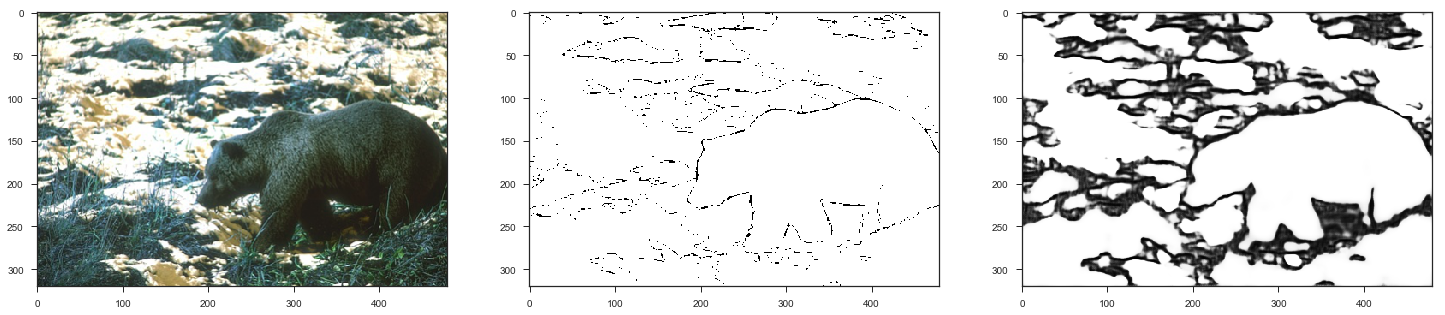

In [48]:
y_pred_1 = model.predict(X_train[2].reshape((-1,320,480,3)))
y_pred_1 = y_pred_1.reshape((320, 480))
np.savetxt(DATA_PATH + '/hahaha.csv', y_pred_1, fmt='%3f')
# y_pred_1[y_pred_1 >= 1] = 1
# y_pred_1[y_pred_1 < 1] = 0
plt.figure(figsize=(25,16))
plt.subplot(1,3,1)
plt.imshow(X_train[2], cmap='binary')
plt.subplot(1,3,2)
plt.imshow(y_train[2].reshape((320,480)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred_1, cmap='binary')
plt.show()

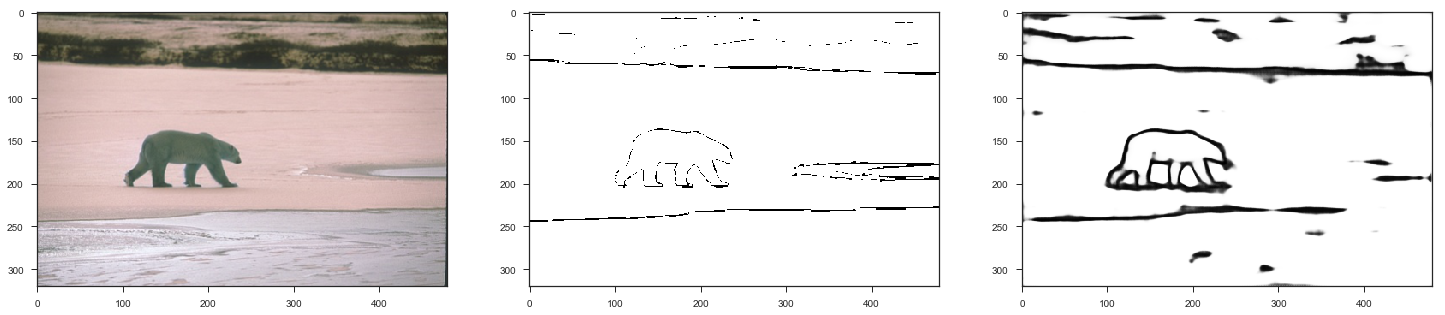

In [49]:
y_pred_1 = model.predict(X_test[0].reshape((-1,320,480,3)))
y_pred_1 = y_pred_1.reshape((320, 480))
np.savetxt(DATA_PATH + '/hahaha.csv', y_pred_1, fmt='%3f')
# y_pred_1[y_pred_1 >= 1] = 1
# y_pred_1[y_pred_1 < 1] = 0
plt.figure(figsize=(25,16))
plt.subplot(1,3,1)
plt.imshow(X_test[0], cmap='binary')
plt.subplot(1,3,2)
plt.imshow(y_test[0].reshape((320,480)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred_1, cmap='binary')
plt.show()

In [50]:
model.save_weights(WEIGHT_PATH + 'UNET_weight_v2.h5')

In [44]:
model.save(MODEL_PATH + 'UNET_model_v1.h5')
model_json = model.to_json()
with open(MODEL_PATH + 'UNET_model_v1.json', "w") as json_file:
    json_file.write(model_json)

In [16]:
model = hed()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 480, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 240, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [17]:
# Fit model
# earlystopper = EarlyStopping(patience=5, verbose=2)
checkpointer = ModelCheckpoint('model-ImageEdge-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=5, 
                    callbacks=[checkpointer], verbose=1)

ValueError: The model expects 6 target arrays, but only received one array. Found: array with shape (200, 320, 480, 1)

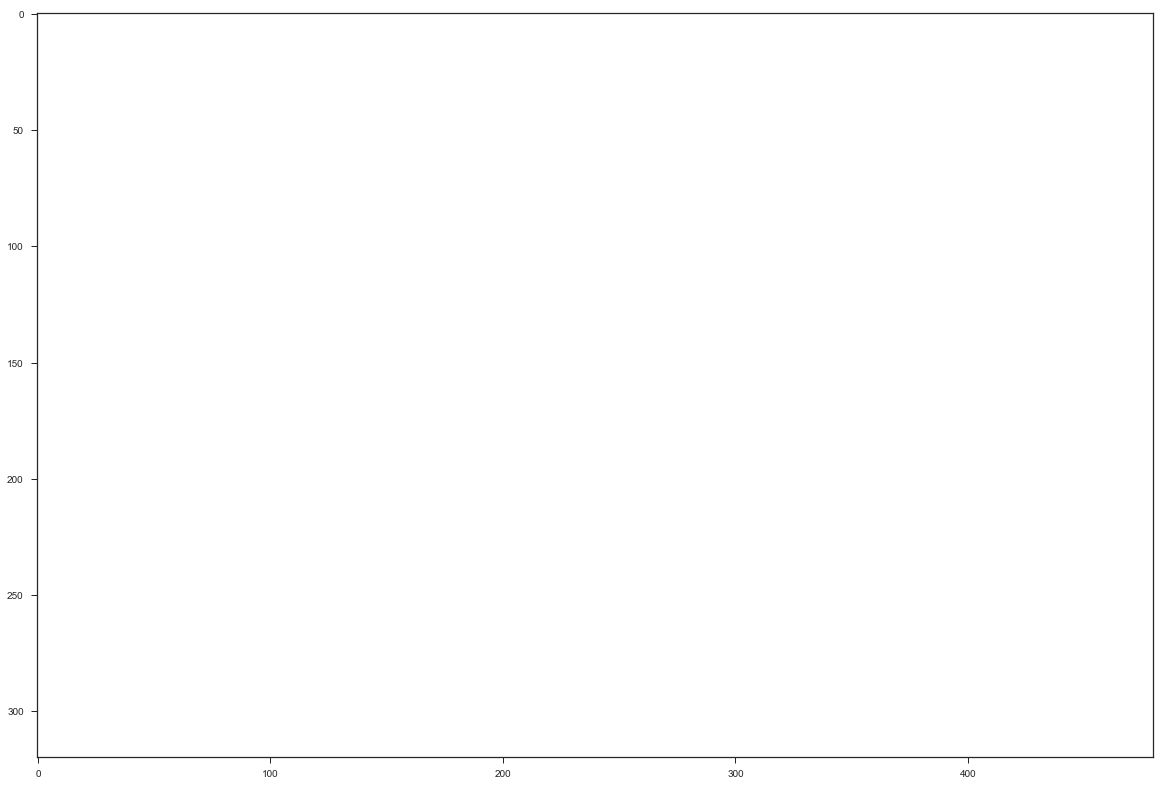

In [118]:
y_pred_1 = model.predict(X_train[5].reshape((-1,320,480,3)))
y_pred_1 = y_pred_1.reshape((320, 480))
np.savetxt(DATA_PATH + '/hahaha.csv', y_pred_1, fmt='%3f')
y_pred_1[y_pred_1 >= 1] = 1
y_pred_1[y_pred_1 < 1] = 0
plt.figure(figsize=(20,16))
plt.imshow(y_pred_1, cmap='binary')
plt.show()

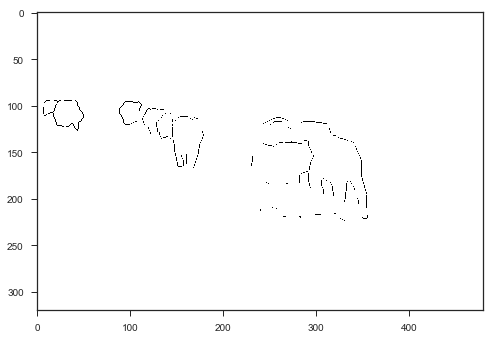

In [46]:
plt.imshow(y_train[5].reshape((320, 480)), cmap='binary')
plt.show()

In [28]:
batch_size = 10
epochs = 5
model.compile(optimizer = 'adam', 
                   loss = focal_loss, 
                   metrics = ['acc', 'mse'])
model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, verbose=2, 
     validation_data=(X_val, y_val))

Train on 200 samples, validate on 100 samples
Epoch 1/5


 - 2s - loss: 2.7765e-23 - acc: 0.6250 - mean_squared_error: 164.0070 - val_loss: 2.7448e-23 - val_acc: 0.6499 - val_mean_squared_error: 146.8110


Epoch 2/5


 - 1s - loss: 2.7765e-23 - acc: 0.6250 - mean_squared_error: 164.0070 - val_loss: 2.7448e-23 - val_acc: 0.6499 - val_mean_squared_error: 146.8110


Epoch 3/5


 - 1s - loss: 2.7765e-23 - acc: 0.6250 - mean_squared_error: 164.0070 - val_loss: 2.7448e-23 - val_acc: 0.6499 - val_mean_squared_error: 146.8110


Epoch 4/5


 - 1s - loss: 2.7765e-23 - acc: 0.6250 - mean_squared_error: 164.0070 - val_loss: 2.7448e-23 - val_acc: 0.6499 - val_mean_squared_error: 146.8110


Epoch 5/5


 - 1s - loss: 2.7765e-23 - acc: 0.6250 - mean_squared_error: 164.0070 - val_loss: 2.7448e-23 - val_acc: 0.6499 - val_mean_squared_error: 146.8110


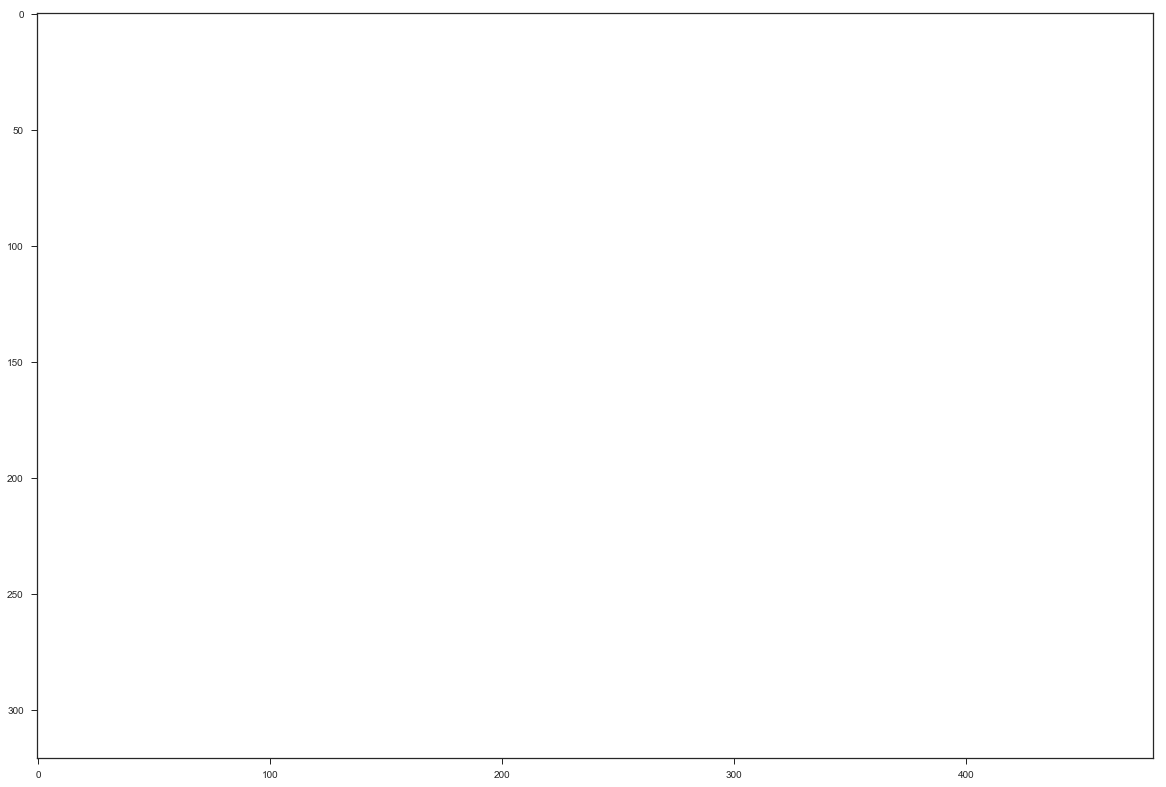

In [26]:
y_pred_1 = model.predict(X_train[5].reshape((-1,321,481,3)))
y_pred_1 = y_pred_1.reshape((321, 481))
np.savetxt(DATA_PATH + '/hahaha2.txt', y_pred_1, delimiter=',', fmt='%d')
y_pred_1[y_pred_1 >= 1] = 1
y_pred_1[y_pred_1 < 1] = 0
plt.figure(figsize=(20,16))
plt.imshow(y_pred_1, cmap='binary')
plt.show()